# Import libraries

In [2]:
# from surprise import BaselineOnly
from surprise import NMF, SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold

from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import os
# import sys
import math
import statistics
import collections

import sklearn as sk
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import pandas as pd

import random
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

import datetime
from datetime import datetime
from time import time
import timeit

from tqdm import tqdm
# from multiprocessing import Pool

Splitting the data using the *userfixed* method, where 80% of each user's data goes to training and the rest to testing set. Surprises split method is randomly. Their method is extended below.

In [3]:
from platform import python_version

print(python_version())

3.9.18


In [4]:
pwd

'/Users/nsonboli/Documents/TheShortWeb'

# Rating Data class 'userfixed' data split method.

In [5]:
class RatingDataset:
    import numpy as np
    from scipy import sparse
    
    def __init__(self):
        self.rating_mat = None
        # self.time_mat = None
        self._data_file_path = ''
        
        # list of raw user_IDs (dataset IDs)
        self.items = []
        self.users = []
        self.item_n = 0
        self.user_n = 0
        
        # maps raw user_id to user_iid(or inner id)
        self.user_to_iid = {}
        # maps user inner id to dataset raw ID
        self.user_to_ID = {}
        # maps raw item_id (dataset) to item_iid(or inner id)
        self.item_to_iid = {}
        # maps item inner id to dataset raw ID
        self.item_to_ID = {}
        
        # list of triples of (item, rating, timestamp) for each user_iid. 
        # TODO: In case there were no Timestamp in the data, pairs of (item, rating) will be kept
        self.user_ratings = []
        # list of pair of (user, rating) for each item_iid
        self.item_ratings = []
        
        
    def __get_line_format_indices(self, line_format):
        # specifying the order of 'user, item, rating, timestamp' in each line 
        lf_sp = line_format.split(' ')
        # if len(lf_sp) != 4:
        #     raise Exception('''Bad line format!
        #     line_format should be space-separated and it should always specified by 
        #     "user item rating timestamp" with any order!''')
        user_idx = -1
        item_idxa = -1
        rating_idx = -1
        # timestamp_idx = -1
        for c in range(len(lf_sp)):
            if lf_sp[c] == 'user':
                user_idx = c
            elif lf_sp[c] == 'item':
                item_idx = c
            elif lf_sp[c] == 'rating':
                rating_idx = c
            # elif lf_sp[c] == 'timestamp':
            #     timestamp_idx = c
            else:
                raise Exception('line_format must be exactly dictated by one of: (user/item/rating/timestamp) separated by sep!')
        
        # return user_idx, item_idx, rating_idx, timestamp_idx
        return user_idx, item_idx, rating_idx
    
    
    '''
        Read the rating data from file and parse it and then make the dataset.
    '''
    # def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating timestamp'):
    def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating'):
        
        # user_fmt_idx, item_fmt_idx, rating_fmt_idx, timestamp_fmt_idx = self.__get_line_format_indices(line_format)
        user_fmt_idx, item_fmt_idx, rating_fmt_idx = self.__get_line_format_indices(line_format)
        
        file = open(data_fn, 'r')
        
        # skip lines that are specified from input
        for _ in range(skip_lines):
            file.readline()
            
        # users list as in input file
        users_lin = []
        items_lin = []
        ratings_lin = []
        # timestamps_lin = []
        for l in file:
            lsp = l.split(sep)
            user_id = lsp[user_fmt_idx]
            item_id = lsp[item_fmt_idx]
            rating = float(lsp[rating_fmt_idx])
            # timestamp = int(lsp[timestamp_fmt_idx].strip('\n'))
            
            users_lin.append(user_id)
            items_lin.append(item_id)
            ratings_lin.append(rating)
            # timestamps_lin.append(timestamp)
            
        self.users = list(set(users_lin))
        self.items = list(set(items_lin))
        
        self.user_n = len(self.users)
        self.item_n = len(self.items)
        
        '''note that raw ids are in STRING format, and the iid in INTEGER format!'''
        # set the mappings
        for idx in range(self.user_n): 
            self.user_to_iid[self.users[idx]] = idx
            
        for idx in range(self.user_n):
            self.user_to_ID[idx] = self.users[idx] 
            
        for idx in range(self.item_n):
            self.item_to_iid[self.items[idx]] = idx 
            
        for idx in range(self.item_n):
            self.item_to_ID[idx] = self.items[idx] 
        
        # init rating matrix
        self.rating_mat = sparse.lil_matrix((self.user_n, self.item_n))
        # self.time_mat = sparse.lil_matrix((self.user_n, self.item_n))
        for idx in range(len(users_lin)):
            user_iid = self.user_to_iid[users_lin[idx]]
            item_iid = self.item_to_iid[items_lin[idx]]
            rating = ratings_lin[idx]
            self.rating_mat[user_iid, item_iid] = rating
            # self.time_mat[user_iid, item_iid] = timestamps_lin[idx]
            
            
    def list_users_ratings(self, rating_matrix):
        # finding the user and item ratings
        user_ratings = []
        for user_iid in range(self.user_n):
            # append a list for this user
            user_ratings.append([])
            user_nonze = np.nonzero(rating_matrix[user_iid])
            for item_iid in user_nonze[1]:
                # add items and its rating into the last user added to the list
                user_ratings[-1].append((item_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return user_ratings
    
            
    def list_items_ratings(self, rating_matrix):
        item_ratings = []
        for item_iid in range(self.item_n):
            # append a list for this item
            item_ratings.append([])
            item_nonze = np.nonzero(rating_matrix.T[item_iid])
            for user_iid in item_nonze[1]:
                # add users and its rating into the last item added to the list
                item_ratings[-1].append((user_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return item_ratings
        
            
    def train_test_split(self, test_percent=0.2, least_userlen_test=10):
        if test_percent > 1:
            raise Exception('test_percent should be between 0 and 1.')
            
        user_ratings = self.list_users_ratings(self.rating_mat)
        
        mat = sparse.lil_matrix((self.user_n, self.item_n))
        user_tests = {}
        n_users_in_test = 0
        n_ratings_in_test = 0
        n_ratings_in_train = 0
        
        for user_iid in range(self.user_n):
            len_u = len(user_ratings[user_iid])
            if len_u >= least_userlen_test:
                n_users_in_test += 1
                test_len = int(len_u * test_percent)
                test_set_u = list(range(len_u))
#                 print(test_len, len_u)
                random.shuffle(test_set_u)
                
                train_set_u = test_set_u[test_len:][:]
                test_set_u = test_set_u[:test_len][:]
                
#                 print(len(train_set_u))
                
                for ir_idx in train_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
                
                user_tests[user_iid] = []
                for ir_idx in test_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    user_tests[user_iid].append(ir)
                    n_ratings_in_test += 1
                    
            else: # if no test set should be seprated from ratings of this user
                for ir in user_ratings[user_iid]:
                    # ir = the pair of (item, rating)
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
    
        print('\nNumber of users with some items in testset: %d' % n_users_in_test)
        print('Number of ratings in trainset: %d \t Number of ratings in testset: %d\n' % (n_ratings_in_train, n_ratings_in_test))
        return mat, user_tests
    

# Data Import

In [8]:
pwd

'/Users/nsonboli/Documents/TheShortWeb'

In [11]:
df = pd.read_csv('Data/ml-100k/udata.csv', 
                 sep=";", header=0, engine="python")

user = pd.read_csv('Data/ml-100k/uuser.csv', 
                   sep=";", header=0, engine ="python")

genre = pd.read_csv('Data/ml-100k/ugenre.csv', 
                    sep=";", header=0, engine = "python")

In [12]:
genre.head()

genre  id
0     unknown   0
1      Action   1
2   Adventure   2
3   Animation   3
4  Children's   4

## Dimensionality Reduction - ncore

In [13]:
n_core = 3

In [14]:
# To reduce the dimensionality of the dataset,
# we will filter out rarely rated movies and rarely rating users

min_ratings = n_core
min_user_ratings = n_core

init_df = df
init_shp = df.shape[0]
filt_shp = 0.0

while True:

    filter_items = init_df['item'].value_counts() > min_ratings
    filter_items = filter_items[filter_items == True].index.tolist()

    filter_users = init_df['user'].value_counts() > min_user_ratings
    filter_users = filter_users[filter_users == True].index.tolist()

    filt_df = init_df[(init_df['item'].isin(filter_items)) & (init_df['user'].isin(filter_users))]

    print('The original data frame shape:\t{}'.format(init_df.shape))
    print('The new data frame shape:\t{}'.format(filt_df.shape))
    print()
    
    init_shp = init_df.shape[0]
    filt_shp = filt_df.shape[0]
    
    # print(init_shp, filt_shp)
    
    if (init_shp == filt_shp):
        break
    
    init_df = filt_df

    
#------------------------------------------------------------
'Updating the df to its filtered version'
'Now filt-df is called df.' 
df = filt_df
print(filt_df.shape)
print(df.head())

print()
print('#users: ', np.unique(df['user']).shape)
print('#items: ', np.unique(df['item']).shape)

The original data frame shape:	(100000, 3)
The new data frame shape:	(99543, 3)

The original data frame shape:	(99543, 3)
The new data frame shape:	(99543, 3)

(99543, 3)
   user  item  rating
0   196   242       3
1   186   302       3
2    22   377       1
3   244    51       2
4   166   346       1

#users:  (943,)
#items:  (1413,)


### Filtering the user.dat file based on the ncore process

In [15]:
user.head(2)

id  age gender  occupation zipcode
0   1   24      M  technician   85711
1   2   53      F       other   94043

In [16]:
# initial # of users
user.shape

(943, 5)

In [17]:
user = user[user['id'].isin(np.unique(df['user']))]
user.shape

(943, 5)

In [18]:
user.shape

(943, 5)

### Saving the filtered rating data & re-reading it again

In [21]:
df.to_csv('./filtered_ml_%icore.csv'%n_core, sep=',', index=False)

In [22]:
df = pd.read_csv('./filtered_ml_%icore.csv'%n_core, sep=',')
print(df.shape)
df.head()

(99543, 3)


user  item  rating
0   196   242       3
1   186   302       3
2    22   377       1
3   244    51       2
4   166   346       1

## Data Preprocessing (pro & unpro)

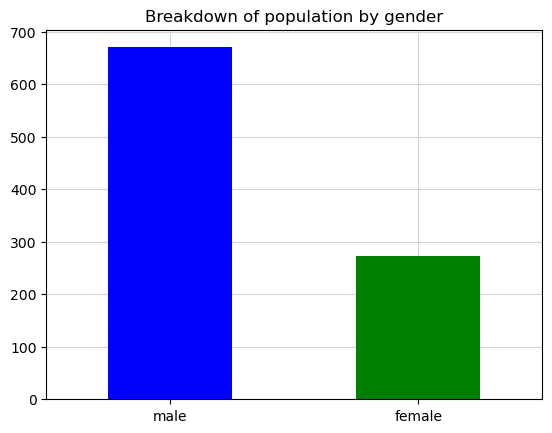

In [23]:
# print(user.head(2))
# print(user.shape)

#  We consider "gender" as the sensitive attribute.
    # F is the protected value and M is the unprotected value.

#------------------------------------------------------------
'The protected and the unprotected'

user['is_pro'] = 0
for i, row in user.iterrows():
    if row['gender'] == 'F':
        user.loc[i,'is_pro'] = 1
        
# user.head(3)

#------------------------------------------------------------
'preliminary stats'

breakbygender = pd.value_counts(user['is_pro'].values,sort=False)
# print(breakbygender,'\n')

ax = breakbygender.plot(kind='bar', title='Breakdown of population by gender', color=['b', 'g'])
ax.grid(True, color='lightgray', linestyle='-')
ax.set_xticks([0,1])
ax.set_xticklabels(['male', 'female'], rotation='horizontal')
ax.set_axisbelow(True)

#------------------------------------------------------------



In [24]:
breakbygender

0    670
1    273
dtype: int64

### original ratio of women to men 

In [25]:
breakbygender.get(1) / (breakbygender.get(0) + breakbygender.get(1))

0.28950159066808057

In [26]:
breakbygender.get(1) / breakbygender.get(0)

0.40746268656716417

### number of ratings by m & w in dataset (whole)

In [27]:
user[(user['id'] == 186) & (user['gender'] == 'F')]

id  age gender occupation zipcode  is_pro
185  186   39      F  executive       0       1

In [28]:
np.any((user['id'] == 186) & (user['gender'] == 'F'))

True

In [29]:
f_rating_count = 0 
m_rating_count = 0

for a, b in df.groupby('user'):
    if np.any((user['id'] == a) & (user['gender'] == 'F')):
        f_rating_count += len(b)
    else:
        m_rating_count += len(b)
        
print(f_rating_count)
print(m_rating_count)
        

25556
73987


In [30]:
# probability oof rating by a woman
f_rating_count/(f_rating_count+m_rating_count)


0.25673327104869254

In [31]:
user.head()

id  age gender  occupation zipcode  is_pro
0   1   24      M  technician   85711       0
1   2   53      F       other   94043       1
2   3   23      M      writer   32067       0
3   4   24      M  technician   43537       0
4   5   33      F       other   15213       1

## Rating Distribution 

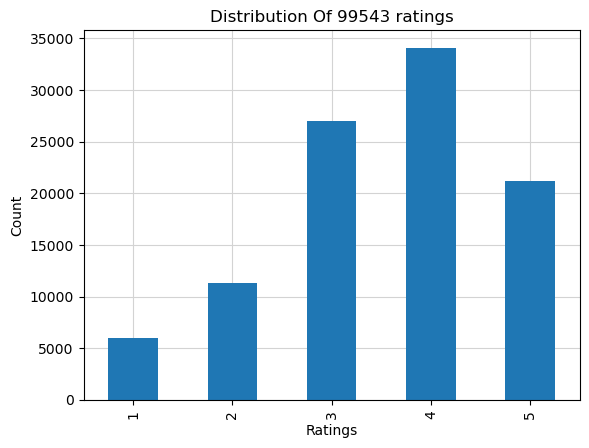

In [32]:
data = df['rating'].value_counts().sort_index(ascending=True)

ax = data.plot(kind='bar', title='Distribution Of {} ratings'.format(df.shape[0]))
ax.grid(True, color='lightgray', linestyle='-')
# ax.set_xticks([0,1,2,3,4])
ax.set_xlabel('Ratings')
ax.set_ylabel('Count')
ax.set_axisbelow(True)


In [33]:
data

1     5957
2    11299
3    27030
4    34094
5    21163
Name: rating, dtype: int64

In [34]:
# df[(df['user']).isin(user.loc[user['gender'] == 'F', 'id'])]['rating']

Text(0, 0.5, 'Count')

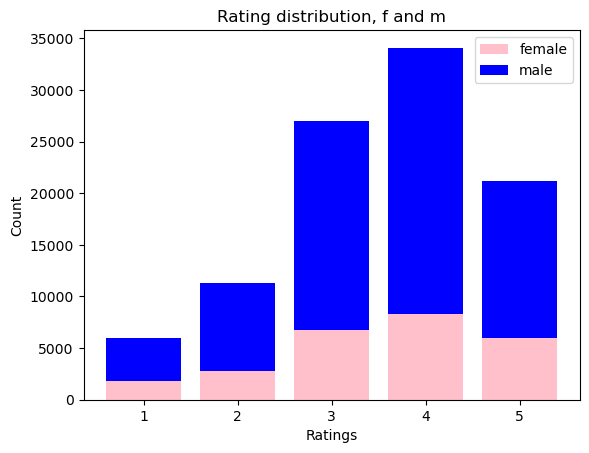

In [35]:
data_f = df[(df['user']).isin(user.loc[user['gender'] == 'F', 'id'])]['rating'].value_counts().sort_index(ascending=False)
data_m = df[(df['user']).isin(user.loc[user['gender'] == 'M', 'id'])]['rating'].value_counts().sort_index(ascending=False)


# ax = data_f.bar(title='Distribution Of {} ratings for men and women'.format(df.shape[0]))
# ax = data_m.bar(title='Distribution Of {} ratings for men and women'.format(df.shape[0]))

plt.bar(data_f.index, data_f, color='pink')
plt.bar(data_m.index, data_m, bottom=data_f, color='b')

plt.title('Rating distribution, f and m')
plt.legend(['female', 'male'])
# # plt.set_xticks([0,1,2,3,4])
plt.xlabel('Ratings')
plt.ylabel('Count')
# plt.grid(color='lightgray', which='major')
# plt.show()


In [36]:
data_f

5    5967
4    8284
3    6723
2    2756
1    1826
Name: rating, dtype: int64

In [37]:
data_m

5    15196
4    25810
3    20307
2     8543
1     4131
Name: rating, dtype: int64

In [38]:
data_f / (data_f + data_m)

5    0.281954
4    0.242975
3    0.248724
2    0.243915
1    0.306530
Name: rating, dtype: float64

In [39]:
data_m / (data_f + data_m)

5    0.718046
4    0.757025
3    0.751276
2    0.756085
1    0.693470
Name: rating, dtype: float64

70% of the ratings belong to men approximately. Their view peobably affects the general view.

### Ratings Distribution By Item

Text(0, 0.5, 'Count')

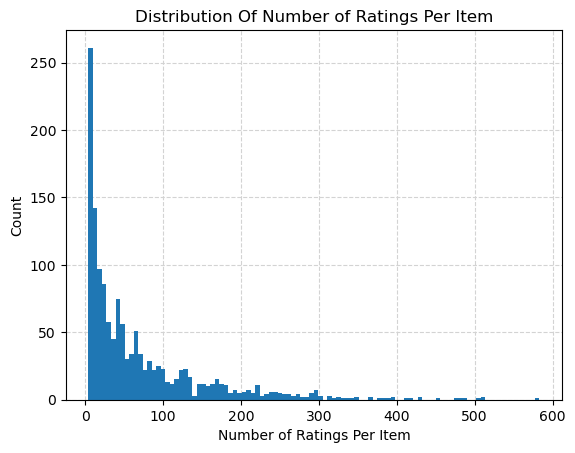

In [40]:
# Number of ratings per movie
data = df.groupby('item')['rating'].count()#.clip(upper=50)

ax = data.plot.hist(title='Distribution Of Number of Ratings Per Item', bins=100)
ax.grid(True, color='lightgray', linestyle='--')
# ax.set_xticks([0,1,2,3,4])
ax.set_axisbelow(True)
ax.set_xlabel('Number of Ratings Per Item')
ax.set_ylabel('Count')


#### By gender

In [41]:
# df[(df['user']).isin(user.loc[user['gender'] == 'F', 'id'])]

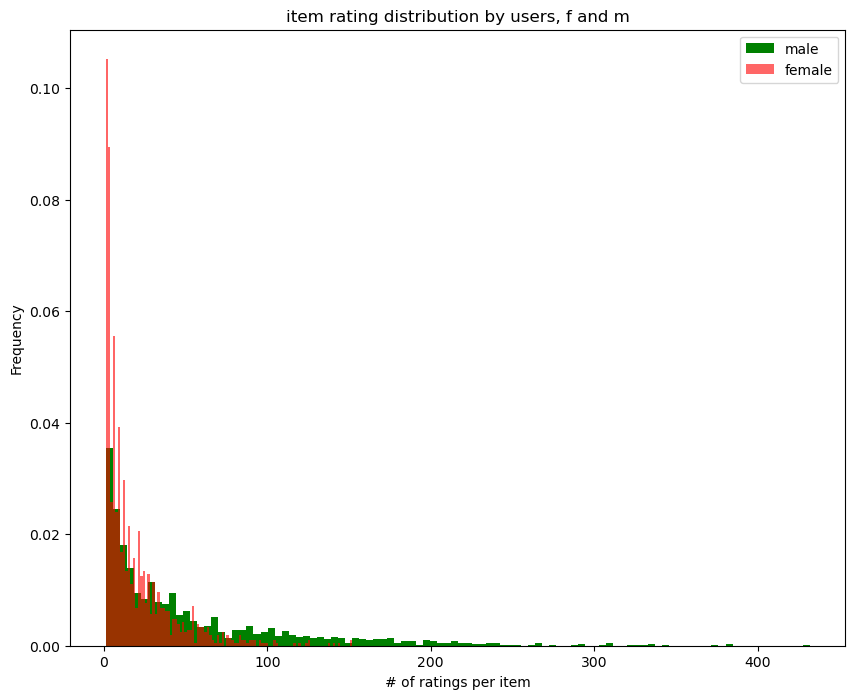

In [42]:
data_f = df[(df['user']).isin(user.loc[user['gender'] == 'F', 'id'])].groupby('item')['rating'].count()
data_m = df[(df['user']).isin(user.loc[user['gender'] == 'M', 'id'])].groupby('item')['rating'].count()


#Stack the data
plt.figure(figsize=(10,8))
# plt.hist([data_f, data_m], stacked=True, density=True)
# ax = data_m.plot.hist(bins=100, label='male', density=1, color='green')
# ax = data_f.plot.hist(bins=100, label='female', alpha=0.6,density=1, color='red')
ax = data_m.plot.hist(bins=100, label='male', density=1, color='green')
ax = data_f.plot.hist(bins=100, label='female', alpha=0.6,density=1, color='red')


ax.set_title('item rating distribution by users, f and m')
ax.set_xlabel('# of ratings per item')
ax.legend()
plt.show()


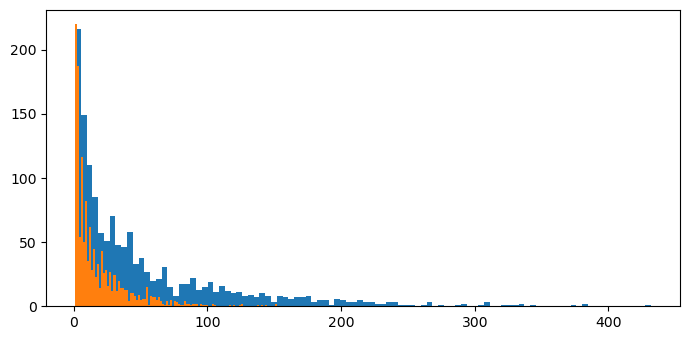

In [43]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
# a = np.random.random(100) * 0.5
# b = 1 - np.random.normal(size=100) * 0.1
bins = 100
b = np.histogram(np.hstack((data_f, data_m)), bins=bins)[1]
plt.hist(data_m, bins)
plt.hist(data_f, bins) # edgecolor='black'

plt.show()

- women have less ratings than men in general
- the long tail is shorter (but probably the controvertial items)
- their ratings are more focused on the popular items
- women's ratings of more popular items are more while men's ratings are more diverse and on more items.
    - so then shoudln't women receive good ratings because they are close to the majority of users?

- @INSIGHT: many of the items that are removed actually were rated by women! wth! we have many cold start users that are women! 
- all the users have at least 20 ratings, but after the ncore, some of them are removed. in the long tail there are items that are rated by men and women but are removed after the ncore. This could exacerbate the accuracy imbalance.
- we should try the data as is as well.
- there are some items that are only rated by men or women! specially in the long tail.


#### are cold start users more women or men?

In [64]:
c_strt_usr = []
c = 0
exp = pd.read_csv('Data/ml-100k/udata.csv', sep=";", header=0, engine="python")
for a, b in exp.groupby('user'):
#     print(a, len(b))
    if len(b) < 24:
        c+=1
        c_strt_usr.append(dataset.user_to_iid[str(a)])

# print (c_strt_usr, c)
print(c)

100


In [66]:
c_pro = 0
c_unpro = 0
for i in c_strt_usr:
    if i in pro_users_index:
        c_pro+= 1
    else:
        c_unpro+=1
        
print(len(c_strt_usr), 'women:', c_pro, 'men:', c_unpro)
    

NameError: name 'pro_users_index' is not defined

- we have some nan values below

In [47]:
ratings_f_m = pd.DataFrame([data_f,data_m])
ratings_f_m

item     1      2     3      4     5     6      7      8      9     10    ...  \
rating  119.0   19.0  16.0   45.0  22.0   5.0   82.0   60.0   83.0  20.0  ...   
rating  333.0  112.0  74.0  164.0  64.0  21.0  310.0  159.0  216.0  69.0  ...   

item    1367  1369  1410  1440  1449  1456  1485  1512  1524  1597  
rating   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
rating   5.0   4.0   4.0   5.0   8.0   7.0   4.0   6.0   8.0   5.0  

[2 rows x 1413 columns]

In [48]:
# data_m[1672] == data_m[1672]

In [49]:
# np.any(pd.isna(data_f))

In [50]:
# np.isinf(data_m[1644])

In [51]:
# data_m[1672]

In [52]:
# we have this many items, so the length is fine
ratings_f_m.shape

(2, 1413)

### Ratings Distribution By User

Text(0, 0.5, 'Count')

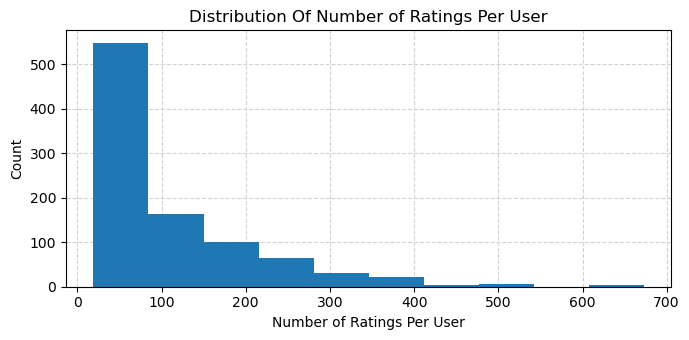

In [53]:
data = df.groupby('user')['rating'].count()#.clip(upper=50)

ax = data.plot.hist(title='Distribution Of Number of Ratings Per User')
ax.grid(True, color='lightgray', linestyle='--')
# ax.set_xticks([0,1,2,3,4])
ax.set_axisbelow(True)
ax.set_xlabel('Number of Ratings Per User')
ax.set_ylabel('Count')

# RatingDataset() class

To load a dataset from a pandas dataframe, we will use the load_from_df() method The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

## Split into train and test

Note that this class is based on the data class in Surprise but it is not the same or connected to it whatsoever.

In [54]:
# data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

dataset = RatingDataset()
data_fn = './filtered_ml_%icore.csv'%n_core
dataset.read_from_file(data_fn, skip_lines=1, line_format='user item rating', sep=',')

print('# users', dataset.user_n)
print('# items', dataset.item_n)

# user_tests is the test_mat
train_mat, test_mat = dataset.train_test_split(test_percent=0.2, least_userlen_test=10)

# ir = the pair of (item, rating)
# ir = user_ratings[user_iid][ir_idx]

user_ratings = dataset.list_users_ratings(dataset.rating_mat)
print(dataset.rating_mat.shape)

# users 943
# items 1413

Number of users with some items in testset: 943
Number of ratings in trainset: 79998 	 Number of ratings in testset: 19545

(943, 1413)


In [55]:
len(user_ratings)

943

In [56]:
# raw id to index
print(dataset.user_to_iid['186'], type(dataset.user_to_iid['186']))

# index to raw id
print(dataset.user_to_ID[452], type(dataset.user_to_ID[452]))

81 <class 'int'>
552 <class 'str'>


In [57]:
user_ratings[861][:5] #(item_iid, rating) for user '196' or user_iid=185

[(60, 4.0), (92, 5.0), (116, 3.0), (150, 5.0), (167, 4.0)]

In [58]:
train_mat

<943x1413 sparse matrix of type '<class 'numpy.float64'>'
	with 79998 stored elements in List of Lists format>

In [59]:
len(test_mat)

943

In [60]:
# a specific user's ratings
# train_mat[185].todense()

In [61]:
print(test_mat[861])

[(415, 2.0), (594, 5.0), (931, 5.0), (1253, 4.0), (60, 4.0), (305, 3.0), (1252, 3.0), (1095, 5.0), (540, 3.0), (1096, 5.0)]


In [62]:
# train_dense = train_mat.todense()
# print(train_dense.shape)
# train_dense[:5]

In [63]:
# len(test_mat.items())

## Train & Test to Dataframes

In [67]:
user_ratings = dataset.list_users_ratings(train_mat)
# user_ratings[0]
# train_df = pd.DataFrame(columns = ['item','rating'])

tr_lst = []

for user_iid in range(dataset.user_n): 
    # trainset or dataset.user_n?? we keep the users the same (user-fixed) so they are equal.
    
    if user_ratings[user_iid]:
        base_rec = pd.DataFrame(user_ratings[user_iid])
        base_rec[2] = user_iid

        tr_lst.append(base_rec[[2,0,1]])
    
train_df = pd.concat(tr_lst, ignore_index=True)
train_df.columns = ['user','item','rating']
train_df.head()

user  item  rating
0     0    51     4.0
1     0    70     3.0
2     0   147     5.0
3     0   175     3.0
4     0   198     5.0

In [68]:
train_df.shape

(79998, 3)

In [69]:
np.unique(train_df['user']).shape

(943,)

In [70]:
np.unique(train_df['item']).shape

(1413,)

In [71]:
train_df.shape

(79998, 3)

In [72]:
# test set to a dataframe
test_lst = []

for uiid in test_mat.keys():
    base_rec = pd.DataFrame(test_mat[uiid])
    base_rec[2] = uiid
    test_lst.append(base_rec[[2,0,1]])


test_df = pd.concat(test_lst, ignore_index=True)
test_df.columns = ['user','item','rating']
test_df.head()

user  item  rating
0     0   311     2.0
1     0   779     5.0
2     0   825     4.0
3     0   844     4.0
4     0   383     4.0

In [73]:
test_df.shape

(19545, 3)

In [74]:
np.unique(test_df['item']).shape

(1332,)

In [75]:
np.unique(train_df['item']).shape

(1413,)

In [76]:
test_df['item'].shape

(19545,)

In [77]:
np.unique(test_df['user']).shape

(943,)

In [78]:
test_df.shape[0] + train_df.shape[0]

99543

## rating distribution of  training set and test set

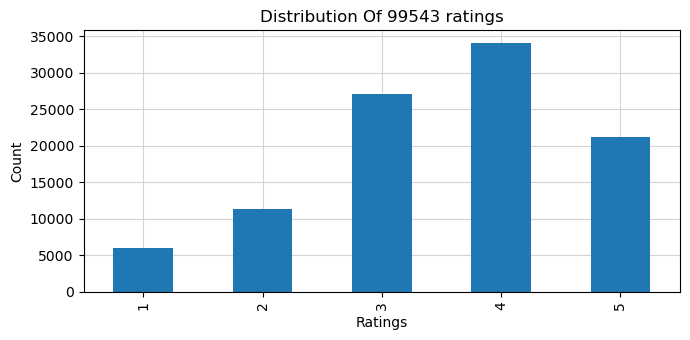

In [80]:
# all_d = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates(keep=False)
# print(all_d.shape)
# df.equals(all_d)b
data = df['rating'].value_counts().sort_index(ascending=True)

ax = data.plot(kind='bar', title='Distribution Of {} ratings'.format(df.shape[0]))
ax.grid(True, color='lightgray', linestyle='-')
ax.set_xticks([0,1,2,3,4])
ax.set_xlabel('Ratings')
ax.set_ylabel('Count')
ax.set_axisbelow(True)

Float64Index([5.0, 4.0, 3.0, 2.0, 1.0], dtype='float64')
Float64Index([5.0, 4.0, 3.0, 2.0, 1.0], dtype='float64')


Text(0, 0.5, 'Count')

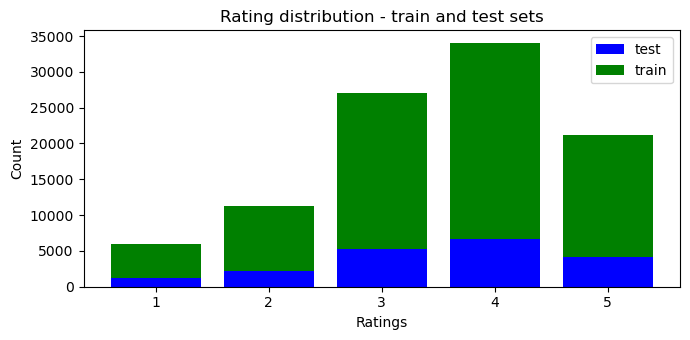

In [81]:
data_tr = train_df['rating'].value_counts().sort_index(ascending=False)
data_ts = test_df['rating'].value_counts().sort_index(ascending=False)

print(data_tr.index)
print(data_ts.index)

plt.bar(data_ts.index, data_ts, color='b')
plt.bar(data_tr.index, data_tr, bottom=data_ts, color='g')

plt.title('Rating distribution - train and test sets')
plt.legend(['test', 'train'])
# plt.grid(True, color='lightgray', linestyle='-')
# plt.set_xticks([0,1,2,3,4])
plt.xlabel('Ratings')
plt.ylabel('Count')

## Pro and Unpro - id to iid (ID to Index)

In [82]:
user.dtypes
# turn user id into string so you can retrieve int iid

id             int64
age            int64
gender        object
occupation    object
zipcode       object
is_pro         int64
dtype: object

In [83]:
'pro & unpro data structures'

# global pro_users_id
# global unpro_users_id

# pro_users_id = []
# unpro_users_id = []

global pro_users_index
global unpro_users_index

pro_users_index = []
unpro_users_index = []


# initializing a column
# this is inner id or index
user['iid'] = 0

for i, row in user[['id', 'is_pro']].iterrows():
    
    # user id to inner_id (index)
    u_index = dataset.user_to_iid[str(row['id'])]
    # print(row['id'], u_index, dataset.user_to_ID[u_index])
    
    # just add the inner id (index) to the user dataframe
    user.loc[user['id']==row['id'], 'iid'] = u_index
    
    
    if row['is_pro'] == 1:
        # pro_users_id.append(row['id'])
        pro_users_index.append(u_index)
    
    else:
        # unpro_users_id.append(row['id'])
        unpro_users_index.append(u_index)  


print('protected users', len(pro_users_index))
print('unprotected users', len(unpro_users_index))
print()

user.head(5)


protected users 273
unprotected users 670



id  age gender  occupation zipcode  is_pro  iid
0   1   24      M  technician   85711       0  874
1   2   53      F       other   94043       1  107
2   3   23      M      writer   32067       0  680
3   4   24      M  technician   43537       0  576
4   5   33      F       other   15213       1  787

In [84]:
user[user['iid'] == 135]

id  age gender occupation zipcode  is_pro  iid
109  110   19      M    student   77840       0  135

### iid 2 gender & reverse

In [85]:
# dictionary of iid and gender

iid_to_gender = dict(zip(user.iid, user.gender))
gender_to_iid = dict(zip(user.gender, user.iid))

id_to_gender = dict(zip(user.id, user.gender))
gender_to_id = dict(zip(user.gender, user.id))


In [86]:
user[user['id']==4]

id  age gender  occupation zipcode  is_pro  iid
3   4   24      M  technician   43537       0  576

In [87]:
dataset.user_to_ID[458]

'856'

In [88]:
dataset.user_to_iid['4']

576

In [89]:
# train_df[train_df['user']==852].sort_values(by='item')

In [90]:
dataset.item_to_ID[95]

'1148'

### Deepcopy train & test w gender info

In [91]:
#copy training set
# it won't affect train_df, only the copy has an extra column
train_df_cp = train_df.copy(deep=True)
test_df_cp = test_df.copy(deep=True)


train_df_cp['gender'] = train_df['user'].map(iid_to_gender)
test_df_cp['gender'] = test_df['user'].map(iid_to_gender)

In [92]:
test_df.head()

user  item  rating
0     0   311     2.0
1     0   779     5.0
2     0   825     4.0
3     0   844     4.0
4     0   383     4.0

In [93]:
test_df_cp.head()

user  item  rating gender
0     0   311     2.0      M
1     0   779     5.0      M
2     0   825     4.0      M
3     0   844     4.0      M
4     0   383     4.0      M

### rating , gender, count (tr, ts)

In [94]:
m_f_cnt = []
for a, b in train_df_cp.groupby(['rating', 'gender']):
    m_f_cnt.append((float(a[0]), a[1], int(len(b))))
    print(a, len(b))
    
# print(m_f_cnt, '\n') 
print()

m_f_cnt_ts = []
for a, b in test_df_cp.groupby(['rating', 'gender']):
    m_f_cnt_ts.append((float(a[0]), a[1], int(len(b))))
    print(a, len(b))
    
# print(m_f_cnt_ts)

(1.0, 'F') 1439
(1.0, 'M') 3306
(2.0, 'F') 2200
(2.0, 'M') 6862
(3.0, 'F') 5415
(3.0, 'M') 16361
(4.0, 'F') 6667
(4.0, 'M') 20707
(5.0, 'F') 4829
(5.0, 'M') 12212

(1.0, 'F') 387
(1.0, 'M') 825
(2.0, 'F') 556
(2.0, 'M') 1681
(3.0, 'F') 1308
(3.0, 'M') 3946
(4.0, 'F') 1617
(4.0, 'M') 5103
(5.0, 'F') 1138
(5.0, 'M') 2984


In [95]:
np.array(m_f_cnt)[::2, :]

array([['1.0', 'F', '1439'],
       ['2.0', 'F', '2200'],
       ['3.0', 'F', '5415'],
       ['4.0', 'F', '6667'],
       ['5.0', 'F', '4829']], dtype='<U32')

In [96]:
np.array(m_f_cnt)[::-2, :][::-1]

array([['1.0', 'M', '3306'],
       ['2.0', 'M', '6862'],
       ['3.0', 'M', '16361'],
       ['4.0', 'M', '20707'],
       ['5.0', 'M', '12212']], dtype='<U32')

### plot ratings sep by gender and tr/ts

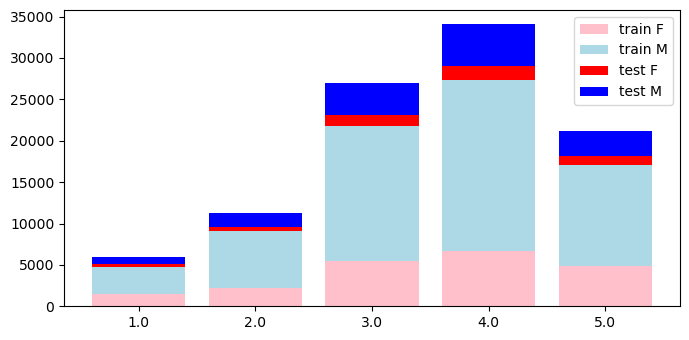

In [97]:


# female train
f_tr = np.array(m_f_cnt)[::2, :]
plt.bar(f_tr[:, 0], f_tr[:, 2].astype(int), color='pink', label='train F')

m_tr = np.array(m_f_cnt)[::-2, :][::-1]
plt.bar(m_tr[:, 0], m_tr[:, 2].astype(int),
        bottom = f_tr[:, 2].astype(int), color='lightblue', label='train M')



# test set
f_ts = np.array(m_f_cnt_ts)[::2, :]
plt.bar(f_ts[:, 0], f_ts[:, 2].astype(int),
        bottom=f_tr[:, 2].astype(int) + m_tr[:, 2].astype(int), 
        color='red', label='test F')

m_ts = np.array(m_f_cnt_ts)[::-2, :][::-1]
plt.bar(m_ts[:, 0], m_ts[:, 2].astype(int),
        bottom = f_tr[:, 2].astype(int) + m_tr[:, 2].astype(int) + f_ts[:, 2].astype(int),
        color='blue', label='test M')


plt.legend()

### ratio of women to men in train and text

In [98]:

print('training set')
# train f
p_f_r = f_tr[:, 2].astype(int) / (f_tr[:, 2].astype(int) + m_tr[:, 2].astype(int))
p_m_r = m_tr[:, 2].astype(int) / (f_tr[:, 2].astype(int) + m_tr[:, 2].astype(int))

print(('prob Fem given rating \t one {0} \n\t\t\t two {1} \n\t\t\t three {2} ' +
      '\n\t\t\t four {3} \n\t\t\t five {4}').format(*p_f_r))
print()
print(('prob Mal given rating \t one {0} \n\t\t\t two {1} \n\t\t\t three {2} ' + 
      '\n\t\t\t four {3} \n\t\t\t five {4}').format(*p_m_r))
# print(p_f_r + p_m_r)



print('\n\ntest set')
p_f_r_ts = f_ts[:, 2].astype(int) / (f_ts[:, 2].astype(int) + m_ts[:, 2].astype(int))
p_m_r_ts = m_ts[:, 2].astype(int) / (f_ts[:, 2].astype(int) + m_ts[:, 2].astype(int))

print(('prob Fem given rating \t one {0} \n\t\t\t two {1} \n\t\t\t three {2} ' + 
      '\n\t\t\t four {3} \n\t\t\t five {4}').format(*p_f_r_ts))
print()
print(('prob Mal given rating \t one {0} \n\t\t\t two {1} \n\t\t\t three {2} ' + 
      '\n\t\t\t four {3} \n\t\t\t five {4}').format(*p_m_r_ts))



training set
prob Fem given rating 	 one 0.3032665964172814 
			 two 0.24277201500772455 
			 three 0.2486682586333578 
			 four 0.243552275882224 
			 five 0.2833753887682648

prob Mal given rating 	 one 0.6967334035827186 
			 two 0.7572279849922754 
			 three 0.7513317413666422 
			 four 0.7564477241177759 
			 five 0.7166246112317353


test set
prob Fem given rating 	 one 0.3193069306930693 
			 two 0.248547161376844 
			 three 0.24895317853064333 
			 four 0.240625 
			 five 0.27607957302280445

prob Mal given rating 	 one 0.6806930693069307 
			 two 0.751452838623156 
			 three 0.7510468214693566 
			 four 0.759375 
			 five 0.7239204269771955


The ratio oof men and women in train and test is similar. The probability of being a women given you have rated an item one is 30% which is higher than other ratings.

### rating cnt, avg, median of ratings for m and f (TRAINING SET)

- if the distribution is symmetrical mean and meadian will be the same
- if the dist is skewed to the right (positively skewed, or the right side is thinner), it means that smaller numbers are more, then the median becomes one fo those small numbers. Since mean changes when when a few big numbers are added, mean becomes bigger. So median will be smaller than the mean.
- if it is skewed to the left or negatively skewed, the big numbers are more and so the median is a big number. the mean changes and becomes smaller as small numbers are added to it, so the median becomes bigger than the mean.
- so if median > mean, the dist is left skewed, so higher ratings are more common.
- if the median < mean, the dist is right skewed, so lower ratings are more common.
- is the difference statistically significant or not?

In [99]:
train_df_cp.head()

user  item  rating gender
0     0    51     4.0      M
1     0    70     3.0      M
2     0   147     5.0      M
3     0   175     3.0      M
4     0   198     5.0      M

In [100]:

for a, b in train_df_cp.groupby(['item', 'gender']):
    
    print(a, b, '\n', b['rating'].median(), b['rating'].mean())
    
    if b['rating'].median() > b['rating'].mean():
        print('left skewed. higher ratings are more common.\n')
        
    elif b['rating'].median() < b['rating'].mean():
        print('right skewed. lower ratings are more common.\n')
    
    else:
        print('symmetrical. ratings follow a symmetrical normal dist\n')
        

(0, 'F')        user  item  rating gender
20894   236     0     5.0      F
40718   479     0     1.0      F
74478   887     0     3.0      F 
 3.0 3.0
symmetrical. ratings follow a symmetrical normal dist

(0, 'M')        user  item  rating gender
5772     70     0     2.0      M
11401   133     0     3.0      M
16586   183     0     3.0      M 
 3.0 2.6666666666666665
left skewed. higher ratings are more common.

(1, 'F')        user  item  rating gender
6887     89     1     5.0      F
8174     96     1     5.0      F
11351   132     1     3.0      F
15439   173     1     5.0      F
20470   228     1     5.0      F
27399   313     1     5.0      F
27922   318     1     5.0      F
28061   323     1     5.0      F
28784   333     1     5.0      F
31970   378     1     5.0      F
32869   389     1     5.0      F
34690   406     1     5.0      F
40719   479     1     1.0      F
43528   515     1     5.0      F
46813   562     1     3.0      F
48243   577     1     5.0      F
51313   610 

#### train

In [101]:
# training set
# this is calcualted based on the training set only


# a dictionary of the number of ratings an item has received from men and women separately
# a dictionary of median and avg of rating of men & women on an item
item_f_m_cnt_dic = {} 


# starting from here, in case an item is not rated by one gender
for item in list(np.unique(train_df_cp.item)):
    item_f_m_cnt_dic[item] = {'F_c':0., 'M_c':0., 'F_med':0., 'F_avg':0.,'M_med':0., 'M_avg':0.} 

    
for a, b in train_df_cp.groupby(['item', 'gender']):
    
    # how many ratings, rating count
    item_f_m_cnt_dic[a[0]][a[1]+'_c'] += len(b)
    
    # median and mean
    item_f_m_cnt_dic[a[0]][a[1]+'_med'] += b['rating'].median()
    item_f_m_cnt_dic[a[0]][a[1]+'_avg'] += b['rating'].mean()

    
# print(item_f_m_cnt_dict)

item_f_m_cnt = pd.DataFrame.from_dict(item_f_m_cnt_dic, orient='index').reset_index()
item_f_m_cnt.rename(columns={'index':'item_iid'}, inplace=True)

print()
print(item_f_m_cnt.shape)
item_f_m_cnt.head()



(1413, 7)


item_iid   F_c    M_c  F_med     F_avg  M_med     M_avg
0         0   3.0    3.0    3.0  3.000000    3.0  2.666667
1         1  20.0   71.0    5.0  4.450000    5.0  4.422535
2         2   1.0    2.0    3.0  3.000000    3.5  3.500000
3         3  52.0  127.0    4.0  3.826923    4.0  3.669291
4         4   2.0    4.0    2.0  2.000000    3.0  3.000000

#### test

In [102]:
# a dictionary of the number of ratings an item has received from men and women separately
# a dictionary of median and avg of rating of men & women on an item
item_f_m_cnt_dic_ts = {} 


# starting from here, in case an item is not rated by one gender
for item in list(np.unique(test_df_cp.item)):
    item_f_m_cnt_dic_ts[item] = {'F_c':0., 'M_c':0., 'F_med':0., 'F_avg':0.,'M_med':0., 'M_avg':0.} 

    
for a, b in test_df_cp.groupby(['item', 'gender']):
    
    # how many ratings, rating count
    item_f_m_cnt_dic_ts[a[0]][a[1]+'_c'] += len(b)
    
    # median and mean
    item_f_m_cnt_dic_ts[a[0]][a[1]+'_med'] += b['rating'].median()
    item_f_m_cnt_dic_ts[a[0]][a[1]+'_avg'] += b['rating'].mean()

    
# print(item_f_m_cnt_dict)

item_f_m_cnt_ts = pd.DataFrame.from_dict(item_f_m_cnt_dic_ts, orient='index').reset_index()
item_f_m_cnt_ts.rename(columns={'index':'item_iid'}, inplace=True)

print()
print(item_f_m_cnt_ts.shape)
item_f_m_cnt_ts.head()



(1332, 7)


item_iid  F_c   M_c  F_med     F_avg  M_med  M_avg
0         0  2.0   0.0    3.5  3.500000    0.0   0.00
1         1  7.0  20.0    5.0  4.428571    5.0   4.65
2         2  0.0   1.0    0.0  0.000000    4.0   4.00
3         3  8.0  25.0    4.0  3.750000    4.0   3.56
4         4  0.0   3.0    0.0  0.000000    3.0   3.00

In [103]:
# # training set
# # calcualte it and add it to the previous dataframe
# # this is calcualted based on the training set only

# item_f_m_rat_dict = {} # a dictionary of median and avg of rating of men & women on an item


# # starting from here, in case an item is not rated by one gender
# for item in list(np.unique(train_df_cp.item)):
#     item_f_m_rat_dict[item] = {'F_med':0., 'F_avg':0.,'M_med':0., 'M_avg':0.}

    
# for a, b in train_df_cp.groupby(['item', 'gender']):
#     item_f_m_rat_dict[a[0]][a[1]+'_med'] += b['rating'].median()
#     item_f_m_rat_dict[a[0]][a[1]+'_avg'] += b['rating'].mean()


# item_f_m_rat = pd.DataFrame.from_dict(item_f_m_rat_dict, orient='index').reset_index()

# print()
# print(item_f_m_rat.shape)
# item_f_m_rat.head(10)

- NOTE: if there zeros it only means that there were not any ratings! there are no ratings of zero!
- keep that in mind while doing the comparisions!

# Consumer-Side Fairness Metrics

note that iid here means item-id not inner-id

- 0: uid,    
- 1: iid,    
- 2:r_ui,    
- 3: est


- g: disadvantaged,    
- -g: advantaged

## Common Functions 

### Average Score

In [104]:

def avg_score(df_i, itemid, users, est=False): 
    if est:
        pred_type = 'est'
    else:
        pred_type = 'r_ui'
        
    f_df = df_i.loc[(df_i['uid']).isin(users), pred_type]
    
    return f_df.mean()

### Separate Preds for Pro & Unpro

In [105]:
def seperate_preds(preds):
    
    pro_preds = []
    unpro_preds = []

    for row in preds:
        # check here: pro_users_index
        if row.uid in pro_users_index:
            pro_preds.append(row)
        else:
            unpro_preds.append(row)
            
    return pro_preds, unpro_preds

### Pro & Upro Counts

In [106]:
#  not sure if I use this function at all!
def pro_unpro_count(preds):
    
    pros= []
    unpros =[]
    
    for row in preds:
        if row.uid in pro_users_index:
            pros.append(row.uid)
        else:
            unpros.append(row.uid)
            
    return np.unique(pros), np.unique(unpros)

### Item Eligibility (for c-fairness metrics)

- ISSUE: if an item is not rated by a group, the average rating of that group will be NaN as well as the final output.

To avoid this issue, we calculate the consumer-side fairness metrics over items that were rated by both groups (Pro & Unpro).

- NOTE: Therefore all the metrics below are calcualted over the common items.

In [107]:
def is_i_eligible(item_df):
    
    # if there is only one rating, return False
    cond_a = len(item_df) >= 2
    
    #check here: pro_users_index, is item_df['uid] == item_df['uid'].tolist() ?
    if cond_a:
        # if this item has ratings from both the protected and unprotected user groups
        cond_b = np.any(np.any((item_df['uid']).isin(pro_users_index)) and
                       np.any((item_df['uid']).isin(unpro_users_index)))
        return cond_b
    
    return False

## Value Fairness

In [108]:
def value_unfairness(p_df):
    
    '''
    value unfairness, measures inconsistency in signed estimation error across the user types
    
    Value unfairness occurs when one class of user is consistently given higher or lower predictions
    than their true preferences. If the errors in prediction are evenly balanced between overestimation
    and underestimation or if both classes of users have the same direction and magnitude of error, the
    value unfairness becomes small. Value unfairness becomes large when predictions for one class
    are consistently overestimated and predictions for the other class are consistently underestimated.
    '''
    
    sum_err = 0.0
    for itemid in np.unique(p_df['iid']):

        item_df = p_df[p_df['iid'] == itemid]
        
        # skip the item that doesn't have more than 2 ratings or ratings from both pro & unpro
        if not is_i_eligible(item_df):
            continue

        e_g_y = avg_score(item_df, itemid, pro_users_index, est=True)
        e_g_r = avg_score(item_df, itemid, pro_users_index, est=False)
        
        e_ng_y = avg_score(item_df, itemid, unpro_users_index, est=True)
        e_ng_r = avg_score(item_df, itemid, unpro_users_index, est=False)
        
        sum_err += abs((e_g_y - e_g_r) - (e_ng_y - e_ng_r))
    
    # if non of the items had any ratings. it's a rare condition.
    if sum_err == 0:
        return 'ERROR: non of the items had any ratings.'
        
    return sum_err/np.unique(p_df['iid']).size

In [109]:
print('# of ratings', len(df['rating'].tolist()))

# of ratings 99543


In [110]:
# value_unfairness(pd.DataFrame(predictions_al_p))

## Nonparity

In [111]:
def non_parity(p_df):
    
    '''
    nonparity measure based on the regularization term introduced by Kamishima et al. 
    can be computed as the absolute difference between the overall average ratings of disadvantaged users 
    and those of advantaged users.
    '''
    e_g_y = p_df.loc[(p_df['uid']).isin(pro_users_index), 'est'].mean()
    e_ng_y = p_df.loc[(p_df['uid']).isin(unpro_users_index), 'est'].mean()
    
    return abs(e_g_y - e_ng_y)

# Active Learning

### number of iterations/epocs

In [112]:
train_df.shape

(79998, 3)

### creating epochs

In [113]:
# 16 gaps of data
# ratings_n in the train set = 75316
data_big = []

# for i in range(16):
#     data_big.append((i*5000))
    
# data_big[0] = 100
# data_big[-1] += 316

# print(data_big)

'''for ncore data change below'''
for i in range(20):
    sample_n = (i*5000)
    if sample_n <= train_df.shape[0]:
        data_big.append(sample_n)
    else:
        break
    
data_big[0] = 10
data_big[-1] = train_df.shape[0]


'''for the regular data'''
# for i in range(17):
#     data_big.append((i*5000))
    
# data_big[0] = 10
# data_big[-1] = train_df.shape[0]

print(data_big)

[10, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 79998]


### item_ratings

-  a dictionary of item iid and the (user_iid, rating)s

In [114]:
# item ratings
# a dictionary of item iid and the (user_iid, rating)

# item_ratings = dataset.list_items_ratings(dataset.rating_mat) 
item_ratings = dataset.list_items_ratings(train_mat)

# print(len(item_ratings[3]))
print(len(item_ratings))


1413


In [115]:
dataset.item_n

1413

In [116]:
range(dataset.item_n)

range(0, 1413)

## Attention-based Popularity

Attention-based. This group of strategies focus on selecting the
items that have received the highest “attention” among the
users. Such items are likely to be known by the users, and
therefore they can be rated by them. Hence, these strategies
usually add a lot of ratings. These strategies are
simple and easy to implement and they were introduced
in the initial attempts to solve the cold start problem in
collaborative filtering. They are considered as baseline
strategies.

Popularity: selects the most popular items, i.e., those
with the highest number of ratings. It is very likely that the
users are able to rate these items and consequently the
size of the rating dataset can be increased. However,
popular items are typically widely liked by the users.
Therefore, their ratings usually bring little information
to the system. Moreover, this strategy may cause the
*prefix bias*, i.e., the system trained with ratings for
popular items tend also to recommend these popular
items, making them even more popular.

### Order the items in the training set based on their popularity

In [117]:
# based on the training set
item_pop_df = pd.DataFrame(train_df.groupby('item')['rating'].count()).sort_values(by='rating', 
                                                                                    ascending=False).reset_index()

item_pop_df.columns = ['item_iid','popularity']

print (item_pop_df.shape)

item_pop_df.head()

(1413, 2)


item_iid  popularity
0       167         471
1       507         420
2      1371         420
3      1342         405
4       111         390

### Sorting the dataset based on the item popularity

In [126]:
# computing the item counts
item_pop_df = []
# pd.DataFrame(columns=['item_iid','popularity'])

# question: apparently we are item-fixed and user-fixed. the number of items is the same in train and test sets!
# be careful about this.
for item_iid in range(dataset.item_n):
    item_pop_df.append((item_iid,len(item_ratings[item_iid]))) 
    
item_pop_df = pd.DataFrame(item_pop_df, columns=['item_iid','popularity'])
item_pop_df.sort_values(by='popularity', ascending=False, ignore_index=True, inplace=True)

item_pop_df.head()

item_iid  popularity
0       167         471
1       507         420
2      1371         420
3      1342         405
4       111         390

In [118]:
# computing the item counts
item_pop_df = pd.DataFrame(columns=['item_iid','popularity'])


for item_iid in range(dataset.item_n):
    item_pop_df = item_pop_df.append({'item_iid':item_iid,
                                      'popularity':len(item_ratings[item_iid])},
                                     ignore_index=True)

# sorting based on popularity
item_pop_df.sort_values(by='popularity', ascending=False, ignore_index=True, inplace=True)

print(item_pop_df.shape)

item_pop_df.head()

# to see if this was equal to the previous way of creating this dataframe
# (np.array(item_pop_df) == np.array(item_pop_df)).all()

/var/folders/4d/t81vxsx5119b6zsslp92hcrr0000gn/T/ipykernel_1170/914398763.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  item_pop_df = item_pop_df.append({'item_iid':item_iid,
/var/folders/4d/t81vxsx5119b6zsslp92hcrr0000gn/T/ipykernel_1170/914398763.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  item_pop_df = item_pop_df.append({'item_iid':item_iid,
/var/folders/4d/t81vxsx5119b6zsslp92hcrr0000gn/T/ipykernel_1170/914398763.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  item_pop_df = item_pop_df.append({'item_iid':item_iid,
/var/folders/4d/t81vxsx5119b6zsslp92hcrr0000gn/T/ipykernel_1170/914398763.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

(1413, 2)


/var/folders/4d/t81vxsx5119b6zsslp92hcrr0000gn/T/ipykernel_1170/914398763.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  item_pop_df = item_pop_df.append({'item_iid':item_iid,
/var/folders/4d/t81vxsx5119b6zsslp92hcrr0000gn/T/ipykernel_1170/914398763.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  item_pop_df = item_pop_df.append({'item_iid':item_iid,
/var/folders/4d/t81vxsx5119b6zsslp92hcrr0000gn/T/ipykernel_1170/914398763.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  item_pop_df = item_pop_df.append({'item_iid':item_iid,
/var/folders/4d/t81vxsx5119b6zsslp92hcrr0000gn/T/ipykernel_1170/914398763.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

item_iid popularity
0      167        471
1      507        420
2     1371        420
3     1342        405
4      111        390

In [119]:
item_pop_df.head()

item_iid popularity
0      167        471
1      507        420
2     1371        420
3     1342        405
4      111        390

In [121]:
item_pop_df.shape

(1413, 2)

### creating a sorted data based on pop (don't need no mo)

In [106]:
# train_act_pop = pd.DataFrame(columns=['user','item','rating'])

# for i_idx in item_pop_df['item_iid'].tolist():

#     item_df = pd.DataFrame(item_ratings[i_idx], columns=['user', 'rating'])
#     item_df.insert(1, 'item', [i_idx] * item_df.shape[0])
    
#     train_act_pop = pd.concat([train_act_pop, item_df]).drop_duplicates(keep='first')

# # train_act_pop.head()

# try:
#     train_act_pop['user'] = train_act_pop['user'].astype('int64')
#     train_act_pop['item'] = train_act_pop['item'].astype('int32')
#     train_act_pop['rating'] = train_act_pop['rating'].astype('float64')
# except TypeError as e:
#     print(e)
        
# train_act_pop.shape


In [107]:
# train_act_pop.head()

In [108]:
# np.all(np.array(train_act_pop)==np.array(train_df))

In [109]:
# print(train_act_pop.shape)
# print(train_df.shape)

In [110]:
# train_df.describe()
# train_act_pop.describe()

## Attention-based Square(Popularity) * Variance

### item_ratings again (don't run)

In [111]:
# item ratings
# a dictionary of item iid and the (user_iid, rating)

# item_ratings = dataset.list_items_ratings(train_mat)
# print(len(item_ratings))

# take only the ratings
# np.array(item_ratings[0])[:,1].var()


In [112]:
# np.array(item_ratings[1])[:,1].var()
# np.var(np.array(item_ratings[1])[:,1])

### Normalized Popularity 

In [113]:
item_pop_df.head()

item_iid popularity
0      517        480
1      846        414
2      942        407
3     1253        396
4     1301        394

In [114]:
# normalize popularity scores

item_pop_df['norm_pop'] = 0

min_pop = item_pop_df['popularity'].tolist()[-1]
max_pop = item_pop_df['popularity'].tolist()[0]

for inx, row in item_pop_df.iterrows():
    item_pop_df.loc[inx, 'norm_pop'] = ((row['popularity'] - min_pop) / (max_pop - min_pop))
    
item_pop_df.head()


item_iid popularity  norm_pop
0      517        480  1.000000
1      846        414  0.862213
2      942        407  0.847599
3     1253        396  0.824635
4     1301        394  0.820459

In [115]:
print (item_pop_df.shape)

(1413, 3)


### Item Sqrt(norm pop) * Variance

- note that the calcualtion of variance in numpy and dataframe isn't the same

In [116]:
# np.array(item_ratings[0])[:,1].var()

In [117]:
# item_pop_df[item_pop_df['item_iid']==267]
# item_var_df[item_var_df['item_iid']==267]
# 1.380914*np.sqrt(0.823913)

In [118]:
item_iid

1412

In [119]:
np.array(item_ratings[item_iid])

array([[ 18.,   3.],
       [ 23.,   3.],
       [231.,   1.],
       [293.,   2.],
       [307.,   3.],
       [445.,   3.],
       [607.,   2.],
       [669.,   4.],
       [711.,   3.],
       [769.,   1.],
       [932.,   3.],
       [933.,   1.]])

In [120]:
np.array(item_ratings[item_iid])[:,1].var()

0.9097222222222223

- Note: sometimes some of these items end up with no ratings and this shows an error!

In [121]:
# computing the item variance
item_var_df = pd.DataFrame(columns=['item_iid','variance', 'sqrt pop x var'])

# question: apparently we are item-fixed and user-fixed. the number of items is the same in train and test sets!
# be careful about this.
for item_iid in range(dataset.item_n):
#     print(item_iid)
    item_var_df = item_var_df.append({'item_iid': item_iid,
                                      'variance':np.array(item_ratings[item_iid])[:,1].var(), 
                                      'sqrt pop x var': (np.array(item_ratings[item_iid])[:,1].var()) * np.sqrt(item_pop_df.loc[item_pop_df['item_iid'] == item_iid,
                                                                                                                                'norm_pop'].values[0]) }, 
                                     ignore_index=True)


# sorting based on sqrt(norm popularity) * variance
item_popvar_df = item_var_df.sort_values(by='sqrt pop x var', ascending=False, ignore_index=True)

print(item_popvar_df.shape)
item_popvar_df.head()


(1413, 3)


item_iid  variance  sqrt pop x var
0     758.0  1.413951        1.267643
1    1301.0  1.268037        1.148578
2    1253.0  1.235913        1.122326
3    1034.0  1.261889        1.078667
4    1136.0  1.304972        1.061605

In [122]:
# - note that the calcualtion of variance in numpy and dataframe isn't the same
# train_df[train_df['item']==267]['rating'].var()
# np.array(train_df[train_df['item']==267]['rating']).var()

In [123]:
# item_popvar_df[item_popvar_df['item_iid']==0]

## Uncertainty Reduction Based on Variance

In [124]:
# sorting based on variance
item_uc_var_df = item_var_df.sort_values(by='variance', ascending=False, ignore_index=True)
item_uc_var_df.head()

item_iid  variance  sqrt pop x var
0     742.0    4.0000        0.182765
1     511.0    4.0000        0.182765
2     263.0    3.2500        0.332048
3    1029.0    3.1875        0.252257
4     143.0    3.0000        0.237418

In [125]:
item_uc_var_df.shape

(1413, 3)

### item table

In [126]:
item_f_m_cnt['pop'] = 0
item_f_m_cnt['normpop'] = 0
item_f_m_cnt['var'] = 0
item_f_m_cnt['sqrt normpopvar'] = 0


for itemid in item_f_m_cnt['item_iid'].tolist():
    
    
    item_f_m_cnt.loc[item_f_m_cnt['item_iid'] == itemid,
                     'pop'] = item_pop_df.loc[item_pop_df['item_iid'] == itemid,
                                              'popularity'].values[0]
    
    item_f_m_cnt.loc[item_f_m_cnt['item_iid'] == itemid,
                     'npop'] = item_pop_df.loc[item_pop_df['item_iid'] == itemid,
                                              'norm_pop'].values[0]
    
    item_f_m_cnt.loc[item_f_m_cnt['item_iid'] == itemid,
                     'var'] = item_popvar_df.loc[item_popvar_df['item_iid'] == itemid,
                                              'variance'].values[0]
    
    item_f_m_cnt.loc[item_f_m_cnt['item_iid'] == itemid,
                 'sqrt npopvar'] = item_popvar_df.loc[item_popvar_df['item_iid'] == itemid,
                                          'sqrt pop x var'].values[0]
    

item_f_m_cnt.head()

# item_f_m_cnt[item_f_m_cnt['item_iid'] == 1155]

# can sort it like this
# item_f_m_cnt.sort_values(by='pop', ascending=False)

item_iid  F_c   M_c  F_med     F_avg  M_med     M_avg  pop  normpop  \
0         0  7.0  19.0    3.0  3.285714    4.0  3.631579   26        0   
1         1  7.0  25.0    3.0  3.285714    3.0  3.400000   32        0   
2         2  6.0  26.0    2.5  2.833333    3.0  3.153846   32        0   
3         3  4.0   4.0    3.0  2.750000    2.5  2.250000    8        0   
4         4  8.0  13.0    5.0  4.250000    4.0  3.846154   21        0   

        var  sqrt normpopvar      npop  sqrt npopvar  
0  0.633136                0  0.052192      0.144644  
1  1.234375                0  0.064718      0.314022  
2  1.522461                0  0.064718      0.387310  
3  1.000000                0  0.014614      0.120887  
4  1.619048                0  0.041754      0.330832

## Surprise

In [127]:
# from surprise import BaselineOnly
from surprise import NMF, SVD, NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

# from surprise.model_selection import KFold

In [128]:
reader = Reader(rating_scale=(1, 5))

# algo = SVD()

whole_df = pd.concat([train_df, test_df]).drop_duplicates(ignore_index=True)
whole_df.shape

(99543, 3)

### Grid Search & Algo Tuning

In [129]:
n_core

3

### Oracle - cheat - all data

In [130]:
tstart = datetime.now()

# SVD(n_epochs=200, n_factors=200,lr_all=0.005, reg_all=0.01, verbose=False, random_state=41023)
oracle_ = SVD(n_epochs = 300, n_factors = 400, lr_all=0.005, reg_all=0.01, verbose = False, random_state=41023)


# whole_df = pd.concat([train_df, test_df]).drop_duplicates(ignore_index=True)

trainset_all_ = Dataset.load_from_df(whole_df[['user', 'item', 'rating']],
                                    reader).build_full_trainset()
testset_all_ = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()

oracle_.fit(trainset_all_)
fin_preds = oracle_.test(testset_all_)
fin_acc_o_ = accuracy.rmse(fin_preds, verbose=False)

print(fin_acc_o_)

tend = datetime.now()  
print("\n Active learning in ms : \n")
print(tend-tstart)

0.08740789015735229

 Active learning in ms : 

0:06:28.280515


### Accuracy on only training data

In [131]:
tstart = datetime.now()

oracle = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)

trainset_all = Dataset.load_from_df(train_df[['user', 'item', 'rating']],
                                    reader).build_full_trainset()
testset_all = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()

oracle.fit(trainset_all)
fin_preds = oracle.test(testset_all)
fin_acc_o = accuracy.rmse(fin_preds, verbose=False)

print(fin_acc_o)

tend = datetime.now()  
print("\n Active learning in ms : \n")
print(tend-tstart)

0.9056795225098548

 Active learning in ms : 

0:00:21.576556


In [132]:
print(train_df.shape)
print(test_df.shape)

(79998, 3)
(19545, 3)


In [133]:
print(trainset_all.n_ratings)
print(len(testset_all))

79998
19545


## Greedy Extend

Code an Oracle in an expensive way and a cheap way

In [134]:
# known_df.shape

In [135]:
# # Randomly pick some percent of the data
# known_n = 0.02
# known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)

# # remove these item ids from the sorted lists
# # to_be_removed = known_df.index.tolist()
# train_df = pd.concat([train_df, known_df]).drop_duplicates(keep=False,ignore_index=True)
# train_df.shape



### Training without a specific item function

In [136]:
def retrain_without(item_iid, tr, tes, rec_mod):
        
    # should I remove from both train and test?
    tr_filt = tr[tr['item'] != item_iid]

#     tes_filt = tes[tes['item'] != item_iid]
    tes_filt = tes
    
    tr_temp = Dataset.load_from_df(tr_filt[['user', 'item', 'rating']],
                                   reader).build_full_trainset()
    tes_temp = Dataset.load_from_df(tes_filt[['user', 'item', 'rating']],
                                    reader).build_full_trainset().build_testset()

    rec_mod.fit(tr_temp)
    
    temp_preds = rec_mod.test(tes_temp)
    
    temp_acc = accuracy.rmse(temp_preds, verbose=False)

    return([item_iid, temp_acc])


In [137]:
np.unique(train_df['item']).size

1413

In [138]:
dataset.item_n

1413

In [139]:
np.unique(test_df['item']).size

1324

### Run: Parallel computations

- Both the training set and the test set have both items and users. we remove the items from the trianing set and calcualte the rmse on the test set. of course adding back the item will decrease RMSE! we have it in the test set! But how about how the addition ofo an item in general changes the model? In that case, we need to remove the whole item from both training set and the test set! Then we see if adding that item back will make the model better and reduces the RMSE.

In [140]:
# set the SVD model with the best parameters you could get
algo = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)


In [141]:
# conda install multiprocess
# We are calculating the rmse for all of the training set.
# Then we remove every item one by one and see which one improves the accuracy after it's added.

start = timeit.default_timer()
import multiprocess as mp


def comp_tr(iid):
    # if the item id exists in the ncore training data (test too?)
    # if train_df[train_df['item']==item_iid].shape != 0:
    return (retrain_without(iid, train_df, test_df, algo))


if __name__ == "__main__":
    
    pool = mp.Pool(processes=15)
    results = pool.map(comp_tr, list(range(dataset.item_n)))
    
    # note that these two are the same, so we don't have to worry about the inner ides(how about the DATASET CLASS)
    # list(np.unique(train_df['item'])) == list(range(dataset.item_n))
    # Look here, you might want to run this for the WHOLE DATA!
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))
    
    

Process Time: 16183.14 secs


In [142]:
results[:5]

[[0, 0.9052161248241382],
 [1, 0.9041280045830025],
 [2, 0.9056632154183673],
 [3, 0.9056380205489469],
 [4, 0.905254350950957]]

In [143]:
# hrs
19703.76/60/60

5.473266666666666

In [144]:
# 2696.71/60.

- the number of items in the trian and test might not be the same!

In [145]:
len(list(range(dataset.item_n)))

1413

In [146]:
np.unique(train_df['item']).shape

(1413,)

In [147]:
np.unique(test_df['item']).shape

(1324,)

### inner ID mystery solved!

Unfortunately we are creating a dataset with it's own ids, then we split the dataset and give it to Surprise, where it also makes its own inner ids! So, let's see if they are the same or different.

In [148]:
df.head()

user  item  rating
0   196   242       3
1   186   302       3
2    22   377       1
3   244    51       2
4   166   346       1

In [149]:
dataset.user_to_iid['196']

212

In [150]:
train_df[train_df['user']==938].head()

user  item  rating
79565   938    96     5.0
79566   938   184     5.0
79567   938   200     5.0
79568   938   207     4.0
79569   938   262     5.0

In [151]:
df[(df['user'] == 244) & (df['item'] == 51)]

user  item  rating
3   244    51       2

In [152]:
print('user',dataset.user_to_iid['244'])
print('item', dataset.item_to_iid['51'])

user 164
item 202


In [153]:
train_df[(train_df['user']==297) & (train_df['item']==1099)]

Empty DataFrame
Columns: [user, item, rating]
Index: []

- Surprise DATSET CLASS

In [154]:
trainset_all.to_raw_iid(75)

553

In [155]:
print(trainset_all.to_inner_uid(508))
print(trainset_all.to_inner_iid(319))

508
44


In [156]:
len(trainset_all.ur[508])

19

In [157]:
train_df[train_df['user']==508].shape

(19, 3)

In [158]:
# ur is a dictionary of user ratings where the user innerid is the key and a tuple of (item, rating) comes after.
# np.array(trainset_all.ur[297])[45]

okay it's here!

In [159]:
# print(list(range(dataset.item_n)))

- OMG they are different! Be careful!

In [160]:
# for item in list(np.unique(train_df['item'])):
#     iid = trainset_all.to_inner_iid(item)
#     oid = trainset_all.to_raw_iid(iid)
#     print(item, oid, iid)

- the preds ids are the train_df, test_df ids, not inner ids fortunately! nothing to worry about!

### Results (item iid, rmse_without)

-  Pick the ones that reduce the error

In [161]:
fin_acc_o

0.9056795225098548

In [162]:
# set this parameter

# which one is the final RMSE? th eone with all the data or only all the training
fin_acc = fin_acc_o
fin_acc

0.9056795225098548

In [163]:
# new results

result_df_ge = pd.DataFrame(results, columns=['item_iid','rmse without'])
# print(result_df_ge_2.head(5), '\n')

print('rmse all', fin_acc, '\n')

result_df_ge['added rmse wo'] = fin_acc - result_df_ge['rmse without']
print(result_df_ge.head(), '\n')

# order items in terms of least addition to the rmse
result_df_sorted_ge = result_df_ge.sort_values(by='added rmse wo', ascending=True)
print(result_df_sorted_ge.head())

# we are calculating the added RMSE, therefore *negative values* are desirable!
# negative values: good values: if rmse without the item is higher than when we have it in the pool.
    # It means that item is helping decrease the RMSE which is good!
# positive values: if rmse without that item is lower than after adding it, the result is positive.
    # we don't want those items then! They increase rmse which is undesirable!
    

rmse all 0.9056795225098548 

   item_iid  rmse without  added rmse wo
0         0      0.905216       0.000463
1         1      0.904128       0.001552
2         2      0.905663       0.000016
3         3      0.905638       0.000042
4         4      0.905254       0.000425 

      item_iid  rmse without  added rmse wo
635        635      0.906327      -0.000647
1319      1319      0.906189      -0.000509
951        951      0.906139      -0.000460
1362      1362      0.906110      -0.000431
871        871      0.906106      -0.000427


# Experiments: n item(query) at a time evaluation

NOTE: we choose one or 10 item at a time and the we add all the ratings of all the users who have rated on them

In [164]:
np.unique(train_df['item']).shape[0]

1413

## Known set for all the algos

In [165]:
known_n = 0.02

In [166]:
train_df.shape

(79998, 3)

In [167]:
# Randomly pick some percent of the data
# known_n = 0.02
known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)

# remove these item ids from the sorted lists
# to_be_removed_id = known_df.index.tolist()
# train_df = pd.concat([train_df, known_df]).drop_duplicates(keep=False,ignore_index=True)
# train_df.shape

In [168]:
(78463*2)/100

1569.26

In [169]:
known_df.shape

(1600, 3)

## Running all Strategies

In [170]:
range(dataset.item_n)

range(0, 1413)

In [171]:
train_df.shape

(79998, 3)

# Writing a class (void)

In [172]:
# class FairnessMetrics:
    
#     #  not sure if I use this function at all!
#     def pro_unpro_count(preds):
    
#         pros= []
#         unpros =[]

#         for row in preds:
#             if row.uid in pro_users_index:
#                 pros.append(row.uid)
#             else:
#                 unpros.append(row.uid)

#         return np.unique(pros), np.unique(unpros)
    
    
#     def avg_score(df_i, itemid, users, est=False): 
#         if est:
#             pred_type = 'est'
#         else:
#             pred_type = 'r_ui'

#         f_df = df_i.loc[(df_i['uid']).isin(users), pred_type]

#         return f_df.mean()
    
    
#     def is_i_eligible(item_df):
    
#         # if there is only one rating, return False
#         cond_a = len(item_df) >= 2

#         #check here: pro_users_index, is item_df['uid] == item_df['uid'].tolist() ?
#         if cond_a:
#             # if this item has ratings from both the protected and unprotected user groups
#             cond_b = np.any(np.any((item_df['uid']).isin(pro_users_index)) and
#                            np.any((item_df['uid']).isin(unpro_users_index)))
#             return cond_b

#         return False
    

#     def non_parity(p_df):
    
#         '''
#         nonparity measure based on the regularization term introduced by Kamishima et al. 
#         can be computed as the absolute difference between the overall average ratings of disadvantaged users 
#         and those of advantaged users.
#         '''
#         e_g_y = p_df.loc[(p_df['uid']).isin(pro_users_index), 'est'].mean()
#         e_ng_y = p_df.loc[(p_df['uid']).isin(unpro_users_index), 'est'].mean()

#         return abs(e_g_y - e_ng_y)
    
    

In [173]:
# class ActiveLearningProcess():
    
    
# #     # sorted item list based on an active learning stragety
# #     sorted_items = 
    
#     # init methods or constructor
#     def __init__(self, tr_df, tes_df, wndw, srt_it, known_frac=0.02):
# #     def __init__(self, pro_c, unpro_c, rmse, preds, known_frac):
        
       
#         self.tr_df = tr_df   # train set
#         self.tes_df = tes_df   # test set
        
#         self.wndw = wndw   # A window of items to choose and add back to the training set 
        
#         self.srt_it = srt_it   # take a list of items sorted based on an active learning strategy
        
        
#         self.known_frac = known_frac   # the known set is a fraction of ratings we have fed to the model
        
        
#         # internal variable
#         self.tr_act = pd.DataFrame(columns=['user','item','rating'])   # empty dataframes to accumulate the data
        
        
#         self.preds = preds
#         # these will be set in a method
#         self.pro_preds = []   # preds for the protected group
#         self.unpro_preds = []   # preds for the unprotected group


#         # the count of pro and unpro at each iteration
#         self.pro_c = []   # count of protected
#         self.inpro_c = []   # count of uprotected
        
        
#         self.rmse = []   # keeping the rmse at each iteration
#         self.rmse_pro = []
#         self.rmse_unpro = []
        
        
#         self.val_unf = val_unf   # value unfairness
        

        
#     def seperate_preds(self, preds):
        
#         # separate the predictions based on a senstitive attribute
# #         self.pro_preds = []
# #         self.unpro_preds = []

#         for row in self.preds:
#             # check here: pro_users_index
#             if row.uid in pro_users_index:
#                 pro_preds.append(row)
#             else:
#                 unpro_preds.append(row)

#         return pro_preds, unpro_preds
    
    
#     @price.setter
#     def get_known_set(self, known_frac):
#         self.known_df = train_df.sample(frac=known_frac, replace=False, random_state=1019, axis=0)
        
    
#     # we know this as the known set
#     def initial_training_set():
        
#     # at each iteration we re-add some trianing sets to this training set
#     def creating_training_set():
    

# ActiveLearningProcess

In [174]:
#---------------------------------------------
from tqdm import tqdm


def ac_proc(tr_df, knw_df, tes, win, srt_it, algo):
    
    pro_c = []
    unpro_c = []
    
    rmse = []
    rmse_pro = []
    rmse_unpro = []
    
#     vu = []
    
    tr_iter = pd.DataFrame(columns=['user','item','rating'])
    
    
    # number of items
    n_itm = np.unique(train_df['item']).shape[0]
    i_indx = 0

    pbar = tqdm(desc='while loop', total=n_itm+1)
    while i_indx < n_itm:

        if i_indx%100. == 0.:
            print('sample %i-th item...' %i_indx)
    

        if i_indx != 0:
            # choosing the next item to sample
            chosen_is = srt_it[i_indx:i_indx+win]

            # sample based on item popularity but without replacement.
            # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
            tr_iter = pd.concat([tr_iter, 
                                  tr_df[tr_df['item'].isin(chosen_is)]]).drop_duplicates()

        else:
            tr_iter = knw_df


        # turn the data into a Surprise readbale file
        trainset_act = Dataset.load_from_df(tr_iter[['user', 'item', 'rating']], reader).build_full_trainset()


        # fitting to the model
        algo.fit(trainset_act)
        preds = algo.test(tes)

        # evaluating the outcome
        rmse.append(accuracy.rmse(preds, verbose=False))
        # rmse_al_p.append(accuracy.mae(predictions_al_p, verbose=False))


        # pro & unpro RMSE
        pro_, unpro_ = seperate_preds(preds)    
        rmse_pro.append(accuracy.rmse(pro_, verbose=False))
        rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


#         # value fairness
#         vu.append(value_unfairness(pd.DataFrame(preds)))


        # pro/unpro count
        pro_c.append(tr_iter[tr_iter['user'].isin(pro_users_index)].shape[0])
        unpro_c.append(tr_iter[~tr_iter['user'].isin(pro_users_index)].shape[0])

        
        #----------------------------------next iteration---------------------------------
        i_indx += win
        pbar.update(1)
       
    
    pbar.close()  
    return ({'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}) 
    
    


if __name__ == "__main__":

    def comp_paral (akey):
        # strtgs[akey] is the sorted list of items based on a strategy
        return(akey, ac_proc(train_df, known_df, testset, w, strtgs[akey], algo))
        # (tr_df, knw_df, tes, win, srt_it, algo)
     
    start = timeit.default_timer()
    import multiprocess as mp


    #------------------------item lists (act sorted & rand shuffled)---------------------
    # unique sorted items
    # if you use set() or np.unique(), they will disorder the list!
    sorted_i_pop = item_pop_df['item_iid'].tolist()

    # suffled list of items
    shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))

    # uncertainty - variance
    sorted_i_v = item_uc_var_df['item_iid'].tolist()

    # items order by their Sqrt(norm pop) * Var
    sorted_i_spv = item_popvar_df['item_iid'].tolist()

    # sorted based on their contribution to RMSE
    sorted_i_ge = result_df_sorted_ge['item_iid'].tolist()

    strtgs = {'ran':shuffled_i_ran, 'pop':sorted_i_pop,
              'var':sorted_i_v, 'popvar': sorted_i_spv, 'ge':sorted_i_ge}
    

    
    #------------------------ test set & algo & window ---------------------
    
    # the known set, a part of the training set
    known_n = 0.02
    known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)
    
    
    # build the test set
    testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()
    
    
    algo = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
#     algo = SVD()

    w = 10   # window of w items
    
    
    
    
    
    #------------------------ function ---------------------
    pool = mp.Pool(processes=10)
    results = pool.map(comp_paral, list(strtgs.keys()))
#     results = pool.map(comp_paral, {'ran':shuffled_i_ran, 'pop':sorted_i_pop}.items())
    
    
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))



while loop:   0%|                                      | 0/1414 [00:00<?, ?it/s]

sample 0-th item...sample 0-th item...sample 0-th item...sample 0-th item...sample 0-th item...






while loop:   1%|▏                            | 10/1414 [00:21<52:22,  2.24s/it]

sample 100-th item...


while loop:   1%|▏                          | 10/1414 [00:28<1:10:15,  3.00s/it]

sample 100-th item...


while loop:   1%|▏                          | 10/1414 [00:38<1:52:27,  4.81s/it]

sample 100-th item...


while loop:   1%|▍                          | 20/1414 [00:56<1:31:12,  3.93s/it]

sample 200-th item...


while loop:   1%|▍                          | 20/1414 [01:06<1:33:16,  4.01s/it]

sample 200-th item...


while loop:   1%|▏                          | 10/1414 [01:24<4:38:48, 11.91s/it]

sample 100-th item...


while loop:   1%|▏                          | 10/1414 [01:34<5:04:52, 13.03s/it]

sample 100-th item...


while loop:   2%|▌                          | 30/1414 [01:57<2:34:11,  6.68s/it]

sample 300-th item...


while loop:   2%|▌                          | 30/1414 [02:00<2:09:38,  5.62s/it]

sample 300-th item...


while loop:   1%|▍                          | 20/1414 [02:00<3:34:26,  9.23s/it]

sample 200-th item...


while loop:   3%|▊                          | 40/1414 [03:07<2:41:41,  7.06s/it]

sample 400-th item...


while loop:   3%|▊                          | 40/1414 [03:38<4:20:19, 11.37s/it]

sample 400-th item...


while loop:   2%|▌                          | 30/1414 [04:14<5:31:25, 14.37s/it]

sample 300-th item...


while loop:   4%|▉                          | 50/1414 [04:33<3:20:14,  8.81s/it]

sample 500-th item...


while loop:   1%|▍                          | 20/1414 [04:45<8:39:24, 22.36s/it]

sample 200-th item...


while loop:   1%|▍                          | 20/1414 [05:16<9:28:36, 24.47s/it]

sample 200-th item...


while loop:   4%|▉                          | 50/1414 [06:04<5:46:47, 15.25s/it]

sample 500-th item...


while loop:   4%|█▏                         | 60/1414 [06:16<4:00:15, 10.65s/it]

sample 600-th item...


while loop:   3%|▊                          | 40/1414 [07:03<6:43:44, 17.63s/it]

sample 400-th item...


while loop:   5%|█▎                         | 70/1414 [08:23<4:56:12, 13.22s/it]

sample 700-th item...


while loop:   4%|█▏                         | 60/1414 [09:02<6:59:32, 18.59s/it]

sample 600-th item...


while loop:   2%|▌                         | 30/1414 [09:20<11:04:41, 28.82s/it]

sample 300-th item...


while loop:   2%|▌                         | 30/1414 [10:15<12:02:40, 31.33s/it]

sample 300-th item...


while loop:   4%|▉                          | 50/1414 [10:25<7:58:01, 21.03s/it]

sample 500-th item...


while loop:   6%|█▌                         | 80/1414 [10:58<5:59:46, 16.18s/it]

sample 800-th item...


while loop:   5%|█▎                         | 70/1414 [12:44<8:40:02, 23.22s/it]

sample 700-th item...


while loop:   6%|█▋                         | 90/1414 [14:09<7:18:09, 19.86s/it]

sample 900-th item...


while loop:   4%|█▏                         | 60/1414 [14:23<9:16:35, 24.66s/it]

sample 600-th item...


while loop:   3%|▋                         | 40/1414 [14:54<13:15:16, 34.73s/it]

sample 400-th item...


while loop:   3%|▋                         | 40/1414 [16:14<14:09:35, 37.10s/it]

sample 400-th item...


while loop:   6%|█▍                        | 80/1414 [17:17<10:29:04, 28.29s/it]

sample 800-th item...


while loop:   7%|█▊                        | 100/1414 [18:14<9:33:38, 26.19s/it]

sample 1000-th item...


while loop:   5%|█▎                        | 70/1414 [18:55<10:23:42, 27.84s/it]

sample 700-th item...


while loop:   4%|▉                         | 50/1414 [21:19<14:57:05, 39.46s/it]

sample 500-th item...


while loop:   6%|█▋                        | 90/1414 [22:52<12:52:48, 35.02s/it]

sample 900-th item...


while loop:   4%|▉                         | 50/1414 [23:01<15:48:47, 41.74s/it]

sample 500-th item...


while loop:   8%|█▉                       | 110/1414 [23:36<12:14:16, 33.79s/it]

sample 1100-th item...


while loop:   6%|█▍                        | 80/1414 [24:04<11:47:45, 31.83s/it]

sample 800-th item...


while loop:   4%|█                         | 60/1414 [28:23<16:11:28, 43.05s/it]

sample 600-th item...


while loop:   7%|█▊                       | 100/1414 [29:27<14:50:49, 40.68s/it]

sample 1000-th item...


while loop:   6%|█▋                        | 90/1414 [29:51<13:04:22, 35.55s/it]

sample 900-th item...


while loop:   8%|██                       | 120/1414 [29:58<14:12:34, 39.53s/it]

sample 1200-th item...


while loop:   4%|█                         | 60/1414 [30:26<17:00:28, 45.22s/it]

sample 600-th item...


while loop:   5%|█▎                        | 70/1414 [36:02<17:28:03, 46.79s/it]

sample 700-th item...


while loop:   7%|█▊                       | 100/1414 [36:21<14:29:59, 39.73s/it]

sample 1000-th item...


while loop:   8%|█▉                       | 110/1414 [37:03<16:54:08, 46.66s/it]

sample 1100-th item...


while loop:   9%|██▎                      | 130/1414 [37:28<16:42:41, 46.85s/it]

sample 1300-th item...


while loop:   5%|█▎                        | 70/1414 [38:21<17:58:08, 48.13s/it]

sample 700-th item...


while loop:   8%|█▉                       | 110/1414 [43:25<15:41:11, 43.31s/it]

sample 1100-th item...


while loop:   6%|█▍                        | 80/1414 [44:06<18:05:16, 48.81s/it]

sample 800-th item...


while loop:   8%|██                       | 120/1414 [45:31<18:37:56, 51.84s/it]

sample 1200-th item...


while loop:  10%|██▍                      | 140/1414 [46:21<19:20:04, 54.63s/it]

sample 1400-th item...


while loop:   6%|█▍                        | 80/1414 [46:35<18:27:28, 49.81s/it]

sample 800-th item...


while loop:   8%|██                       | 120/1414 [50:33<14:23:42, 40.05s/it]

sample 1200-th item...


while loop:   6%|█▋                        | 90/1414 [51:37<15:30:51, 42.18s/it]

sample 900-th item...


while loop:   9%|██▎                      | 130/1414 [53:20<16:11:56, 45.42s/it]

sample 1300-th item...


while loop:   6%|█▋                        | 90/1414 [53:44<15:25:08, 41.92s/it]

sample 900-th item...


while loop:   9%|██▎                      | 130/1414 [57:15<14:32:53, 40.79s/it]

sample 1300-th item...


while loop:   7%|█▊                       | 100/1414 [58:33<15:13:52, 41.73s/it]

sample 1000-th item...


while loop:   7%|█▋                     | 100/1414 [1:00:44<15:24:45, 42.23s/it]

sample 1000-th item...


while loop:  10%|██▎                    | 140/1414 [1:00:57<16:18:04, 46.06s/it]

sample 1400-th item...


while loop:  10%|██▎                    | 140/1414 [1:04:01<13:19:52, 37.67s/it]

sample 1400-th item...


while loop:   8%|█▊                     | 110/1414 [1:04:52<12:26:35, 34.35s/it]

sample 1100-th item...


while loop:   8%|█▊                      | 110/1414 [1:06:05<9:38:25, 26.61s/it]

sample 1100-th item...


while loop:   8%|██                      | 120/1414 [1:08:34<7:55:17, 22.04s/it]

sample 1200-th item...


while loop:   8%|██                      | 120/1414 [1:09:40<7:48:21, 21.72s/it]

sample 1200-th item...


while loop:   9%|██▏                     | 130/1414 [1:12:17<8:14:14, 23.10s/it]

sample 1300-th item...


while loop:   9%|██▏                     | 130/1414 [1:13:41<9:27:45, 26.53s/it]

sample 1300-th item...


while loop:  10%|██▍                     | 140/1414 [1:16:42<8:57:50, 25.33s/it]

sample 1400-th item...


while loop:  10%|██▍                     | 140/1414 [1:17:48<8:24:26, 23.76s/it]

sample 1400-th item...


while loop:  10%|██▎                    | 142/1414 [1:18:32<11:43:31, 33.19s/it]


Process Time: 4712.78 secs


/Users/nasimsonboli/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/nasimsonboli/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/nasimsonboli/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/nasimsonboli/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Use

In [175]:
# train_df[train_df['user'].isin(pro_users_index)]

In [176]:
6771.96/60/60

1.8811

In [177]:
# results[1]

In [178]:
# results

### DS: count of m & w

In [179]:
pro_c_p = []
unpro_c_p = []

pro_c_v = []
unpro_c_v = []

pro_c_spv = []
unpro_c_spv = []

pro_c_r = []
unpro_c_r = []

pro_c_ge = []
unpro_c_ge = []

### DS: RMSE

In [180]:
#rmse
rmse_al_p = [] # active learning pop
rmse_al_v = [] # active learning variance
rmse_al_spv = [] # square(norm pop) * variance
rmse_ran = [] # random
rmse_ge = [] # greedy extend

### DS: rmse of m & w 

In [181]:
# active learning
rmse_p_pro = []
rmse_p_unpro = []

rmse_v_pro = []
rmse_v_unpro = []

rmse_spv_pro = []
rmse_spv_unpro = []

#random
rmse_ran_pro = []
rmse_ran_unpro = []

#greedy extend
rmse_ge_pro = []
rmse_ge_unpro = []



### DS: value fairness

In [182]:

# value unfairness
vu_p = []
vu_v = []
vu_spv = []
vu_ran = []
vu_ge = []


### DS: initial data frames

In [183]:
#----------------------------------data structures-----------------------------

# empty dataframes to accumulate the data
trainact_p = pd.DataFrame(columns=['user','item','rating'])
trainact_v = pd.DataFrame(columns=['user','item','rating'])
trainact_spv = pd.DataFrame(columns=['user','item','rating'])
train_ = pd.DataFrame(columns=['user','item','rating'])
trainact_ge = pd.DataFrame(columns=['user','item','rating'])


### test set prep

In [184]:
# ----------------------------------testset---------------------------------
# turn the testset into a Surprise readble file
testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()


### sorted item lists

In [185]:
#------------------------item lists (act sorted & rand shuffled)---------------------

# unique sorted items
# if you use set() or np.unique(), they will disorder the list!
sorted_i_pop = item_pop_df['item_iid'].tolist()


# suffled list of items
shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))


# uncertainty - variance
sorted_i_v = item_uc_var_df['item_iid'].tolist()


# items order by their Sqrt(norm pop) * Var
sorted_i_spv = item_popvar_df['item_iid'].tolist()


# sorted based on their contribution to RMSE
sorted_i_ge = result_df_sorted_ge['item_iid'].tolist()



 ### <b>Active Learners</b>

In [186]:
# from tqdm import tqdm
# tstart = datetime.now()


# #-------------------------------window----------------------------------
# win = 10 # choose a window of ten items


# #-------------------------------------------------------------------------
# #----------------------------------algorithm------------------------------
# #-------------------------------------------------------------------------


# # number of items
# n_itm = np.unique(train_df['item']).shape[0]
# i_indx = 0

# pbar = tqdm(desc='while loop', total=n_itm+1)

# while i_indx < n_itm:
    
#     if i_indx%100. == 0.:
#         print('sample %i-th item...' %i_indx)
    
# #---------------------------------- training & eval: active pop ---------------------------------   
#     # models AL
#     algo_act_p = SVD()    
    
#     if i_indx != 0:
#         # choosing the next item to sample
#         chosen_is = sorted_i_pop[i_indx:i_indx+win]

#         # sample based on item popularity but without replacement.
#         # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
#         trainact_p = pd.concat([trainact_p,
#                                 train_df[train_df['item'].isin(chosen_is)]]).drop_duplicates()
        
#     else:
#         trainact_p = known_df
    
    
#     # turn the data into a Surprise readbale file
#     trainset_act_p = Dataset.load_from_df(trainact_p[['user', 'item', 'rating']], reader).build_full_trainset()
    
    
#     # fitting to the model
#     algo_act_p.fit(trainset_act_p)
#     predictions_al_p = algo_act_p.test(testset)

#     # evaluating the outcome
#     rmse_al_p.append(accuracy.rmse(predictions_al_p, verbose=False))
#     # rmse_al_p.append(accuracy.mae(predictions_al_p, verbose=False))
    
    
#     # pro & unpro RMSE
#     pro_, unpro_ = seperate_preds(predictions_al_p)    
#     rmse_p_pro.append(accuracy.rmse(pro_, verbose=False))
#     rmse_p_unpro.append(accuracy.rmse(unpro_, verbose=False))
    
    
#     # value fairness
#     vu_p.append(value_unfairness(pd.DataFrame(predictions_al_p)))
    
    
#     # pro/unpro count
#     pro_c_p.append(trainact_p[trainact_p['user'].isin(pro_users_index)].shape[0])
#     unpro_c_p.append(trainact_p[~trainact_p['user'].isin(pro_users_index)].shape[0])
    
    
    
# #---------------------------------- training & eval: active Variance ---------------------------------  
#     # models AL
#     algo_act_v = SVD()    
    
#     if i_indx != 0:
#         # choosing the next item to sample
#         chosen_is = sorted_i_v[i_indx:i_indx+win]

#         # sample based on item popularity but without replacement.
#         # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
#         trainact_v = pd.concat([trainact_v,
#                                 train_df[train_df['item'].isin(chosen_is)]]).drop_duplicates()
    
#     else:
#         trainact_v = known_df
        
#     # turn the data into a Surprise readbale file
#     trainset_act_v = Dataset.load_from_df(trainact_v[['user', 'item', 'rating']], reader).build_full_trainset()
    
    
#     # fitting to the model
#     algo_act_v.fit(trainset_act_v)
#     predictions_al_v = algo_act_v.test(testset)

#     # evaluating the outcome
#     rmse_al_v.append(accuracy.rmse(predictions_al_v, verbose=False))
#     # rmse_al_v.append(accuracy.mae(predictions_al_v, verbose=False))
    
    
#     # pro & unpro RMSE
#     pro_, unpro_ = seperate_preds(predictions_al_v)    
#     rmse_v_pro.append(accuracy.rmse(pro_, verbose=False))
#     rmse_v_unpro.append(accuracy.rmse(unpro_, verbose=False))
    
    
#     # value fairness
#     vu_v.append(value_unfairness(pd.DataFrame(predictions_al_v)))
    
#     # pro /unpro count
#     pro_c_v.append(trainact_v[trainact_v['user'].isin(pro_users_index)].shape[0])
#     unpro_c_v.append(trainact_v[~trainact_v['user'].isin(pro_users_index)].shape[0])
    
    
# #------------------------------ training & eval: active Sqrt (norm pop) * var ----------------------------   
#     # models AL
#     algo_act_spv = SVD()    
    
#     if i_indx != 0:
#         # choosing the next item to sample
#         chosen_is = sorted_i_spv[i_indx:i_indx+win]

#         # sample based on item norm popularity * variance but without replacement.
#         # Since the sorted_i_spv is unique, we collect its data one by one, it won't have replacements.
#         trainact_spv = pd.concat([trainact_spv,
#                                   train_df[train_df['item'].isin(chosen_is)]]).drop_duplicates()
    
#     else:
#         trainact_spv = known_df
        
    
#     # turn the data into a Surprise readbale file
#     trainset_act_spv = Dataset.load_from_df(trainact_spv[['user', 'item', 'rating']],
#                                             reader).build_full_trainset()
    
    
#     # fitting to the model
#     algo_act_spv.fit(trainset_act_spv)
#     predictions_al_spv = algo_act_spv.test(testset)

#     # evaluating the outcome
#     rmse_al_spv.append(accuracy.rmse(predictions_al_spv, verbose=False))
    
    
#     # pro & unpro RMSE
#     pro_, unpro_ = seperate_preds(predictions_al_spv)    
#     rmse_spv_pro.append(accuracy.rmse(pro_, verbose=False))
#     rmse_spv_unpro.append(accuracy.rmse(unpro_, verbose=False))
    
    
#     # value fairness
#     vu_spv.append(value_unfairness(pd.DataFrame(predictions_al_spv)))
    

#     # pro/unpro count
#     pro_c_spv.append(trainact_spv[trainact_spv['user'].isin(pro_users_index)].shape[0])
#     unpro_c_spv.append(trainact_spv[~trainact_spv['user'].isin(pro_users_index)].shape[0])

# #---------------------------------- training & eval: Greedy Extend ---------------------------------   
#     # models AL
#     algo_act_ge = SVD()    
    
#     if i_indx != 0:
#         # choosing the next item to sample
#         chosen_is = sorted_i_ge[i_indx:i_indx+win]

#         trainact_ge = pd.concat([trainact_ge,
#                                  train_df[train_df['item'].isin(chosen_is)]]).drop_duplicates()
    
#     else:
#         trainact_ge = known_df
    
#     # turn the data into a Surprise readbale file
#     trainset_act_ge = Dataset.load_from_df(trainact_ge[['user', 'item', 'rating']],
#                                            reader).build_full_trainset()
    
#     # fitting to the model
#     algo_act_ge.fit(trainset_act_ge)
#     predictions_al_ge = algo_act_ge.test(testset)

#     # evaluating the outcome
#     rmse_ge.append(accuracy.rmse(predictions_al_ge, verbose=False))
    
    
#     # pro & unpro RMSE
#     pro_, unpro_ = seperate_preds(predictions_al_ge)    
#     rmse_ge_pro.append(accuracy.rmse(pro_, verbose=False))
#     rmse_ge_unpro.append(accuracy.rmse(unpro_, verbose=False))
    
    
#     # value fairness
#     vu_ge.append(value_unfairness(pd.DataFrame(predictions_al_ge)))
    
    
#     # pro/unpro count
#     pro_c_ge.append(trainact_ge[trainact_ge['user'].isin(pro_users_index)].shape[0])
#     unpro_c_ge.append(trainact_ge[~trainact_ge['user'].isin(pro_users_index)].shape[0])
    
    
# #---------------------------------- training & eval: random-------------------------

#     # model random
#     algo_ran = SVD()
    
#     if i_indx != 0:
#         # choosing the next item to sample without replacement.
#         # we use random.sample() to get back a randomly suffled list of items, then we chose them one by one
#         chosen_ris = shuffled_i_ran[i_indx:i_indx+win]

#         # sample randomly witout replacement 
#         train_ = pd.concat([train_, train_df[train_df['item'].isin(chosen_ris)]]).drop_duplicates()
    
#     else:
#         train_ = known_df
        
    
#     # turn the data to a Surprise readble format
#     trainset_ran = Dataset.load_from_df(train_[['user', 'item', 'rating']],
#                                         reader).build_full_trainset()
    
#     # fitting to the model
#     algo_ran.fit(trainset_ran)
#     predictions_ran = algo_ran.test(testset)

#     # RMSE
#     rmse_ran.append(accuracy.rmse(predictions_ran, verbose=False))
#     # rmse_ran.append(accuracy.mae(predictions_ran, verbose=False))
    
    
#     # pro & unpro RMSE
#     pro_, unpro_ = seperate_preds(predictions_ran)    
#     rmse_ran_pro.append(accuracy.rmse(pro_, verbose=False))
#     rmse_ran_unpro.append(accuracy.rmse(unpro_, verbose=False))
    
    
#     # value fairness
#     vu_ran.append(value_unfairness(pd.DataFrame(predictions_ran)))
    
    
#     # pro/unpro counts
#     pro_c_r.append(train_[train_['user'].isin(pro_users_index)].shape[0])
#     unpro_c_r.append(train_[~train_['user'].isin(pro_users_index)].shape[0])
    
    
#     #----------------------------------next iteration---------------------------------
#     i_indx += win
#     pbar.update(1)

    
# pbar.close()    
# tend = datetime.now()    
# print("\n Active learning in ms : \n")
# print(tend-tstart)


# Results

## RMSE Comparision

In [187]:
w

10

In [188]:
n_core

3

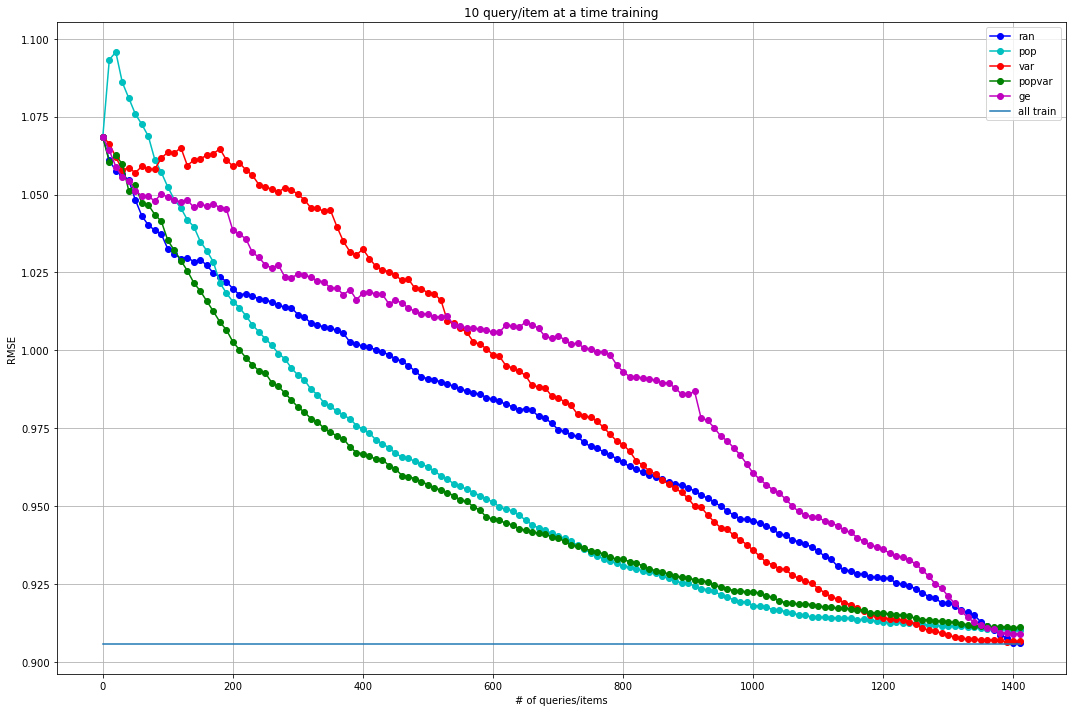

In [189]:
fig, ax = plt.subplots(figsize=(15,10))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    ax.plot(y_axis[:], results[i][1]['rmse'], m, label=results[i][0])
ax.plot(y_axis[:], [fin_acc]*len(y_axis),'-', label='all train')           
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('RMSE')
plt.title('%s query/item at a time training'%w)

plt.show()
# plt.savefig('./plots/all_methods_rmse_2core.png', dpi=300)

In [190]:
# fig, ax = plt.subplots(figsize=(15,10))
# y_axis = range(0, dataset.item_n, win)
# # y_axis = range(len(rmse_oracle_one))

# ax.plot(y_axis[:], rmse_al_p[:],'b-o', label='pop')
# ax.plot(y_axis[:], rmse_al_v[:],'c-o', label='var')
# ax.plot(y_axis[:], rmse_al_spv[:],'r-o', label='sqrt(norm pop) * v')
# ax.plot(y_axis[:], rmse_ran[:],'g-o', label='random')
# ax.plot(y_axis[:], rmse_ge[:],'m-o', label='greedy ex')
# ax.plot(y_axis[:], [fin_acc]*len(y_axis),'-', label='all train')
# # ax.plot(y_axis[:], [fin_acc_o]*len(y_axis),'-', label='oracle')
# # ax.plot(y_axis[:], rmse_oracle_one[:],'-o', label='greedy ex')

# ax.grid(True)

# legend = ax.legend(loc='best')
# plt.xlabel('# of queries/items')
# plt.ylabel('RMSE')
# plt.title('10 query/item at a time training')

# # plt.show()
# # plt.savefig('./plots/all_methods_compare_iter1_10core.png', dpi=300)

## RMSE difference

In [191]:
results[0][1].keys()

dict_keys(['rmse', 'rmse_pro', 'rmse_unpro', 'c_pro', 'c_unpro'])

In [192]:
# [a-b for a, b in zip(results[i][1]['rmse_pro'], results[i][1]['rmse_unpro'])]

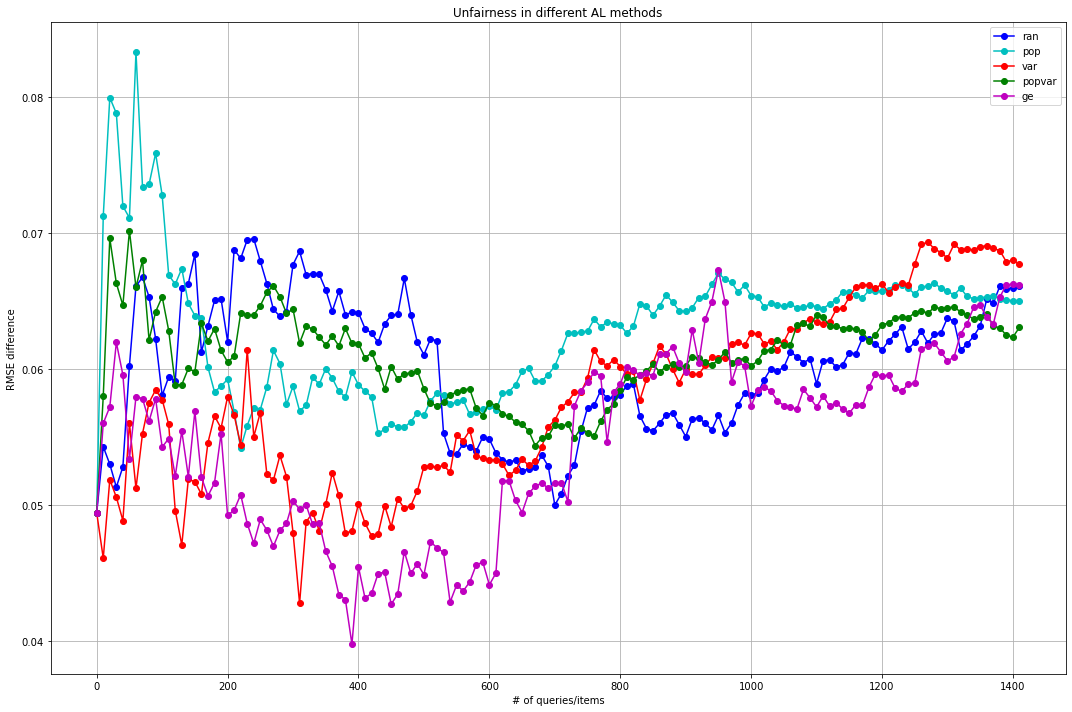

In [193]:
fig, ax = plt.subplots(figsize=(15,10))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    rmse_diff = [a-b for a, b in zip(results[i][1]['rmse_pro'], results[i][1]['rmse_unpro'])]
    ax.plot(y_axis[:], rmse_diff, m, label=results[i][0])
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('RMSE difference')
plt.title('Unfairness in different AL methods')

plt.show()
# plt.savefig('./plots/all_methods_rmse_2core.png', dpi=300)

- why does popvar work best than the others here?
    - popvar has one of the lowest RMSE and also rmse difference. 
    - women in this dataset have rated more popular items and there are many items in the long tail that are rated by men that have very little rating by women. Women and men have different tastes (need to check), then by picking high variance items and also popular items, it's more likely to include women in the selections. So, this strategy picks a more balanced set of men and women.
    - so both low RMSE, and low accuracy difference.
    - the datasets follow the powerlaw distribtuions. Are we doomed to select items from the majority groups even it is random????
    

In [194]:

# rmse_diff_p = [a-b for a, b in zip(rmse_p_pro, rmse_p_unpro )]

# rmse_diff_v = [a-b for a, b in zip(rmse_v_pro, rmse_v_unpro)]

# rmse_diff_spv = [a-b for a, b in zip(rmse_spv_pro, rmse_spv_unpro)]

# rmse_diff_ran = [a-b for a, b in zip(rmse_ran_pro, rmse_ran_unpro)]

# rmse_diff_ge = [a-b for a, b in zip(rmse_ge_pro, rmse_ge_unpro)]


# fig, ax = plt.subplots(figsize=(15,10))
# # y_axis = range(dataset.item_n)
# y_axis = range(0, dataset.item_n, win)

# ax.plot(y_axis, rmse_diff_p[:],'b-o', label='pop')
# ax.plot(y_axis, rmse_diff_v[:],'c-o', label='var')
# ax.plot(y_axis, rmse_diff_spv[:],'r-o', label='sqrt(norm pop) * v')
# ax.plot(y_axis, rmse_diff_ran[:],'g-o', label='random')
# ax.plot(y_axis, rmse_diff_ge[:],'m-o', label='greedy ex')
# ax.grid(True)

# legend = ax.legend(loc='best')
# plt.xlabel('# of queries/items')
# plt.ylabel('RMSE difference')
# plt.title('Unfairness in different AL methods')
# # plt.show()

# # plt.savefig('./plots/rmse-diff_iter1.png',dpi=300)

## The RMSE of each groups separately

In [195]:
list(zip(marker_l, range(len(results))))

[('b-o', 0), ('c-o', 1), ('r-o', 2), ('g-o', 3), ('m-o', 4)]

In [196]:
# results[i][1]['rmse_pro']

In [197]:
results[i][0]+'rmse'

'germse'

In [198]:
marker_l

['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

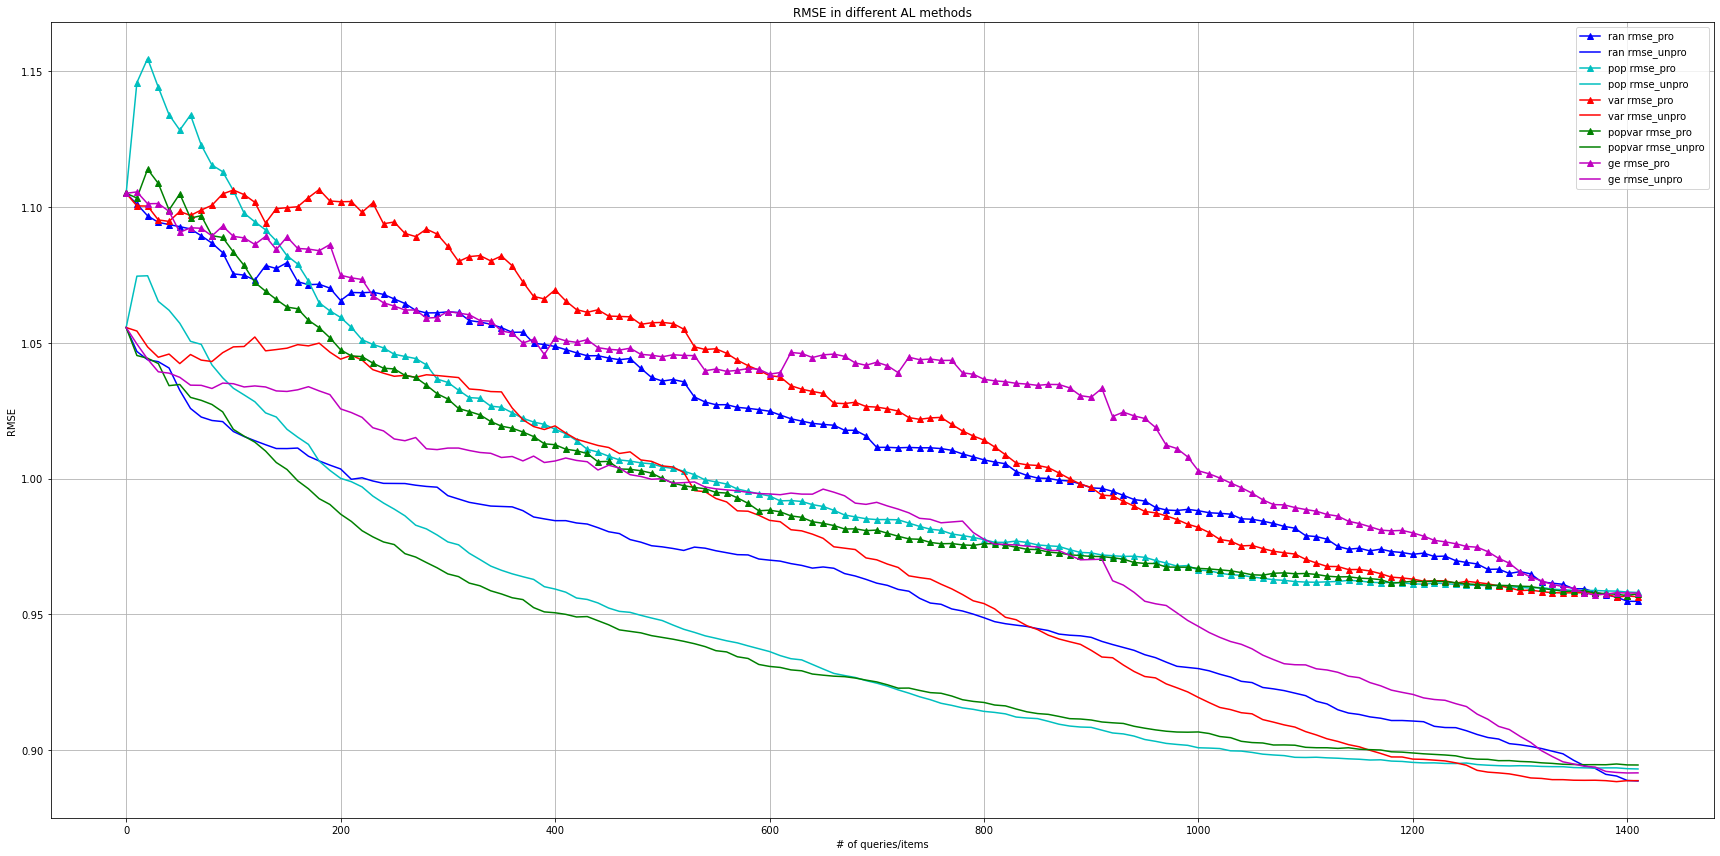

In [199]:
fig, ax = plt.subplots(figsize=(24,12))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(y_axis, results[i][1]['rmse_pro'], m+'^', label=results[i][0]+' rmse_pro')
    ax.plot(y_axis, results[i][1]['rmse_unpro'], m, label=results[i][0]+' rmse_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('RMSE')
plt.title('RMSE in different AL methods')
plt.show()
# plt.savefig('./plots/all_methods_rmse_2core.png', dpi=300)

In [200]:

# fig, ax = plt.subplots(figsize=(24,12))
# # y_axis = range(dataset.item_n)

# ax.plot(y_axis, rmse_p_pro[:],'b-^', label='pop pro')
# ax.plot(y_axis, rmse_p_unpro[:],'b-', label='pop unpro')
# ax.plot(y_axis, rmse_v_pro[:],'c-^', label='var pro')
# ax.plot(y_axis, rmse_v_unpro[:],'c-', label='var unpro')
# ax.plot(y_axis, rmse_spv_pro[:],'r-^', label='spv pro')
# ax.plot(y_axis, rmse_spv_unpro[:],'r-', label='spv unpro')
# ax.plot(y_axis, rmse_ran_pro[:],'g-^', label='random pro')
# ax.plot(y_axis, rmse_ran_unpro[:],'g-', label='random unpro')
# ax.plot(y_axis, rmse_ge_pro[:],'m-^', label='ge pro')
# ax.plot(y_axis, rmse_ge_unpro[:],'m-', label='ge unpro')

# ax.grid(True)

# legend = ax.legend(loc='best')
# plt.xlabel('# of queries/items')
# plt.ylabel('RMSE')
# plt.title('RMSE in different AL methods')
# # plt.show()

# # plt.savefig('./plots/rmse-sep-iter1.png',dpi=300)

In [201]:
# ls plots/

## The count of men and women that their info was added at each iteration

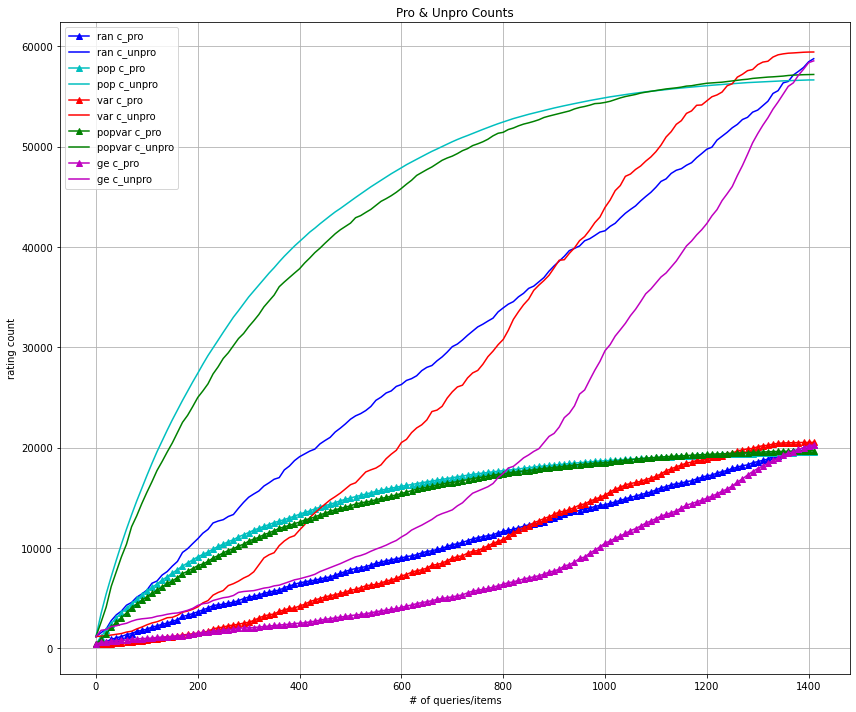

In [202]:
fig, ax = plt.subplots(figsize=(12, 10))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(y_axis, results[i][1]['c_pro'], m+'^', label=results[i][0]+' c_pro')
    ax.plot(y_axis, results[i][1]['c_unpro'], m, label=results[i][0]+' c_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('rating count')
plt.title('Pro & Unpro Counts')
plt.show()
# plt.savefig('./plots/all_methods_rmse_2core.png', dpi=300)

- this number tells us the number of ratings counts by mena dn women.
- pop and popvar both take a lot of ratings initially and then it decreases
    - maybe that is why they have lower RMSE, as they have more data for the majority
    - their RMSE for the unpro group is the lowest
    - RMSE for prot group is almost similar but popvar is slightly lower.
- var takes less ratings initially but a more equal number of men and women
    - that's why it has lower rmse
    - then it kinda grows as it doesn't have any other choice than selecting mroe data from men.
    - so we can say that controversial items with high variance rating, don't have many ratings on them in general but the number of men and women is more equal. (??? There are certain niche items that men adn women disagree on a lot.)
    
- popvar and var have small rmse differences compared to others. Var has smaller rmse difference.

In [203]:
# fig, ax = plt.subplots(figsize=(12,10))
# # y_axis = range(dataset.item_n)

# n = -1

# ax.plot(y_axis[:n], pro_c_p[:n],'b-.', label='pop pro')
# ax.plot(y_axis[:n], unpro_c_p[:n],'b', label='pop unpro')

# ax.plot(y_axis[:n], pro_c_v[:n],'c-.', label='var pro')
# ax.plot(y_axis[:n], unpro_c_v[:n],'c', label='var unpro')

# ax.plot(y_axis[:n], pro_c_spv[:n],'r-.', label='spv pro')
# ax.plot(y_axis[:n], unpro_c_spv[:n],'r', label='spv unpro')

# ax.plot(y_axis[:n], pro_c_r[:n],'g-.', label='random pro')
# ax.plot(y_axis[:n], unpro_c_r[:n],'g', label='random unpro')

# ax.plot(y_axis[:n], pro_c_ge[:n],'m-.', label='GE pro')
# ax.plot(y_axis[:n], unpro_c_ge[:n],'m', label='GE unpro')

# ax.grid(True)
# # ax.set_ylim(0, max(vu_p + vu_v + vu_spv + vu_ran))

# legend = ax.legend(loc='best')
# plt.xlabel('# of queries/items')
# plt.ylabel('Count')
# plt.title('Pro & Unpro Counts')
# # plt.show()

# # plt.savefig('./plots/pro-unpro-count-iter1.png',dpi=300)

In [204]:
## 

## Value Unfairness 

It measures the inconsistency in signed estimation error across the user types.
Value unfairness occurs when one class of user is consistently given
higher or lower predictions than their true preference

In [205]:
# fig, ax = plt.subplots(figsize=(15,10))
# # y_axis = range(dataset.item_n)
# y_axis = range(0, dataset.item_n, win)


# ax.plot(y_axis, vu_p[:],'b-o', label='pop')
# ax.plot(y_axis, vu_v[:],'c-o', label='var')
# ax.plot(y_axis, vu_spv[:],'r-o', label='sqrt(norm pop) * v')
# ax.plot(y_axis, vu_ran[:],'g-o', label='random')
# ax.plot(y_axis, vu_ge[:],'m-o', label='greedy ex')


# ax.grid(True)
# # ax.set_ylim(0, max(vu_p + vu_v + vu_spv + vu_ran))

# legend = ax.legend(loc='best')
# plt.xlabel('# of queries/items')
# plt.ylabel('Value Unfairness')
# plt.title('Value Unfairness AL methods')
# # plt.show()

# # plt.savefig('./plots/value-unfairness-iter1.png',dpi=300)

In [206]:
# print(vu_ge)

# Questions Series #1

(look at the results cumulative or not)


1. Take a look at the insurance dataset
2. calculate the probability of items being selected for
    regular recsys and also different strategies in place
    at each iteration calculate the probability ?????????????
    - Does this ratio imbalance affect being unfair?

3. Are the items with high variance the data points that are rated by women and men? find the ratio!

- What happens to the results if the ratio of the dat ais changed? 
equal men and women in the train set and test set?



- keep the ratio of pro and unpro equal in the train set, and once in the test set
- Voting algorithm!
- Do active elarning strategires increase teh RMSE gap in the? (unfairness)


- what is the average rating of men and women on these items?

- are there any items that's more rated by women than men?
    - are there items only rated by men?
    

- do women rate the popular items? or niche items? who has rated the long tail items? or the short head?
    - do the diverse rating items, popular? how much popular are they?
    
    
- women have rated 30% of the data and around 24 to 30% of each rating (1, 2, 3, ...). How would changing this percentage change the accuracy?

- does the way I split the data affect the result?

- what is the probability that a selected item is from men?

- Are popular items mostly voted by men?

- How popular are the items that have a more balanced rating?

- If we select a popular item and then choose to add a certain amount of rating from it, would the problem be solved? asking an equal number of men and women for their opinion? Would the RMSE gap decrease?

- Does RMSE gap have a correlation with the ratio of men vs women ratings? Does it have a correlation with selecting popular items or popular users?

- Are men more popular than women?

- How many users are selected each time?
    - How many men and how many women?
    - how many ratings do we have for men versus women?
    
- How many ratings from these users are selected each time?
    - how many ratings from men are collected?
    - how many ratings from women are collected?
    
- What is the accuracy each time?
    - what is the accuracy imbalance each time?
    - Is the accuracy imbalance increasing?
    (Do active learning strategies increase the RMSE gap in the? (unfairness))
    - Is the data imbalance increasing?
    - Do they have correlations?

- Let's find a subset of the dataset with the same number of ratings for each group, or with similar users (profile-wise). How would the algorithms behave?

- keep the ratio of men and women the same in the dataset and in the test set!
    - what is the ratio right now?
    - what is the ratio in the dataset?
    - what is the ratio for the recsys?
    - what is the ratio for active learning strategies?
    - In the variance-based algorithm, are the ratings that are selected from a balanced ratio of men and women?
    (Is that why its accuracy imbalance is lower?)


HYPOTHESIS: Active Learning strategies are choosing data points that are more from the popular users or items. Therefore they are creating a pseudo item / pseudo user. This pseudo-user is not a good representation of all of the users, but the majority users. We lose personalized data, but the model is dominated by the data of the majority group. Data minimization increases accuracy imbalance, meaning that we are selecting data more from men than women because it's highly probable to choose data from the majority group in reality. So, minimizing the data should still have an accuracy imbalance or make it even worse!


- Would creating a pseudo-user for each group help the data minimization in some way? Creating personas beforehand, not only getting it from the dataset. What would happen to personalization? Would summarization strategies help in data minimisation?


- Do active learning strategies pick the items to create that persona? Are they picking the same items of the same users? Is this the average user (from the majority group).
    - Create a common persona for each group (?)
    - The baseline recommender system recommonds randomly.
    - Are the recommended items the same? (do items have a similar probability of being recommended?)
        - How do we compare the items selected or recommended to users by these strategies?
        - What does a regular recsys do?
        - What does each active learning stratgy do?
        - How do the recommendations compare?
        - How do the 
    - Are popular items or items from men have higher probabilities of being selected?
    - How much are the active learning strategies item selections compare to that? Are they strengthening that persona?
    - are these strategies pick similar items? Therefore they are creating recoms for the average group, crowding the recommendations fo the manority groups. 
        - How much is this hurting the majority group poeple? The peoople with more niche interests? How much is this hurting other minority groups like women?
    - In what scenarios would this become actually harmful?
    - what is the consequence of ML recoms to users?
        - what genres are being recommended to each user group more? in the regular recsys? In the data minimized version? Are we missing the smaller preferences of users? Are we missing the minority users altogether?
        - which users are picked first? 
        - which genres are picked first?
        - which items are picked first?  (popular? from men? less diverse ratings?)
        - can we use KL-Divergence?
            - based on genres?
        - (Just a thought) - Should we create user clusters?


- Do active learning strategies actually increase the accuracy imbalance? from the beginning to the end?
    - What if the dataset is balanced? Doe, they still do that? (the pop-based ones might)
    - Can we avoid that at all? Or are we doomed to be in this way always because of issues in data collection from men and women?
    - If we select a balanced ratio of men and women/ would this issue (rmse increase) resolve? Would it stabilize? would it decrease?
    - When do they increase the accuracy imbalance?
    
    
- Is data minimization at odds with personalization? Are their goals different?
    - Do active learning strategies increase or decrease RMSE? (they claim to increase). Does it really increase?
    Or decrease personalization?????
    - Active learning methods say that they can keep the accuracy the same or even increase it. They were designed to address that issue.



# Explore

## how popular are the items that have more balanced ratings?

In [207]:
# item_f_m_cnt.head()

In [208]:
item_f_m_cnt['c'] = item_f_m_cnt['F_c']+item_f_m_cnt['M_c']
# item_f_m_cnt.head()

In [209]:
itemSortedByPop = item_f_m_cnt.sort_values(by='pop')
itemSortedByPop.head()

item_iid  F_c  M_c  F_med  F_avg  M_med  M_avg  pop  normpop  var  \
95          95  0.0  1.0    0.0    0.0    2.0    2.0    1        0  0.0   
376        376  0.0  1.0    0.0    0.0    5.0    5.0    1        0  0.0   
377        377  0.0  1.0    0.0    0.0    2.0    2.0    1        0  0.0   
1196      1196  1.0  1.0    3.0    3.0    1.0    1.0    2        0  1.0   
757        757  0.0  2.0    0.0    0.0    3.0    3.0    2        0  0.0   

      sqrt normpopvar      npop  sqrt npopvar    c  
95                  0  0.000000      0.000000  1.0  
376                 0  0.000000      0.000000  1.0  
377                 0  0.000000      0.000000  1.0  
1196                0  0.002088      0.045691  2.0  
757                 0  0.002088      0.000000  2.0

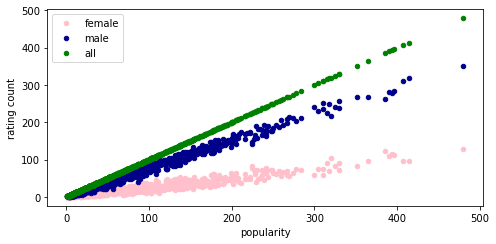

In [210]:

ax1 = itemSortedByPop.plot(kind = 'scatter', x='pop', y='F_c', c='Pink', label='female')
ax2 = itemSortedByPop.plot(kind='scatter', x='pop', y='M_c', c='DarkBlue', label='male', ax= ax1)
ax3 = itemSortedByPop.plot(kind='scatter', x='pop', y='c', c='Green', label='all', ax=ax1)

ax1.set_xlabel("popularity")
ax1.set_ylabel("rating count")
plt.show()

In [211]:
from sklearn.metrics import r2_score

print(r2_score(itemSortedByPop['pop'], itemSortedByPop['c']))
print(r2_score(itemSortedByPop['pop'], itemSortedByPop['M_c']))
print(r2_score(itemSortedByPop['pop'], itemSortedByPop['F_c']))

1.0
0.8844047937635948
0.03541932307191453


- The more popular an item is the more ratings it has. This trend is true for men, but not for women. There's a slight correlation.
- very popular items are not that many and they have more mens' ratings compared to women.
- the more popular an item gets, the less rating from women it gathers, then the accuracy difference increases.

- women's ratings have more variance

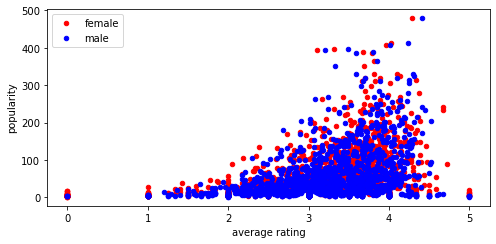

In [212]:

ax1 = itemSortedByPop.plot(kind = 'scatter', y='pop', x='F_avg', c='Red', label='female')
ax2 = itemSortedByPop.plot(kind='scatter', y='pop', x='M_avg', c='Blue', label='male', ax= ax1)
# ax3 = itemSortedByPop.plot(kind='scatter', x='pop', y='c', c='Green', label='all', ax=ax1)

ax1.set_ylabel("popularity")
ax1.set_xlabel("average rating")
plt.show()

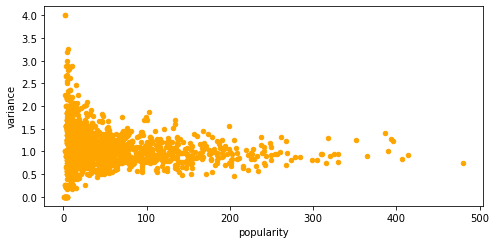

In [213]:
ax1 = itemSortedByPop.plot(kind = 'scatter', y = 'var', x='pop', c='Orange')
# ax2 = itemSortedByPop.plot(kind='scatter', y='pop', x='M_avg', c='Blue', label='male', ax= ax1)
# ax3 = itemSortedByPop.plot(kind='scatter', x='pop', y='c', c='Green', label='all', ax=ax1)

ax1.set_xlabel("popularity")
ax1.set_ylabel("variance")
plt.show()

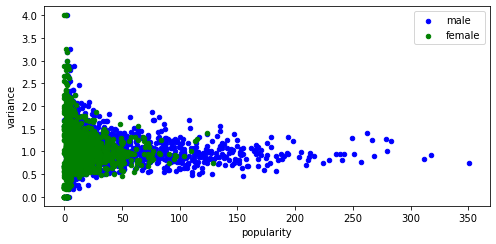

In [214]:
# ax1 = itemSortedByPop.plot(kind = 'scatter', y = 'var', x='M_c', c='Orange')
ax1 = itemSortedByPop.plot(kind='scatter', y='var', x='M_c', c='Blue', label='male')
ax2 = itemSortedByPop.plot(kind='scatter', y='var', x='F_c', c='Green', label='female', ax=ax1)

ax1.set_xlabel("popularity")
ax1.set_ylabel("variance")
plt.show()

- There are a lot of items with high popularity and very low variance.
- And the popular items have mostly male ratings.
- So, high variance items have low to medium popularity and also more balanced ratings probably.

## what if we feed the same ratio of data to the algorithm, what will happen to the accuracy?

In [215]:
# shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))
# known_df.shape

for i in shuffled_i_ran[:10]:
    print(i, )

1019
1190
1044
1323
56
1238
247
499
57
975


In [216]:
chosen_is = shuffled_i_ran[:5]
chosen_is

[1019, 1190, 1044, 1323, 56]

In [217]:
train_df[train_df['item'].isin(chosen_is)]

user  item  rating
515       5  1323     4.0
886      13    56     3.0
1428     18  1323     3.0
1682     23  1190     3.0
2635     37  1019     5.0
...     ...   ...     ...
78229   926  1323     4.0
78495   928  1190     3.0
78517   928  1323     5.0
79250   933  1190     2.0
79272   933  1323     2.0

[211 rows x 3 columns]

In [218]:
# pro_users_index

In [219]:
for a, b in train_df[train_df['item'].isin(chosen_is)].groupby('item'):
    print (a,len(b), b)
    
    p_c = b[b['user'].isin(pro_users_index)].shape[0]
    unp_c = b[~b['user'].isin(pro_users_index)].shape[0]
    
    print(p_c, unp_c)
    print(b[b['user'].isin(pro_users_index)])
    print(b[~b['user'].isin(pro_users_index)][:p_c], '\n\n')

56 26        user  item  rating
886      13    56     3.0
3926     50    56     2.0
10418   120    56     3.0
12401   143    56     2.0
13901   162    56     4.0
18680   214    56     4.0
23251   256    56     5.0
26327   291    56     2.0
26510   292    56     2.0
28658   318    56     3.0
34894   392    56     3.0
38089   435    56     2.0
39550   444    56     4.0
41671   472    56     3.0
41987   478    56     4.0
43733   497    56     3.0
44082   503    56     3.0
45744   522    56     4.0
49726   578    56     3.0
50532   591    56     4.0
56371   653    56     3.0
62061   726    56     3.0
65504   772    56     2.0
65774   774    56     3.0
68356   810    56     3.0
71376   856    56     4.0
2 24
       user  item  rating
43733   497    56     3.0
56371   653    56     3.0
      user  item  rating
886     13    56     3.0
3926    50    56     2.0 


1019 39        user  item  rating
2635     37  1019     5.0
7650     86  1019     2.0
8614     94  1019     2.0
12524   143  1019  

In [220]:
train_df[(train_df['item'].isin(chosen_is)) & (train_df['user'].isin(pro_users_index))]

user  item  rating
7002     80  1323     5.0
7650     86  1019     2.0
7758     86  1323     2.0
8131     90  1323     3.0
8260     92  1323     3.0
8614     94  1019     2.0
9583    110  1323     4.0
11435   127  1044     3.0
13181   149  1323     4.0
14936   167  1323     3.0
17568   196  1019     4.0
20433   231  1019     1.0
20501   231  1190     1.0
20826   233  1019     5.0
24268   265  1044     2.0
26090   283  1323     4.0
36010   401  1323     3.0
37823   428  1044     4.0
37845   428  1323     5.0
38812   439  1019     1.0
41007   459  1323     5.0
43733   497    56     3.0
43795   497  1044     2.0
45184   513  1323     3.0
46403   529  1323     5.0
50363   586  1323     4.0
52096   608  1019     4.0
52552   610  1323     5.0
54702   634  1323     5.0
56371   653    56     3.0
56570   653  1019     2.0
56629   653  1323     3.0
58943   691  1323     4.0
61683   721  1190     4.0
61704   721  1323     4.0
62047   725  1323     3.0
70573   842  1323     4.0
72070   861  1044     3.0
73898   877  1019     2.0
74129   879  1019     1.0
76604   902  1019     3.0
78140   926  1019     2.0
78189   926  1190     3.0
78229   926  1323     4.0

In [238]:
# rmse_ran

In [221]:
#---------------------------------------------
from tqdm import tqdm


def ac_proc(tr_df, knw_df, tes, win, srt_it, algo):
    
    pro_c = []
    unpro_c = []
    
    rmse = []
    rmse_pro = []
    rmse_unpro = []
    
#     vu = []
    
    tr_iter = pd.DataFrame(columns=['user','item','rating'])
    
    
    # number of items
    n_itm = np.unique(train_df['item']).shape[0]
    i_indx = 0

    pbar = tqdm(desc='while loop', total=n_itm+1)
    while i_indx < n_itm:

        if i_indx%100. == 0.:
            print('sample %i-th item...' %i_indx)
    

        if i_indx != 0:
            # choosing the next item to sample
            chosen_is = srt_it[i_indx:i_indx+win]
            
            
            # filtering for equal proportions
            chosen_df = tr_df[tr_df['item'].isin(chosen_is)]
            
            pro_chosen_df = chosen_df[chosen_df['user'].isin(pro_users_index)]
            
            p_c = pro_chosen_df.shape[0] # count of how many female ratings
            
            # select as many male ratings as women's ratings
            unpro_chosen_df = chosen_df[~chosen_df['user'].isin(pro_users_index)][:p_c]

            
            print(p_c, unpro_chosen_df.shape[0])
            
            
            tr_iter = pd.concat([tr_iter, 
                                pro_chosen_df,
                                unpro_chosen_df]).drop_duplicates()

            # sample based on item popularity but without replacement.
            # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
#             tr_iter = pd.concat([tr_iter, 
#                                   tr_df[tr_df['item'].isin(chosen_is)]]).drop_duplicates()
        
        else:
            tr_iter = knw_df

 
            
        # turn the data into a Surprise readbale file
        trainset_act = Dataset.load_from_df(tr_iter[['user', 'item', 'rating']], reader).build_full_trainset()


        # fitting to the model
        algo.fit(trainset_act)
        preds = algo.test(tes)

        # evaluating the outcome
        rmse.append(accuracy.rmse(preds, verbose=False))
        # rmse_al_p.append(accuracy.mae(predictions_al_p, verbose=False))


        # pro & unpro RMSE
        pro_, unpro_ = seperate_preds(preds)    
        rmse_pro.append(accuracy.rmse(pro_, verbose=False))
        rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


#         # value fairness
#         vu.append(value_unfairness(pd.DataFrame(preds)))


        # pro/unpro count
        pro_c.append(tr_iter[tr_iter['user'].isin(pro_users_index)].shape[0])
        unpro_c.append(tr_iter[~tr_iter['user'].isin(pro_users_index)].shape[0])
        
        
        
        #----------------------------------next iteration---------------------------------
        i_indx += win
        pbar.update(1)
       
    
    pbar.close()  
    return ({'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}) 
    
    


if __name__ == "__main__":

    def comp_paral (akey):
        # strtgs[akey] is the sorted list of items based on a strategy
        return(akey, ac_proc(train_df, known_df, testset, w, strtgs[akey], algo))
        # (tr_df, knw_df, tes, win, srt_it, algo)
     
    start = timeit.default_timer()
    import multiprocess as mp


    #------------------------item lists (act sorted & rand shuffled)---------------------
    # unique sorted items
    # if you use set() or np.unique(), they will disorder the list!
    sorted_i_pop = item_pop_df['item_iid'].tolist()

    # suffled list of items
    shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))

    # uncertainty - variance
    sorted_i_v = item_uc_var_df['item_iid'].tolist()

    # items order by their Sqrt(norm pop) * Var
    sorted_i_spv = item_popvar_df['item_iid'].tolist()

    # sorted based on their contribution to RMSE
    sorted_i_ge = result_df_sorted_ge['item_iid'].tolist()

    strtgs = {'ran':shuffled_i_ran, 'pop':sorted_i_pop,
              'var':sorted_i_v, 'popvar': sorted_i_spv, 'ge':sorted_i_ge}

#     strtgs = {'ran':shuffled_i_ran}
    

    
    #------------------------ test set & algo & window ---------------------
    # the known set, a part of the training set
    known_n = 0.02
    known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)
    
    
    # build the test set
    testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()
    
    
    algo = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
#     algo = SVD()

    w = 10   # window of w items
    
    
    #------------------------ function ---------------------
    pool = mp.Pool(processes=10)
    results = pool.map(comp_paral, list(strtgs.keys()))
#     results = pool.map(comp_paral, {'ran':shuffled_i_ran, 'pop':sorted_i_pop}.items())
    
    
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))


while loop:   0%|                                      | 0/1414 [00:00<?, ?it/s]

sample 0-th item...sample 0-th item...sample 0-th item...sample 0-th item...sample 0-th item...






while loop:   0%|                            | 1/1414 [00:02<1:00:48,  2.58s/it]

525

while loop:   0%|                            | 1/1414 [00:02<1:01:00,  2.59s/it]

195 525 
195


while loop:   0%|                            | 1/1414 [00:02<1:01:59,  2.63s/it]

77955 779 
55
13 13


while loop:   0%|                              | 2/1414 [00:04<52:05,  2.21s/it]

24 24


while loop:   0%|                              | 2/1414 [00:04<53:05,  2.26s/it]

157 157


while loop:   0%|                              | 2/1414 [00:04<56:59,  2.42s/it]

34 34


while loop:   0%|                            | 2/1414 [00:05<1:02:57,  2.68s/it]

489 489


while loop:   0%|                            | 2/1414 [00:05<1:07:46,  2.88s/it]

638 638


while loop:   0%|                              | 3/1414 [00:06<47:02,  2.00s/it]

27 27


while loop:   0%|                              | 3/1414 [00:06<50:11,  2.13s/it]

88 88


while loop:   0%|                              | 3/1414 [00:06<51:39,  2.20s/it]

87 87


while loop:   0%|                              | 4/1414 [00:07<44:06,  1.88s/it]

33 33


while loop:   0%|                            | 3/1414 [00:08<1:06:40,  2.83s/it]

718 718


while loop:   0%|                              | 4/1414 [00:08<49:24,  2.10s/it]

159 159


while loop:   0%|                              | 4/1414 [00:08<50:25,  2.15s/it]

30 30


while loop:   0%|                            | 3/1414 [00:09<1:15:10,  3.20s/it]

665 665


while loop:   0%|                              | 5/1414 [00:09<44:31,  1.90s/it]

30 30


while loop:   0%|                              | 5/1414 [00:11<51:55,  2.21s/it]

99 99


while loop:   0%|                              | 5/1414 [00:11<51:09,  2.18s/it]

57 57


while loop:   0%|▏                             | 6/1414 [00:11<43:02,  1.83s/it]

60 60


while loop:   0%|                            | 4/1414 [00:12<1:16:59,  3.28s/it]

477 477


while loop:   0%|▏                             | 6/1414 [00:13<51:20,  2.19s/it]

24 24


while loop:   0%|▏                             | 6/1414 [00:13<53:53,  2.30s/it]

172

while loop:   0%|▏                             | 7/1414 [00:13<43:53,  1.87s/it]

 28172 
28


while loop:   0%|                            | 4/1414 [00:13<1:27:26,  3.72s/it]

612 612


while loop:   1%|▏                             | 8/1414 [00:15<44:33,  1.90s/it]

90 90


while loop:   0%|▏                             | 7/1414 [00:15<52:09,  2.22s/it]

64 64


while loop:   0%|▏                             | 7/1414 [00:16<57:00,  2.43s/it]

191 191


while loop:   0%|                            | 5/1414 [00:17<1:30:53,  3.87s/it]

482 482


while loop:   1%|▏                             | 9/1414 [00:17<46:36,  1.99s/it]

57 57


while loop:   1%|▏                             | 8/1414 [00:17<52:52,  2.26s/it]

42 42


while loop:   1%|▏                           | 8/1414 [00:19<1:00:38,  2.59s/it]

112 112


while loop:   0%|                            | 5/1414 [00:19<1:42:43,  4.37s/it]

498 498


while loop:   1%|▏                            | 10/1414 [00:19<47:33,  2.03s/it]

sample 100-th item...
69 69


while loop:   1%|▏                             | 9/1414 [00:20<54:49,  2.34s/it]

38 38


while loop:   1%|▏                            | 11/1414 [00:22<48:39,  2.08s/it]

86 86


while loop:   1%|▏                           | 9/1414 [00:22<1:05:19,  2.79s/it]

68 68


while loop:   0%|                            | 6/1414 [00:22<1:42:23,  4.36s/it]

502 502


while loop:   1%|▏                            | 10/1414 [00:22<55:12,  2.36s/it]

sample 100-th item...
27 27


while loop:   1%|▏                            | 12/1414 [00:24<52:26,  2.24s/it]

57 57


while loop:   0%|                            | 6/1414 [00:25<1:56:46,  4.98s/it]

474 474


while loop:   1%|▏                            | 11/1414 [00:25<56:56,  2.44s/it]

26 26


while loop:   1%|▏                          | 10/1414 [00:25<1:09:00,  2.95s/it]

sample 100-th item...
147 147


while loop:   1%|▎                            | 13/1414 [00:27<54:14,  2.32s/it]

82 82


while loop:   1%|▏                            | 12/1414 [00:28<57:31,  2.46s/it]

73 73


while loop:   0%|▏                           | 7/1414 [00:28<1:56:18,  4.96s/it]

535 535


while loop:   1%|▏                          | 11/1414 [00:29<1:12:08,  3.09s/it]

162 162


while loop:   1%|▎                            | 14/1414 [00:29<55:28,  2.38s/it]

96 96


while loop:   1%|▎                            | 13/1414 [00:30<59:15,  2.54s/it]

31 31


while loop:   0%|▏                           | 7/1414 [00:32<2:09:49,  5.54s/it]

457 457


while loop:   1%|▎                            | 15/1414 [00:32<57:25,  2.46s/it]

27 27


while loop:   1%|▏                          | 12/1414 [00:32<1:16:52,  3.29s/it]

193 193


while loop:   1%|▎                            | 14/1414 [00:33<59:59,  2.57s/it]

35 35


while loop:   1%|▎                          | 16/1414 [00:35<1:00:50,  2.61s/it]

75 75


while loop:   1%|▏                           | 8/1414 [00:35<2:09:42,  5.54s/it]

368 368


while loop:   1%|▎                          | 15/1414 [00:36<1:01:06,  2.62s/it]

34 34


while loop:   1%|▏                          | 13/1414 [00:36<1:20:58,  3.47s/it]

373 373


while loop:   1%|▎                          | 17/1414 [00:38<1:02:09,  2.67s/it]

81 81


while loop:   1%|▎                          | 16/1414 [00:39<1:03:02,  2.71s/it]

24 24


while loop:   1%|▏                           | 8/1414 [00:39<2:23:17,  6.11s/it]

449 449


while loop:   1%|▎                          | 18/1414 [00:41<1:03:54,  2.75s/it]

57 57


while loop:   1%|▎                          | 14/1414 [00:41<1:27:25,  3.75s/it]

135 135


while loop:   1%|▎                          | 17/1414 [00:41<1:03:16,  2.72s/it]

52 52


while loop:   1%|▏                           | 9/1414 [00:42<2:23:37,  6.13s/it]

367 367


while loop:   1%|▎                          | 19/1414 [00:44<1:05:30,  2.82s/it]

59 59


while loop:   1%|▎                          | 18/1414 [00:44<1:04:05,  2.75s/it]

58 58


while loop:   1%|▎                          | 15/1414 [00:45<1:33:53,  4.03s/it]

107 107


while loop:   1%|▍                          | 20/1414 [00:47<1:09:28,  2.99s/it]

sample 200-th item...
72 72


while loop:   1%|▎                          | 19/1414 [00:47<1:06:05,  2.84s/it]

70 70


while loop:   1%|▏                           | 9/1414 [00:47<2:39:10,  6.80s/it]

462 462


while loop:   1%|▍                          | 21/1414 [00:50<1:10:42,  3.05s/it]

100 100


while loop:   1%|▎                          | 16/1414 [00:50<1:39:52,  4.29s/it]

170 170


while loop:   1%|▏                          | 10/1414 [00:50<2:36:14,  6.68s/it]

sample 100-th item...


while loop:   1%|▍                          | 20/1414 [00:50<1:08:30,  2.95s/it]

369 sample 200-th item...
369128
 128


while loop:   2%|▍                          | 22/1414 [00:53<1:12:45,  3.14s/it]

90 90


while loop:   1%|▍                          | 21/1414 [00:54<1:10:15,  3.03s/it]

62 62


while loop:   1%|▎                          | 17/1414 [00:55<1:44:18,  4.48s/it]

132 132


while loop:   1%|▏                          | 10/1414 [00:56<2:52:12,  7.36s/it]

sample 100-th item...
381 381


while loop:   2%|▍                          | 22/1414 [00:57<1:12:47,  3.14s/it]

35 35


while loop:   2%|▍                          | 23/1414 [00:57<1:15:50,  3.27s/it]

238 238


while loop:   1%|▏                          | 11/1414 [00:59<2:48:51,  7.22s/it]

334 334


while loop:   2%|▍                          | 23/1414 [01:00<1:14:10,  3.20s/it]

99 99


while loop:   1%|▎                          | 18/1414 [01:00<1:50:00,  4.73s/it]

87 87


while loop:   2%|▍                          | 24/1414 [01:01<1:20:32,  3.48s/it]

112 112


while loop:   2%|▍                          | 24/1414 [01:04<1:18:17,  3.38s/it]

45 45


while loop:   2%|▍                          | 25/1414 [01:05<1:25:47,  3.71s/it]

66 66


while loop:   1%|▏                          | 11/1414 [01:05<3:07:16,  8.01s/it]

355 355


while loop:   1%|▎                          | 19/1414 [01:06<1:56:26,  5.01s/it]

154 154


while loop:   2%|▍                          | 25/1414 [01:08<1:21:06,  3.50s/it]

55

while loop:   1%|▏                          | 12/1414 [01:08<3:02:08,  7.79s/it]

 55321 
321


while loop:   2%|▍                          | 26/1414 [01:09<1:28:11,  3.81s/it]

145 145


while loop:   2%|▍                          | 26/1414 [01:12<1:21:51,  3.54s/it]

40 40


while loop:   1%|▍                          | 20/1414 [01:12<2:00:58,  5.21s/it]

sample 200-th item...
97 97


while loop:   2%|▌                          | 27/1414 [01:13<1:30:51,  3.93s/it]

61 61


while loop:   1%|▏                          | 12/1414 [01:15<3:19:42,  8.55s/it]

34354  34354



while loop:   1%|▏                          | 13/1414 [01:17<3:13:02,  8.27s/it]

348 348


while loop:   1%|▍                          | 21/1414 [01:17<2:03:35,  5.32s/it]

121 121


while loop:   2%|▌                          | 28/1414 [01:18<1:34:29,  4.09s/it]

94 94


while loop:   2%|▌                          | 28/1414 [01:19<1:24:54,  3.68s/it]

97 97


while loop:   2%|▌                          | 29/1414 [01:22<1:36:48,  4.19s/it]

109 109


while loop:   2%|▌                          | 29/1414 [01:23<1:26:35,  3.75s/it]

32 32


while loop:   2%|▍                          | 22/1414 [01:23<2:06:40,  5.46s/it]

207 207


while loop:   1%|▏                          | 13/1414 [01:25<3:30:41,  9.02s/it]

405 405


while loop:   2%|▌                          | 30/1414 [01:27<1:29:12,  3.87s/it]

sample 300-th item...
20 20


while loop:   1%|▎                          | 14/1414 [01:27<3:24:30,  8.76s/it]

354 354


while loop:   2%|▌                          | 30/1414 [01:27<1:41:13,  4.39s/it]

sample 300-th item...
90 90


while loop:   2%|▍                          | 23/1414 [01:29<2:12:25,  5.71s/it]

108 108


while loop:   2%|▌                          | 31/1414 [01:31<1:29:56,  3.90s/it]

23 23


while loop:   2%|▌                          | 31/1414 [01:32<1:44:36,  4.54s/it]

190 190


while loop:   2%|▌                          | 32/1414 [01:35<1:32:19,  4.01s/it]

48 48


while loop:   2%|▍                          | 24/1414 [01:36<2:17:45,  5.95s/it]

98 98


while loop:   1%|▎                          | 14/1414 [01:36<3:44:01,  9.60s/it]

351 351


while loop:   2%|▌                          | 32/1414 [01:37<1:48:17,  4.70s/it]

250 250


while loop:   1%|▎                          | 15/1414 [01:37<3:35:05,  9.22s/it]

239 239


while loop:   2%|▋                          | 33/1414 [01:39<1:32:34,  4.02s/it]

59 59


while loop:   2%|▍                          | 25/1414 [01:42<2:20:12,  6.06s/it]

139 139


while loop:   2%|▋                          | 33/1414 [01:43<1:52:31,  4.89s/it]

205 205


while loop:   2%|▋                          | 34/1414 [01:44<1:33:33,  4.07s/it]

40 40


while loop:   1%|▎                          | 15/1414 [01:47<3:55:29, 10.10s/it]

350 350


while loop:   2%|▋                          | 35/1414 [01:48<1:36:27,  4.20s/it]

58 58


while loop:   1%|▎                          | 16/1414 [01:48<3:45:37,  9.68s/it]

350 350


while loop:   2%|▋                          | 34/1414 [01:48<1:58:30,  5.15s/it]

118 118


while loop:   2%|▍                          | 26/1414 [01:49<2:24:10,  6.23s/it]

153 153


while loop:   3%|▋                          | 36/1414 [01:52<1:37:07,  4.23s/it]

45 45


while loop:   2%|▋                          | 35/1414 [01:54<2:04:04,  5.40s/it]

79 79


while loop:   2%|▌                          | 27/1414 [01:56<2:27:46,  6.39s/it]

68 68


while loop:   3%|▋                          | 37/1414 [01:57<1:38:25,  4.29s/it]

51 51


while loop:   1%|▎                          | 17/1414 [01:59<3:55:27, 10.11s/it]

392 392


while loop:   1%|▎                          | 16/1414 [01:59<4:07:54, 10.64s/it]

374 374


while loop:   3%|▋                          | 36/1414 [02:00<2:07:46,  5.56s/it]

273 273


while loop:   3%|▋                          | 38/1414 [02:01<1:39:27,  4.34s/it]

37 37


while loop:   2%|▌                          | 28/1414 [02:03<2:32:40,  6.61s/it]

157 157


while loop:   3%|▋                          | 39/1414 [02:06<1:43:32,  4.52s/it]

64 64


while loop:   3%|▋                          | 37/1414 [02:07<2:14:38,  5.87s/it]

155 155


while loop:   2%|▌                          | 29/1414 [02:10<2:37:46,  6.83s/it]

52 52


while loop:   3%|▊                          | 40/1414 [02:11<1:44:07,  4.55s/it]

sample 400-th item...
34 34


while loop:   1%|▎                          | 18/1414 [02:11<4:07:45, 10.65s/it]

241 241


while loop:   1%|▎                          | 17/1414 [02:12<4:20:27, 11.19s/it]

337 337


while loop:   3%|▋                          | 38/1414 [02:14<2:20:33,  6.13s/it]

143 143


while loop:   3%|▊                          | 41/1414 [02:16<1:47:28,  4.70s/it]

44 44


while loop:   2%|▌                          | 30/1414 [02:18<2:42:42,  7.05s/it]

sample 300-th item...
159 159


while loop:   3%|▋                          | 39/1414 [02:21<2:26:51,  6.41s/it]

45 45


while loop:   3%|▊                          | 42/1414 [02:21<1:47:30,  4.70s/it]

95 95


while loop:   1%|▎                          | 19/1414 [02:24<4:19:22, 11.16s/it]

279 279


while loop:   1%|▎                          | 18/1414 [02:25<4:36:22, 11.88s/it]

341 341


while loop:   2%|▌                          | 31/1414 [02:26<2:48:15,  7.30s/it]

274 274


while loop:   3%|▊                          | 43/1414 [02:26<1:54:00,  4.99s/it]

64 64


while loop:   3%|▊                          | 40/1414 [02:28<2:33:32,  6.70s/it]

sample 400-th item...
210 210


while loop:   3%|▊                          | 44/1414 [02:31<1:54:30,  5.02s/it]

115 115


while loop:   2%|▌                          | 32/1414 [02:34<2:55:36,  7.62s/it]

165 165


while loop:   3%|▊                          | 41/1414 [02:35<2:38:20,  6.92s/it]

163 163


while loop:   3%|▊                          | 45/1414 [02:37<1:56:05,  5.09s/it]

87 87


while loop:   1%|▍                          | 20/1414 [02:37<4:35:35, 11.86s/it]

sample 200-th item...
294 294


while loop:   1%|▎                          | 19/1414 [02:39<4:48:43, 12.42s/it]

307 307


while loop:   3%|▉                          | 46/1414 [02:42<1:56:28,  5.11s/it]

60 60


while loop:   2%|▋                          | 33/1414 [02:42<2:58:13,  7.74s/it]

160 160


while loop:   3%|▊                          | 42/1414 [02:43<2:40:43,  7.03s/it]

273 273


while loop:   3%|▉                          | 47/1414 [02:47<1:58:45,  5.21s/it]

86 86


while loop:   1%|▍                          | 21/1414 [02:50<4:40:47, 12.09s/it]

174 174


while loop:   2%|▋                          | 34/1414 [02:50<3:01:07,  7.88s/it]

78 78


while loop:   3%|▊                          | 43/1414 [02:51<2:46:56,  7.31s/it]

168 168


while loop:   3%|▉                          | 48/1414 [02:53<2:00:39,  5.30s/it]

70 70


while loop:   1%|▍                          | 20/1414 [02:53<4:59:02, 12.87s/it]

sample 200-th item...
306 306


while loop:   3%|▉                          | 49/1414 [02:58<2:01:59,  5.36s/it]

79 79


while loop:   3%|▊                          | 44/1414 [02:59<2:51:37,  7.52s/it]

148 148


while loop:   2%|▋                          | 35/1414 [02:59<3:06:28,  8.11s/it]

227 227


while loop:   2%|▍                          | 22/1414 [03:03<4:47:54, 12.41s/it]

254 254


while loop:   4%|▉                          | 50/1414 [03:04<2:04:08,  5.46s/it]

sample 500-th item...
75 75


while loop:   3%|▊                          | 45/1414 [03:07<2:56:43,  7.75s/it]

163 163


while loop:   1%|▍                          | 21/1414 [03:07<5:07:20, 13.24s/it]

244 244


while loop:   3%|▋                          | 36/1414 [03:08<3:11:15,  8.33s/it]

92 92


while loop:   4%|▉                          | 51/1414 [03:10<2:07:15,  5.60s/it]

71 71


while loop:   3%|▉                          | 46/1414 [03:15<3:01:33,  7.96s/it]

112 112


while loop:   4%|▉                          | 52/1414 [03:16<2:09:35,  5.71s/it]

45 45


while loop:   2%|▍                          | 23/1414 [03:16<4:55:59, 12.77s/it]

354 354


while loop:   3%|▋                          | 37/1414 [03:17<3:15:09,  8.50s/it]

135 135


while loop:   2%|▍                          | 22/1414 [03:22<5:18:30, 13.73s/it]

239 239


while loop:   4%|█                          | 53/1414 [03:22<2:13:47,  5.90s/it]

75 75


while loop:   3%|▉                          | 47/1414 [03:25<3:09:51,  8.33s/it]

107 107


while loop:   3%|▋                          | 38/1414 [03:26<3:21:20,  8.78s/it]

66 66


while loop:   4%|█                          | 54/1414 [03:28<2:15:56,  6.00s/it]

101 101


while loop:   2%|▍                          | 24/1414 [03:31<5:07:22, 13.27s/it]

248 248


while loop:   3%|▉                          | 48/1414 [03:33<3:13:17,  8.49s/it]

131 131


while loop:   4%|█                          | 55/1414 [03:35<2:18:11,  6.10s/it]

104 104


while loop:   3%|▋                          | 39/1414 [03:36<3:26:22,  9.01s/it]

307 307


while loop:   2%|▍                          | 23/1414 [03:37<5:26:23, 14.08s/it]

302 302


while loop:   4%|█                          | 56/1414 [03:41<2:19:42,  6.17s/it]

87 87


while loop:   3%|▉                          | 49/1414 [03:42<3:16:41,  8.65s/it]

144 144


while loop:   3%|▊                          | 40/1414 [03:45<3:29:57,  9.17s/it]

sample 400-th item...
187 187


while loop:   2%|▍                          | 25/1414 [03:45<5:15:23, 13.62s/it]

267 267


while loop:   4%|█                          | 57/1414 [03:47<2:20:57,  6.23s/it]

76 76


while loop:   4%|▉                          | 50/1414 [03:52<3:21:19,  8.86s/it]

sample 500-th item...
189 189


while loop:   2%|▍                          | 24/1414 [03:52<5:35:47, 14.49s/it]

258 258


while loop:   4%|█                          | 58/1414 [03:54<2:25:13,  6.43s/it]

83 83


while loop:   3%|▊                          | 41/1414 [03:55<3:35:41,  9.43s/it]

109 109


while loop:   2%|▍                          | 26/1414 [04:00<5:23:38, 13.99s/it]

242 242


while loop:   4%|█▏                         | 59/1414 [04:01<2:27:02,  6.51s/it]

85 85


while loop:   4%|▉                          | 51/1414 [04:01<3:25:29,  9.05s/it]

88 88


while loop:   3%|▊                          | 42/1414 [04:05<3:40:24,  9.64s/it]

154 154


while loop:   4%|█▏                         | 60/1414 [04:08<2:29:35,  6.63s/it]

244sample 600-th item...
 244
105 105


while loop:   4%|▉                          | 52/1414 [04:11<3:29:05,  9.21s/it]

161 161


while loop:   4%|█▏                         | 61/1414 [04:15<2:34:39,  6.86s/it]

146 146


while loop:   2%|▌                          | 27/1414 [04:16<5:34:18, 14.46s/it]

182 182


while loop:   3%|▊                          | 43/1414 [04:16<3:49:19, 10.04s/it]

148 148


while loop:   4%|█                          | 53/1414 [04:21<3:37:50,  9.60s/it]

192 192


while loop:   4%|█▏                         | 62/1414 [04:23<2:39:53,  7.10s/it]

99 99


while loop:   2%|▍                          | 26/1414 [04:25<5:56:09, 15.40s/it]

246 246


while loop:   3%|▊                          | 44/1414 [04:27<3:57:16, 10.39s/it]

116 116


while loop:   4%|█▏                         | 63/1414 [04:31<2:44:21,  7.30s/it]

145 145


while loop:   2%|▌                          | 28/1414 [04:32<5:46:13, 14.99s/it]

263 263


while loop:   4%|█                          | 54/1414 [04:32<3:45:00,  9.93s/it]

76 76


while loop:   3%|▊                          | 45/1414 [04:38<4:00:14, 10.53s/it]

119 119


while loop:   5%|█▏                         | 64/1414 [04:38<2:46:36,  7.40s/it]

106 106


while loop:   2%|▌                          | 27/1414 [04:42<6:08:28, 15.94s/it]

204 204


while loop:   4%|█                          | 55/1414 [04:44<3:56:59, 10.46s/it]

71 71


while loop:   5%|█▏                         | 65/1414 [04:49<3:06:52,  8.31s/it]

87 87


while loop:   2%|▌                          | 29/1414 [04:50<6:09:41, 16.02s/it]

198 198


while loop:   3%|▉                          | 46/1414 [04:52<4:20:15, 11.41s/it]

70 70


while loop:   4%|█                          | 56/1414 [04:55<4:03:55, 10.78s/it]

123 123


while loop:   5%|█▎                         | 66/1414 [04:57<3:04:18,  8.20s/it]

105 105


while loop:   2%|▌                          | 28/1414 [05:01<6:31:43, 16.96s/it]

282 282


while loop:   3%|▉                          | 47/1414 [05:03<4:19:33, 11.39s/it]

142 142


while loop:   5%|█▎                         | 67/1414 [05:05<3:04:07,  8.20s/it]

132 132


while loop:   4%|█                          | 57/1414 [05:06<4:04:27, 10.81s/it]

216 216


while loop:   2%|▌                          | 30/1414 [05:07<6:12:02, 16.13s/it]

sample 300-th item...
306 306


while loop:   5%|█▎                         | 68/1414 [05:13<3:05:01,  8.25s/it]

97 97


while loop:   3%|▉                          | 48/1414 [05:15<4:19:37, 11.40s/it]

139 139


while loop:   4%|█                          | 58/1414 [05:17<4:05:27, 10.86s/it]

109 109


while loop:   2%|▌                          | 29/1414 [05:18<6:33:56, 17.07s/it]

225 225


while loop:   5%|█▎                         | 69/1414 [05:22<3:06:58,  8.34s/it]

82 82


while loop:   2%|▌                          | 31/1414 [05:24<6:16:04, 16.32s/it]

218 218


while loop:   3%|▉                          | 49/1414 [05:26<4:19:23, 11.40s/it]

134 134


while loop:   4%|█▏                         | 59/1414 [05:28<4:08:09, 10.99s/it]

162 162


while loop:   5%|█▎                         | 70/1414 [05:31<3:09:43,  8.47s/it]

sample 700-th item...
82 82


while loop:   2%|▌                          | 30/1414 [05:36<6:39:23, 17.31s/it]

sample 300-th item...
220 220


while loop:   4%|▉                          | 50/1414 [05:38<4:23:18, 11.58s/it]

sample 500-th item...
163 163


while loop:   5%|█▎                         | 71/1414 [05:39<3:11:18,  8.55s/it]

101 101


while loop:   4%|█▏                         | 60/1414 [05:40<4:11:04, 11.13s/it]

sample 600-th item...
242 242


while loop:   2%|▌                          | 32/1414 [05:41<6:22:24, 16.60s/it]

177 177


while loop:   5%|█▎                         | 72/1414 [05:48<3:13:26,  8.65s/it]

105 105


while loop:   4%|▉                          | 51/1414 [05:50<4:28:12, 11.81s/it]

118 118


while loop:   4%|█▏                         | 61/1414 [05:52<4:15:18, 11.32s/it]

148 148


while loop:   2%|▌                          | 31/1414 [05:54<6:44:15, 17.54s/it]

248 248


while loop:   5%|█▍                         | 73/1414 [05:57<3:16:31,  8.79s/it]

209 209


while loop:   2%|▋                          | 33/1414 [05:58<6:26:27, 16.79s/it]

280 280


while loop:   4%|▉                          | 52/1414 [06:02<4:28:19, 11.82s/it]

94 94


while loop:   4%|█▏                         | 62/1414 [06:04<4:19:10, 11.50s/it]

237 237


while loop:   5%|█▍                         | 74/1414 [06:07<3:18:41,  8.90s/it]

170 170


while loop:   2%|▌                          | 32/1414 [06:13<6:50:53, 17.84s/it]

193 193


while loop:   4%|█                          | 53/1414 [06:14<4:31:35, 11.97s/it]

133 133


while loop:   2%|▋                          | 34/1414 [06:16<6:31:40, 17.03s/it]

170 170


while loop:   4%|█▏                         | 63/1414 [06:16<4:23:36, 11.71s/it]

141 141


while loop:   5%|█▍                         | 75/1414 [06:16<3:23:05,  9.10s/it]

93 93


while loop:   5%|█▍                         | 76/1414 [06:26<3:28:37,  9.36s/it]

94 94


while loop:   4%|█                          | 54/1414 [06:27<4:36:33, 12.20s/it]

213 213


while loop:   5%|█▏                         | 64/1414 [06:29<4:30:35, 12.03s/it]

102 102


while loop:   2%|▋                          | 33/1414 [06:32<6:57:31, 18.14s/it]

195 195


while loop:   2%|▋                          | 35/1414 [06:34<6:42:40, 17.52s/it]

227 227


while loop:   5%|█▍                         | 77/1414 [06:36<3:34:39,  9.63s/it]

88 88


while loop:   4%|█                          | 55/1414 [06:40<4:42:42, 12.48s/it]

168 168


while loop:   5%|█▏                         | 65/1414 [06:41<4:35:59, 12.28s/it]

169 169


while loop:   6%|█▍                         | 78/1414 [06:46<3:34:31,  9.63s/it]

135 135


while loop:   2%|▋                          | 34/1414 [06:50<7:00:32, 18.28s/it]

178 178


while loop:   3%|▋                          | 36/1414 [06:52<6:44:43, 17.62s/it]

235 235


while loop:   4%|█                          | 56/1414 [06:53<4:44:29, 12.57s/it]

137 137


while loop:   5%|█▎                         | 66/1414 [06:54<4:37:48, 12.36s/it]

301 301


while loop:   6%|█▌                         | 79/1414 [06:56<3:36:39,  9.74s/it]

141 141


while loop:   4%|█                          | 57/1414 [07:06<4:46:42, 12.68s/it]

120 120


while loop:   6%|█▌                         | 80/1414 [07:06<3:39:03,  9.85s/it]

sample 800-th item...
158 158


while loop:   5%|█▎                         | 67/1414 [07:07<4:42:01, 12.56s/it]

68 68


while loop:   2%|▋                          | 35/1414 [07:09<7:04:15, 18.46s/it]

207 207


while loop:   3%|▋                          | 37/1414 [07:10<6:47:58, 17.78s/it]

163 163


while loop:   6%|█▌                         | 81/1414 [07:18<3:50:34, 10.38s/it]

155 155


while loop:   4%|█                          | 58/1414 [07:21<4:59:46, 13.26s/it]

137 137


while loop:   5%|█▎                         | 68/1414 [07:21<4:54:26, 13.13s/it]

138 138


while loop:   6%|█▌                         | 82/1414 [07:29<3:57:38, 10.70s/it]

79 79


while loop:   3%|▋                          | 36/1414 [07:30<7:22:48, 19.28s/it]

142 142


while loop:   3%|▋                          | 38/1414 [07:31<7:06:09, 18.58s/it]

136 136


while loop:   4%|█▏                         | 59/1414 [07:35<5:05:47, 13.54s/it]

120 120


while loop:   5%|█▎                         | 69/1414 [07:36<5:02:24, 13.49s/it]

256 256


while loop:   6%|█▌                         | 83/1414 [07:40<3:57:48, 10.72s/it]

152 152


while loop:   4%|█▏                         | 60/1414 [07:48<5:04:07, 13.48s/it]

sample 600-th item...
243 243


while loop:   5%|█▎                         | 70/1414 [07:49<5:02:11, 13.49s/it]

sample 700-th item...
232 232


while loop:   3%|▋                          | 39/1414 [07:50<7:07:23, 18.65s/it]

187 187


while loop:   3%|▋                          | 37/1414 [07:50<7:21:51, 19.25s/it]

157 157


while loop:   6%|█▌                         | 84/1414 [07:51<3:59:23, 10.80s/it]

153 153


while loop:   6%|█▌                         | 85/1414 [08:02<4:01:18, 10.89s/it]

96 96


while loop:   4%|█▏                         | 61/1414 [08:02<5:07:05, 13.62s/it]

237 237


while loop:   5%|█▎                         | 71/1414 [08:03<5:06:03, 13.67s/it]

186 186


while loop:   3%|▊                          | 40/1414 [08:09<7:09:50, 18.77s/it]

sample 400-th item...
159 159


while loop:   3%|▋                          | 38/1414 [08:09<7:24:19, 19.37s/it]

183 183


while loop:   6%|█▋                         | 86/1414 [08:13<4:04:32, 11.05s/it]

121 121


while loop:   4%|█▏                         | 62/1414 [08:17<5:12:29, 13.87s/it]

103 103


while loop:   5%|█▎                         | 72/1414 [08:18<5:09:56, 13.86s/it]

63 63


while loop:   6%|█▋                         | 87/1414 [08:24<4:04:40, 11.06s/it]

104 104


while loop:   3%|▊                          | 41/1414 [08:28<7:16:25, 19.07s/it]

205 205


while loop:   3%|▋                          | 39/1414 [08:30<7:30:45, 19.67s/it]

176 176


while loop:   4%|█▏                         | 63/1414 [08:31<5:17:29, 14.10s/it]

109 109


while loop:   5%|█▍                         | 73/1414 [08:33<5:17:31, 14.21s/it]

292 292


while loop:   6%|█▋                         | 88/1414 [08:37<4:14:53, 11.53s/it]

162 162


while loop:   5%|█▏                         | 64/1414 [08:46<5:19:29, 14.20s/it]

137 137


while loop:   5%|█▍                         | 74/1414 [08:47<5:19:54, 14.32s/it]

178 178


while loop:   3%|▊                          | 42/1414 [08:48<7:17:35, 19.14s/it]

144 144


while loop:   6%|█▋                         | 89/1414 [08:49<4:13:43, 11.49s/it]

217 217


while loop:   3%|▊                          | 40/1414 [08:49<7:30:39, 19.68s/it]

sample 400-th item...
197 197


while loop:   5%|█▏                         | 65/1414 [09:00<5:20:18, 14.25s/it]

140 140


while loop:   6%|█▋                         | 90/1414 [09:00<4:16:08, 11.61s/it]

sample 900-th item...
104 104


while loop:   5%|█▍                         | 75/1414 [09:02<5:22:16, 14.44s/it]

78 78


while loop:   3%|▊                          | 43/1414 [09:07<7:21:14, 19.31s/it]

170 170


while loop:   3%|▊                          | 41/1414 [09:10<7:33:21, 19.81s/it]

178 178


while loop:   6%|█▋                         | 91/1414 [09:13<4:19:52, 11.79s/it]

191 191


while loop:   5%|█▎                         | 66/1414 [09:15<5:27:03, 14.56s/it]

127 127


while loop:   5%|█▍                         | 76/1414 [09:18<5:29:15, 14.77s/it]

229 229


while loop:   7%|█▊                         | 92/1414 [09:25<4:26:58, 12.12s/it]

317 317


while loop:   3%|▊                          | 44/1414 [09:27<7:24:23, 19.46s/it]

196 196


while loop:   5%|█▎                         | 67/1414 [09:30<5:28:27, 14.63s/it]

186 186


while loop:   3%|▊                          | 42/1414 [09:30<7:38:57, 20.07s/it]

152 152


while loop:   5%|█▍                         | 77/1414 [09:33<5:32:12, 14.91s/it]

245 245


while loop:   7%|█▊                         | 93/1414 [09:38<4:31:46, 12.34s/it]

145 145


while loop:   5%|█▎                         | 68/1414 [09:45<5:31:24, 14.77s/it]

66 66


while loop:   3%|▊                          | 45/1414 [09:47<7:26:43, 19.58s/it]

180 180


while loop:   6%|█▍                         | 78/1414 [09:48<5:36:35, 15.12s/it]

254 254


while loop:   3%|▊                          | 43/1414 [09:51<7:42:29, 20.24s/it]

208 208


while loop:   7%|█▊                         | 94/1414 [09:51<4:35:26, 12.52s/it]

244 244


while loop:   5%|█▎                         | 69/1414 [10:01<5:35:39, 14.97s/it]

89 89


while loop:   6%|█▌                         | 79/1414 [10:05<5:43:55, 15.46s/it]

190 190


while loop:   7%|█▊                         | 95/1414 [10:05<4:42:01, 12.83s/it]

382 382


while loop:   3%|▉                          | 46/1414 [10:07<7:31:42, 19.81s/it]

190 190


while loop:   3%|▊                          | 44/1414 [10:12<7:45:55, 20.41s/it]

154 154


while loop:   5%|█▎                         | 70/1414 [10:16<5:39:06, 15.14s/it]

sample 700-th item...
185 185


while loop:   7%|█▊                         | 96/1414 [10:19<4:49:24, 13.17s/it]

143 143


while loop:   6%|█▌                         | 80/1414 [10:21<5:47:31, 15.63s/it]

sample 800-th item...
204 204


while loop:   3%|▉                          | 47/1414 [10:29<7:43:47, 20.36s/it]

158 158


while loop:   5%|█▎                         | 71/1414 [10:33<5:48:56, 15.59s/it]

105 105


while loop:   3%|▊                          | 45/1414 [10:34<7:57:53, 20.94s/it]

165 165


while loop:   7%|█▊                         | 97/1414 [10:34<5:03:21, 13.82s/it]

382 382


while loop:   6%|█▌                         | 81/1414 [10:39<6:04:23, 16.40s/it]

352 352


while loop:   5%|█▎                         | 72/1414 [10:49<5:51:18, 15.71s/it]

127 127


while loop:   7%|█▊                         | 98/1414 [10:49<5:08:36, 14.07s/it]

319 319


while loop:   3%|▉                          | 48/1414 [10:50<7:46:09, 20.48s/it]

137 137


while loop:   3%|▉                          | 46/1414 [10:55<7:59:15, 21.02s/it]

157 157


while loop:   6%|█▌                         | 82/1414 [10:56<6:07:25, 16.55s/it]

309 309


while loop:   7%|█▉                         | 99/1414 [11:04<5:16:46, 14.45s/it]

335 335


while loop:   5%|█▍                         | 73/1414 [11:05<5:54:00, 15.84s/it]

119 119


while loop:   3%|▉                          | 49/1414 [11:11<7:48:37, 20.60s/it]

147 147


while loop:   6%|█▌                         | 83/1414 [11:13<6:12:14, 16.78s/it]

305 305


while loop:   3%|▉                          | 47/1414 [11:17<8:03:13, 21.21s/it]

154 154


while loop:   7%|█▊                        | 100/1414 [11:20<5:22:49, 14.74s/it]

sample 1000-th item...
368 368


while loop:   5%|█▍                         | 74/1414 [11:21<5:55:44, 15.93s/it]

66 66


while loop:   6%|█▌                         | 84/1414 [11:31<6:19:45, 17.13s/it]

236 236


while loop:   4%|▉                          | 50/1414 [11:32<7:52:18, 20.78s/it]

sample 500-th item...
120 120


while loop:   7%|█▊                        | 101/1414 [11:36<5:30:56, 15.12s/it]

218 218


while loop:   5%|█▍                         | 75/1414 [11:37<5:58:18, 16.06s/it]

93 93


while loop:   3%|▉                          | 48/1414 [11:38<8:05:50, 21.34s/it]

192 192


while loop:   6%|█▌                         | 85/1414 [11:49<6:26:37, 17.45s/it]

198 198


while loop:   7%|█▉                        | 102/1414 [11:52<5:37:32, 15.44s/it]

279 279


while loop:   4%|▉                          | 51/1414 [11:53<7:53:27, 20.84s/it]

179 179


while loop:   5%|█▍                         | 76/1414 [11:53<5:57:38, 16.04s/it]

146 146


while loop:   3%|▉                          | 49/1414 [12:00<8:08:12, 21.46s/it]

148 148


while loop:   6%|█▋                         | 86/1414 [12:08<6:32:35, 17.74s/it]

305 305


while loop:   7%|█▉                        | 103/1414 [12:09<5:47:02, 15.88s/it]

225 225


while loop:   5%|█▍                         | 77/1414 [12:10<6:02:18, 16.26s/it]

140 140


while loop:   4%|▉                          | 52/1414 [12:14<7:56:34, 20.99s/it]

113 113


while loop:   4%|▉                          | 50/1414 [12:23<8:15:13, 21.78s/it]

sample 500-th item...
142 142


while loop:   7%|█▉                        | 104/1414 [12:27<6:00:43, 16.52s/it]

266 266


while loop:   6%|█▋                         | 87/1414 [12:27<6:45:51, 18.35s/it]

184 184


while loop:   6%|█▍                         | 78/1414 [12:28<6:11:52, 16.70s/it]

160 160


while loop:   4%|█                          | 53/1414 [12:37<8:10:13, 21.61s/it]

93 93


while loop:   7%|█▉                        | 105/1414 [12:44<6:08:29, 16.89s/it]

277 277


while loop:   6%|█▌                         | 79/1414 [12:45<6:16:06, 16.90s/it]

189 189


while loop:   4%|▉                          | 51/1414 [12:46<8:24:35, 22.21s/it]

131 131


while loop:   6%|█▋                         | 88/1414 [12:47<6:52:22, 18.66s/it]

227 227


while loop:   4%|█                          | 54/1414 [12:59<8:10:08, 21.62s/it]

84 84


while loop:   7%|█▉                        | 106/1414 [13:02<6:13:18, 17.12s/it]

212 212


while loop:   6%|█▌                         | 80/1414 [13:02<6:17:34, 16.98s/it]

sample 800-th item...
150 150


while loop:   6%|█▋                         | 89/1414 [13:06<6:57:40, 18.91s/it]

190 190


while loop:   4%|▉                          | 52/1414 [13:08<8:24:35, 22.23s/it]

134 134


while loop:   6%|█▌                         | 81/1414 [13:20<6:21:55, 17.19s/it]

254 254


while loop:   8%|█▉                        | 107/1414 [13:21<6:21:45, 17.53s/it]

265 265


while loop:   4%|█                          | 55/1414 [13:21<8:11:00, 21.68s/it]

143 143


while loop:   6%|█▋                         | 90/1414 [13:26<7:02:46, 19.16s/it]

sample 900-th item...
233 233


while loop:   4%|█                          | 53/1414 [13:31<8:26:25, 22.33s/it]

127 127


while loop:   6%|█▌                         | 82/1414 [13:38<6:25:25, 17.36s/it]

249 249


while loop:   8%|█▉                        | 108/1414 [13:39<6:27:29, 17.80s/it]

289 289


while loop:   4%|█                          | 56/1414 [13:43<8:12:39, 21.77s/it]

134 134


while loop:   6%|█▋                         | 91/1414 [13:46<7:07:25, 19.38s/it]

281 281


while loop:   4%|█                          | 54/1414 [13:53<8:29:01, 22.46s/it]

130 130


while loop:   6%|█▌                         | 83/1414 [13:56<6:29:07, 17.54s/it]

199 199


while loop:   8%|██                        | 109/1414 [13:58<6:33:29, 18.09s/it]

222 222


while loop:   4%|█                          | 57/1414 [14:05<8:15:08, 21.89s/it]

104 104


while loop:   7%|█▊                         | 92/1414 [14:06<7:14:52, 19.74s/it]

33 33


while loop:   6%|█▌                         | 84/1414 [14:14<6:33:24, 17.75s/it]

114 114


while loop:   4%|█                          | 55/1414 [14:17<8:35:02, 22.74s/it]

142 142


while loop:   8%|██                        | 110/1414 [14:17<6:42:38, 18.53s/it]

sample 1100-th item...
238 238


while loop:   7%|█▊                         | 93/1414 [14:28<7:24:05, 20.17s/it]

201 201


while loop:   4%|█                          | 58/1414 [14:28<8:24:22, 22.32s/it]

126 126


while loop:   6%|█▌                         | 85/1414 [14:34<6:46:18, 18.34s/it]

195 195


while loop:   8%|██                        | 111/1414 [14:38<6:53:36, 19.05s/it]

259 259


while loop:   4%|█                          | 56/1414 [14:41<8:41:39, 23.05s/it]

115 115


while loop:   7%|█▊                         | 94/1414 [14:48<7:27:50, 20.36s/it]

185 185


while loop:   4%|█▏                         | 59/1414 [14:51<8:26:45, 22.44s/it]

137 137


while loop:   6%|█▋                         | 86/1414 [14:53<6:49:40, 18.51s/it]

162 162


while loop:   8%|██                        | 112/1414 [14:58<6:59:13, 19.32s/it]

164 164


while loop:   4%|█                          | 57/1414 [15:04<8:43:14, 23.14s/it]

113 113


while loop:   7%|█▊                         | 95/1414 [15:10<7:33:03, 20.61s/it]

266 266


while loop:   6%|█▋                         | 87/1414 [15:12<6:52:50, 18.67s/it]

100 100


while loop:   4%|█▏                         | 60/1414 [15:13<8:27:12, 22.48s/it]

sample 600-th item...
146 146


while loop:   8%|██                        | 113/1414 [15:17<7:02:49, 19.50s/it]

178 178


while loop:   4%|█                          | 58/1414 [15:28<8:47:12, 23.33s/it]

93 93


while loop:   6%|█▋                         | 88/1414 [15:31<6:57:17, 18.88s/it]

177 177


while loop:   7%|█▊                         | 96/1414 [15:31<7:40:15, 20.95s/it]

114 114


while loop:   4%|█▏                         | 61/1414 [15:37<8:32:08, 22.71s/it]

138 138


while loop:   8%|██                        | 114/1414 [15:38<7:11:23, 19.91s/it]

185 185


while loop:   6%|█▋                         | 89/1414 [15:51<7:01:56, 19.11s/it]

135 135


while loop:   4%|█▏                         | 59/1414 [15:51<8:49:13, 23.43s/it]

109 109


while loop:   7%|█▊                         | 97/1414 [15:53<7:43:39, 21.12s/it]

254 254


while loop:   8%|██                        | 115/1414 [15:59<7:16:30, 20.16s/it]

303 303


while loop:   4%|█▏                         | 62/1414 [16:01<8:40:25, 23.10s/it]

143 143


while loop:   6%|█▋                         | 90/1414 [16:11<7:09:29, 19.46s/it]

sample 900-th item...
105 105


while loop:   7%|█▊                         | 98/1414 [16:16<7:52:47, 21.56s/it]

235 235


while loop:   4%|█▏                         | 60/1414 [16:16<8:55:37, 23.74s/it]

sample 600-th item...
99 99


while loop:   8%|██▏                       | 116/1414 [16:21<7:26:08, 20.62s/it]

278 278


while loop:   4%|█▏                         | 63/1414 [16:24<8:41:16, 23.15s/it]

154 154


while loop:   6%|█▋                         | 91/1414 [16:31<7:13:48, 19.67s/it]

140 140


while loop:   7%|█▉                         | 99/1414 [16:38<8:00:22, 21.92s/it]

167 167


while loop:   4%|█▏                         | 61/1414 [16:40<8:58:36, 23.89s/it]

75 75


while loop:   8%|██▏                       | 117/1414 [16:43<7:33:29, 20.98s/it]

168 168


while loop:   5%|█▏                         | 64/1414 [16:48<8:45:25, 23.35s/it]

98 98


while loop:   7%|█▊                         | 92/1414 [16:51<7:15:49, 19.78s/it]

184 184


while loop:   7%|█▊                        | 100/1414 [17:01<8:03:05, 22.06s/it]

sample 1000-th item...
248 248


while loop:   4%|█▏                         | 62/1414 [17:04<8:59:23, 23.94s/it]

96 96


while loop:   8%|██▏                       | 118/1414 [17:05<7:39:16, 21.26s/it]

166 166


while loop:   7%|█▊                         | 93/1414 [17:11<7:18:11, 19.90s/it]

185 185


while loop:   5%|█▏                         | 65/1414 [17:12<8:48:05, 23.49s/it]

107 107


while loop:   7%|█▊                        | 101/1414 [17:24<8:09:57, 22.39s/it]

306 306


while loop:   8%|██▏                       | 119/1414 [17:27<7:47:07, 21.64s/it]

184 184


while loop:   4%|█▏                         | 63/1414 [17:29<9:05:09, 24.21s/it]

97 97


while loop:   7%|█▊                         | 94/1414 [17:33<7:26:04, 20.28s/it]

148 148


while loop:   5%|█▎                         | 66/1414 [17:36<8:56:42, 23.89s/it]

77 77


while loop:   7%|█▉                        | 102/1414 [17:48<8:19:45, 22.85s/it]

297 297


while loop:   8%|██▏                       | 120/1414 [17:49<7:51:54, 21.88s/it]

sample 1200-th item...
197 197


while loop:   5%|█▏                         | 64/1414 [17:54<9:07:39, 24.34s/it]

84 84


while loop:   7%|█▊                         | 95/1414 [17:54<7:30:57, 20.51s/it]

180 180


while loop:   5%|█▎                         | 67/1414 [18:01<8:57:34, 23.95s/it]

136 136


while loop:   7%|█▉                        | 103/1414 [18:12<8:25:47, 23.15s/it]

167 167


while loop:   9%|██▏                       | 121/1414 [18:12<7:54:47, 22.03s/it]

215 215


while loop:   7%|█▊                         | 96/1414 [18:15<7:33:41, 20.65s/it]

144 144


while loop:   5%|█▏                         | 65/1414 [18:18<9:07:11, 24.34s/it]

86 86


while loop:   5%|█▎                         | 68/1414 [18:24<8:57:04, 23.94s/it]

113 113


while loop:   9%|██▏                       | 122/1414 [18:35<8:03:51, 22.47s/it]

227 227


while loop:   7%|█▉                        | 104/1414 [18:36<8:33:56, 23.54s/it]

287 287


while loop:   7%|█▊                         | 97/1414 [18:36<7:40:43, 20.99s/it]

182 182


while loop:   5%|█▎                         | 66/1414 [18:43<9:14:00, 24.66s/it]

80 80


while loop:   5%|█▎                         | 69/1414 [18:49<9:04:05, 24.27s/it]

86 86


while loop:   7%|█▊                         | 98/1414 [18:58<7:41:51, 21.06s/it]

129 129


while loop:   9%|██▎                       | 123/1414 [18:58<8:06:12, 22.60s/it]

273 273


while loop:   7%|█▉                        | 105/1414 [19:00<8:37:39, 23.73s/it]

105 105


while loop:   5%|█▎                         | 67/1414 [19:08<9:12:35, 24.61s/it]

99 99


while loop:   5%|█▎                         | 70/1414 [19:14<9:04:28, 24.31s/it]

sample 700-th item...
63 63


while loop:   7%|█▉                         | 99/1414 [19:19<7:47:06, 21.31s/it]

183 183


while loop:   9%|██▎                       | 124/1414 [19:22<8:13:52, 22.97s/it]

225 225


while loop:   7%|█▉                        | 106/1414 [19:25<8:45:03, 24.08s/it]

127 127


while loop:   5%|█▎                         | 68/1414 [19:33<9:15:24, 24.76s/it]

77 77


while loop:   5%|█▎                         | 71/1414 [19:39<9:06:16, 24.41s/it]

88 88


while loop:   7%|█▊                        | 100/1414 [19:42<7:51:49, 21.54s/it]

sample 1000-th item...
192 192


while loop:   9%|██▎                       | 125/1414 [19:46<8:20:03, 23.28s/it]

292 292


while loop:   8%|█▉                        | 107/1414 [19:50<8:48:54, 24.28s/it]

110 110


while loop:   5%|█▎                         | 69/1414 [19:58<9:15:26, 24.78s/it]

86 86


while loop:   5%|█▎                         | 72/1414 [20:03<9:07:29, 24.48s/it]

113 113


while loop:   7%|█▊                        | 101/1414 [20:04<7:54:53, 21.70s/it]

182 182


while loop:   9%|██▎                       | 126/1414 [20:10<8:24:57, 23.52s/it]

413 413


while loop:   8%|█▉                        | 108/1414 [20:14<8:50:40, 24.38s/it]

182 182


while loop:   5%|█▎                         | 70/1414 [20:23<9:17:36, 24.89s/it]

sample 700-th item...
76 76


while loop:   7%|█▉                        | 102/1414 [20:26<8:00:28, 21.97s/it]

137 137


while loop:   5%|█▍                         | 73/1414 [20:28<9:12:45, 24.73s/it]

83 83


while loop:   9%|██▎                       | 127/1414 [20:35<8:35:57, 24.05s/it]

318 318


while loop:   8%|██                        | 109/1414 [20:40<8:57:10, 24.70s/it]

139 139


while loop:   5%|█▎                         | 71/1414 [20:48<9:21:35, 25.09s/it]

86 86


while loop:   7%|█▉                        | 103/1414 [20:49<8:05:13, 22.21s/it]

53 53


while loop:   5%|█▍                         | 74/1414 [20:53<9:11:24, 24.69s/it]

111 111


while loop:   9%|██▎                       | 128/1414 [21:01<8:41:56, 24.35s/it]

392 392


while loop:   8%|██                        | 110/1414 [21:05<9:00:26, 24.87s/it]

sample 1100-th item...
187 187


while loop:   7%|█▉                        | 104/1414 [21:12<8:07:28, 22.33s/it]

165 165


while loop:   5%|█▎                         | 72/1414 [21:14<9:22:09, 25.13s/it]

94 94


while loop:   5%|█▍                         | 75/1414 [21:18<9:12:57, 24.78s/it]

83 83


while loop:   9%|██▎                       | 129/1414 [21:27<8:53:05, 24.89s/it]

349 349


while loop:   8%|██                        | 111/1414 [21:31<9:03:46, 25.04s/it]

246 246


while loop:   7%|█▉                        | 105/1414 [21:34<8:09:41, 22.45s/it]

201 201


while loop:   5%|█▍                         | 73/1414 [21:39<9:22:40, 25.18s/it]

95 95


while loop:   5%|█▍                         | 76/1414 [21:43<9:14:50, 24.88s/it]

80 80


while loop:   9%|██▍                       | 130/1414 [21:53<8:58:51, 25.18s/it]

sample 1300-th item...
310 310


while loop:   8%|██                        | 112/1414 [21:56<9:06:42, 25.19s/it]

317 317


while loop:   7%|█▉                        | 106/1414 [21:57<8:12:39, 22.60s/it]

319 319


while loop:   5%|█▍                         | 74/1414 [22:05<9:25:46, 25.33s/it]

74 74


while loop:   5%|█▍                         | 77/1414 [22:08<9:17:10, 25.00s/it]

65 65


while loop:   9%|██▍                       | 131/1414 [22:19<9:07:06, 25.59s/it]

279 279


while loop:   8%|█▉                        | 107/1414 [22:21<8:19:39, 22.94s/it]

107 107


while loop:   8%|██                        | 113/1414 [22:22<9:12:22, 25.47s/it]

191 191


while loop:   5%|█▍                         | 75/1414 [22:31<9:31:36, 25.61s/it]

69 69


while loop:   6%|█▍                         | 78/1414 [22:35<9:24:36, 25.36s/it]

114 114


while loop:   8%|█▉                        | 108/1414 [22:46<8:33:03, 23.57s/it]

77 77


while loop:   9%|██▍                       | 132/1414 [22:47<9:24:45, 26.43s/it]

237 237


while loop:   8%|██                        | 114/1414 [22:50<9:28:16, 26.23s/it]

212 212


while loop:   5%|█▍                         | 76/1414 [22:57<9:32:15, 25.66s/it]

65 65


while loop:   6%|█▌                         | 79/1414 [23:00<9:24:35, 25.37s/it]

76 76


while loop:   8%|██                        | 109/1414 [23:10<8:34:41, 23.66s/it]

161 161


while loop:   9%|██▍                       | 133/1414 [23:15<9:31:07, 26.75s/it]

306 306


while loop:   8%|██                        | 115/1414 [23:17<9:31:14, 26.39s/it]

173 173


while loop:   5%|█▍                         | 77/1414 [23:23<9:33:55, 25.76s/it]

59 59


while loop:   6%|█▌                         | 80/1414 [23:26<9:30:56, 25.68s/it]

sample 800-th item...
53 53


while loop:   8%|██                        | 110/1414 [23:35<8:40:25, 23.95s/it]

sample 1100-th item...
91 91


while loop:   9%|██▍                       | 134/1414 [23:43<9:42:01, 27.28s/it]

256 256


while loop:   8%|██▏                       | 116/1414 [23:45<9:39:03, 26.77s/it]

215 215


while loop:   6%|█▍                         | 78/1414 [23:49<9:38:44, 25.99s/it]

63 63


while loop:   6%|█▌                         | 81/1414 [23:52<9:30:33, 25.68s/it]

109 109


while loop:   8%|██                        | 111/1414 [23:59<8:42:04, 24.04s/it]

116 116


while loop:  10%|██▍                       | 135/1414 [24:12<9:46:46, 27.53s/it]

292 292


while loop:   8%|██▏                       | 117/1414 [24:12<9:42:22, 26.94s/it]

73 73


while loop:   6%|█▌                         | 79/1414 [24:15<9:39:13, 26.03s/it]

57 57


while loop:   6%|█▌                         | 82/1414 [24:19<9:37:51, 26.03s/it]

58 58


while loop:   8%|██                        | 112/1414 [24:24<8:50:58, 24.47s/it]

114 114


while loop:   8%|██▏                       | 118/1414 [24:42<9:58:32, 27.71s/it]

188 188


while loop:  10%|██▍                      | 136/1414 [24:42<10:06:35, 28.48s/it]

194 194


while loop:   6%|█▌                         | 80/1414 [24:43<9:49:03, 26.49s/it]

sample 800-th item...
69 69


while loop:   6%|█▌                         | 83/1414 [24:46<9:42:25, 26.25s/it]

77 77


while loop:   8%|██                        | 113/1414 [24:50<8:57:12, 24.78s/it]

85 85


while loop:   6%|█▌                         | 81/1414 [25:09<9:49:12, 26.52s/it]

55 55


while loop:   8%|██                       | 119/1414 [25:10<10:00:13, 27.81s/it]

17 17


while loop:  10%|██▍                      | 137/1414 [25:11<10:10:25, 28.68s/it]

132 132


while loop:   6%|█▌                         | 84/1414 [25:12<9:41:40, 26.24s/it]

58 58


while loop:   8%|██                        | 114/1414 [25:14<8:56:20, 24.75s/it]

234 234


while loop:   6%|█▌                         | 82/1414 [25:36<9:45:50, 26.39s/it]

51 51


while loop:   8%|██▏                       | 120/1414 [25:37<9:57:59, 27.73s/it]

sample 1200-th item...
124 124


while loop:   6%|█▌                         | 85/1414 [25:38<9:38:50, 26.13s/it]

48 48


while loop:   8%|██                        | 115/1414 [25:39<8:57:22, 24.82s/it]

132 132


while loop:  10%|██▍                      | 138/1414 [25:40<10:10:54, 28.73s/it]

243 243


while loop:   6%|█▌                         | 83/1414 [26:02<9:43:08, 26.29s/it]

69 69


while loop:   6%|█▋                         | 86/1414 [26:04<9:37:06, 26.07s/it]

66 66


while loop:   8%|██▏                       | 116/1414 [26:05<8:58:34, 24.90s/it]

220 220


while loop:   9%|██▏                       | 121/1414 [26:05<9:58:15, 27.76s/it]

162 162


while loop:  10%|██▍                      | 139/1414 [26:10<10:15:21, 28.96s/it]

177 177


while loop:   6%|█▌                         | 84/1414 [26:29<9:48:52, 26.57s/it]

64 64


while loop:   8%|██▏                       | 117/1414 [26:31<9:07:11, 25.31s/it]

82 82


while loop:   6%|█▋                         | 87/1414 [26:31<9:43:07, 26.37s/it]

66 66


while loop:   9%|██▏                      | 122/1414 [26:34<10:06:15, 28.15s/it]

70 70


while loop:  10%|██▍                      | 140/1414 [26:40<10:24:45, 29.42s/it]

sample 1400-th item...
204 204


while loop:   6%|█▌                         | 85/1414 [26:55<9:47:39, 26.53s/it]

62 62


while loop:   8%|██▏                       | 118/1414 [26:56<9:08:28, 25.39s/it]

203 203


while loop:   6%|█▋                         | 88/1414 [26:57<9:42:14, 26.35s/it]

80 80


while loop:   9%|██▏                      | 123/1414 [27:02<10:05:11, 28.13s/it]

88 88


while loop:  10%|██▍                      | 141/1414 [27:10<10:26:58, 29.55s/it]

69 69


while loop:   6%|█▋                         | 86/1414 [27:22<9:45:57, 26.47s/it]

68 68


while loop:   8%|██▏                       | 119/1414 [27:22<9:10:01, 25.48s/it]

127 127


while loop:   6%|█▋                         | 89/1414 [27:23<9:41:50, 26.35s/it]

47 47


while loop:   9%|██▏                      | 124/1414 [27:31<10:09:22, 28.34s/it]

208 208


while loop:   8%|██▏                       | 120/1414 [27:48<9:09:35, 25.48s/it]

sample 1200-th item...
166 166


while loop:   6%|█▋                         | 87/1414 [27:48<9:42:14, 26.33s/it]

59 59


while loop:   6%|█▋                         | 90/1414 [27:49<9:35:11, 26.07s/it]

sample 900-th item...
62 62


while loop:   9%|██▎                       | 125/1414 [27:56<9:49:52, 27.46s/it]

71 71


while loop:   9%|██▏                       | 121/1414 [28:08<8:39:39, 24.11s/it]

115 115


while loop:   6%|█▋                         | 88/1414 [28:09<9:07:56, 24.79s/it]

48 48


while loop:   6%|█▋                         | 91/1414 [28:10<9:02:31, 24.60s/it]

52 52


while loop:   9%|██▎                       | 126/1414 [28:19<9:19:37, 26.07s/it]

229 229


while loop:   9%|██▏                       | 122/1414 [28:30<8:25:03, 23.45s/it]

165 165


while loop:   6%|█▋                         | 89/1414 [28:31<8:49:52, 23.99s/it]

53 53


while loop:   7%|█▊                         | 92/1414 [28:32<8:46:14, 23.88s/it]

60 60


while loop:   9%|██▎                       | 127/1414 [28:43<9:05:55, 25.45s/it]

106 106


while loop:   9%|██▎                       | 123/1414 [28:52<8:10:35, 22.80s/it]

115 115


while loop:   6%|█▋                         | 90/1414 [28:52<8:32:06, 23.21s/it]

sample 900-th item...
54 54


while loop:   7%|█▊                         | 93/1414 [28:54<8:28:39, 23.10s/it]

57 57


while loop:   9%|██▎                       | 128/1414 [29:06<8:51:31, 24.80s/it]

106 106


while loop:   9%|██▎                       | 124/1414 [29:13<8:01:33, 22.40s/it]

171 171


while loop:   6%|█▋                         | 91/1414 [29:14<8:21:36, 22.75s/it]

47 47


while loop:   7%|█▊                         | 94/1414 [29:15<8:19:08, 22.69s/it]

61 61


while loop:   9%|██▎                       | 129/1414 [29:31<8:49:07, 24.71s/it]

33 33


while loop:   9%|██▎                       | 125/1414 [29:36<8:01:04, 22.39s/it]

170 170


while loop:   7%|█▊                         | 92/1414 [29:36<8:18:31, 22.63s/it]

49 49


while loop:   7%|█▊                         | 95/1414 [29:37<8:14:14, 22.48s/it]

63 63


while loop:   9%|██▍                       | 130/1414 [29:55<8:43:49, 24.48s/it]

sample 1300-th item...
175 175


while loop:   9%|██▎                       | 126/1414 [29:58<8:01:07, 22.41s/it]

271 271


while loop:   7%|█▊                         | 93/1414 [29:59<8:18:39, 22.65s/it]

50 50


while loop:   7%|█▊                         | 96/1414 [30:00<8:12:33, 22.42s/it]

26 26


while loop:   9%|██▍                       | 131/1414 [30:19<8:40:22, 24.34s/it]

107 107


while loop:   9%|██▎                       | 127/1414 [30:20<8:00:11, 22.39s/it]

132 132


while loop:   7%|█▊                         | 94/1414 [30:21<8:12:49, 22.40s/it]

38 38


while loop:   7%|█▊                         | 97/1414 [30:21<8:07:20, 22.20s/it]

45 45


while loop:   7%|█▊                         | 95/1414 [30:43<8:12:59, 22.43s/it]

40 40


while loop:   9%|██▎                       | 128/1414 [30:43<8:04:37, 22.61s/it]

177 177


while loop:   9%|██▍                       | 132/1414 [30:43<8:41:29, 24.41s/it]

39 39


while loop:   7%|█▊                         | 98/1414 [30:44<8:08:43, 22.28s/it]

69 69


while loop:   7%|█▊                         | 96/1414 [31:05<8:08:53, 22.26s/it]

34 34


while loop:   7%|█▉                         | 99/1414 [31:05<8:04:31, 22.11s/it]

26 26


while loop:   9%|██▎                       | 129/1414 [31:06<8:04:00, 22.60s/it]

82 82


while loop:   9%|██▍                       | 133/1414 [31:07<8:38:11, 24.27s/it]

132 132


while loop:   7%|█▊                         | 97/1414 [31:27<8:03:44, 22.04s/it]

48 48


while loop:   7%|█▊                        | 100/1414 [31:27<8:00:55, 21.96s/it]

sample 1000-th item...
39 39


while loop:   9%|██▍                       | 130/1414 [31:28<8:01:32, 22.50s/it]

sample 1300-th item...
155 155


while loop:   9%|██▍                       | 134/1414 [31:31<8:35:09, 24.15s/it]

71 71


while loop:   7%|█▊                         | 98/1414 [31:48<8:00:59, 21.93s/it]

43 43


while loop:   7%|█▊                        | 101/1414 [31:49<7:58:31, 21.87s/it]

38 38


while loop:   9%|██▍                       | 131/1414 [31:51<8:01:14, 22.51s/it]

79 79


while loop:  10%|██▍                       | 135/1414 [31:55<8:32:23, 24.04s/it]

43 43


while loop:   7%|█▉                         | 99/1414 [32:10<8:00:18, 21.91s/it]

33 33


while loop:   7%|█▉                        | 102/1414 [32:11<7:57:43, 21.85s/it]

70 70


while loop:   9%|██▍                       | 132/1414 [32:14<8:02:56, 22.60s/it]

312 312


while loop:  10%|██▌                       | 136/1414 [32:19<8:31:43, 24.02s/it]

14 14


while loop:   7%|█▊                        | 100/1414 [32:33<8:08:18, 22.30s/it]

sample 1000-th item...
40 40


while loop:   7%|█▉                        | 103/1414 [32:34<8:05:37, 22.23s/it]

66 66


while loop:   9%|██▍                       | 133/1414 [32:38<8:14:39, 23.17s/it]

84 84


while loop:  10%|██▌                       | 137/1414 [32:45<8:40:54, 24.48s/it]

9 9


while loop:   7%|█▊                        | 101/1414 [32:56<8:07:08, 22.26s/it]

30 30


while loop:   7%|█▉                        | 104/1414 [32:56<8:04:35, 22.19s/it]

56 56


while loop:   9%|██▍                       | 134/1414 [33:01<8:12:55, 23.11s/it]

106 106


while loop:  10%|██▌                       | 138/1414 [33:09<8:37:37, 24.34s/it]

16 16


while loop:   7%|█▉                        | 102/1414 [33:18<8:04:19, 22.15s/it]

35 35


while loop:   7%|█▉                        | 105/1414 [33:18<8:02:11, 22.10s/it]

49 49


while loop:  10%|██▍                       | 135/1414 [33:24<8:13:00, 23.13s/it]

92 92


while loop:  10%|██▌                       | 139/1414 [33:33<8:35:55, 24.28s/it]

9 9


while loop:   7%|█▉                        | 103/1414 [33:42<8:16:10, 22.71s/it]

39 39


while loop:   7%|█▉                        | 106/1414 [33:42<8:15:16, 22.72s/it]

48 48


while loop:  10%|██▌                       | 136/1414 [33:51<8:32:52, 24.08s/it]

121 121


while loop:  10%|██▌                       | 140/1414 [34:00<8:51:38, 25.04s/it]

sample 1400-th item...
10 10


while loop:   7%|█▉                        | 104/1414 [34:05<8:18:02, 22.81s/it]

30 30


while loop:   8%|█▉                        | 107/1414 [34:05<8:16:41, 22.80s/it]

61 61


while loop:  10%|██▌                       | 137/1414 [34:15<8:32:02, 24.06s/it]

112 112


while loop:  10%|██▌                       | 141/1414 [34:24<8:47:52, 24.88s/it]

4 4


while loop:   7%|█▉                        | 105/1414 [34:27<8:16:51, 22.77s/it]

33 33


while loop:   8%|█▉                        | 108/1414 [34:28<8:17:00, 22.83s/it]

36 36


while loop:  10%|██▌                       | 138/1414 [34:39<8:35:54, 24.26s/it]

140 140


while loop:   7%|█▉                        | 106/1414 [34:50<8:14:36, 22.69s/it]

38 38


while loop:   8%|██                        | 109/1414 [34:50<8:15:13, 22.77s/it]

42 42


while loop:  10%|██▌                       | 139/1414 [35:00<8:13:14, 23.21s/it]

93 93


while loop:   8%|█▉                        | 107/1414 [35:06<7:34:34, 20.87s/it]

29 29


while loop:   8%|██                        | 110/1414 [35:07<7:36:11, 20.99s/it]

sample 1100-th item...
43 43


while loop:  10%|██▌                       | 140/1414 [35:19<7:42:34, 21.79s/it]

sample 1400-th item...
56 56


while loop:   8%|█▉                        | 108/1414 [35:23<7:06:21, 19.59s/it]

30 30


while loop:   8%|██                        | 111/1414 [35:24<7:07:59, 19.71s/it]

43 43


while loop:  10%|██▌                       | 141/1414 [35:37<7:22:15, 20.85s/it]

56 56


while loop:   8%|██                        | 109/1414 [35:40<6:49:30, 18.83s/it]

38 38


while loop:   8%|██                        | 112/1414 [35:41<6:50:29, 18.92s/it]

37 37


while loop:   8%|██                        | 110/1414 [35:56<6:33:14, 18.09s/it]

sample 1100-th item...
28 28


while loop:   8%|██                        | 113/1414 [35:57<6:31:53, 18.07s/it]

29 29


while loop:   8%|██                        | 111/1414 [36:08<5:47:58, 16.02s/it]

33 33


while loop:   8%|██                        | 114/1414 [36:08<5:47:15, 16.03s/it]

27 27


while loop:   8%|██                        | 112/1414 [36:19<5:15:30, 14.54s/it]

22 22


while loop:   8%|██                        | 115/1414 [36:19<5:15:15, 14.56s/it]

24 24


while loop:   8%|██                        | 113/1414 [36:30<4:56:49, 13.69s/it]

30 30


while loop:   8%|██▏                       | 116/1414 [36:31<4:56:35, 13.71s/it]

50 50


while loop:   8%|██                        | 114/1414 [36:42<4:40:47, 12.96s/it]

27 27


while loop:   8%|██▏                       | 117/1414 [36:42<4:40:47, 12.99s/it]

16 16


while loop:   8%|██                        | 115/1414 [36:53<4:28:37, 12.41s/it]

27 27


while loop:   8%|██▏                       | 118/1414 [36:54<4:31:06, 12.55s/it]

35 35


while loop:   8%|██▏                       | 116/1414 [37:04<4:23:22, 12.17s/it]

27 27


while loop:   8%|██▏                       | 119/1414 [37:05<4:23:24, 12.20s/it]

36 36


while loop:   8%|██▏                       | 117/1414 [37:16<4:17:48, 11.93s/it]

20 20


while loop:   8%|██▏                       | 120/1414 [37:17<4:17:32, 11.94s/it]

sample 1200-th item...
30 30


while loop:   8%|██▏                       | 118/1414 [37:27<4:12:08, 11.67s/it]

21 21


while loop:   9%|██▏                       | 121/1414 [37:28<4:12:27, 11.71s/it]

13 13


while loop:   8%|██▏                       | 119/1414 [37:39<4:17:47, 11.94s/it]

23 23


while loop:   9%|██▏                       | 122/1414 [37:40<4:14:19, 11.81s/it]

15 15


while loop:   8%|██▏                       | 120/1414 [37:51<4:15:13, 11.83s/it]

sample 1200-th item...
18 18


while loop:   9%|██▎                       | 123/1414 [37:52<4:12:55, 11.75s/it]

21 21


while loop:   9%|██▏                       | 121/1414 [38:02<4:12:04, 11.70s/it]

22 22


while loop:   9%|██▎                       | 124/1414 [38:03<4:10:59, 11.67s/it]

23 23


while loop:   9%|██▏                       | 122/1414 [38:14<4:11:10, 11.66s/it]

18 18


while loop:   9%|██▎                       | 125/1414 [38:15<4:10:44, 11.67s/it]

17 17


while loop:   9%|██▎                       | 123/1414 [38:26<4:11:29, 11.69s/it]

20 20


while loop:   9%|██▎                       | 126/1414 [38:26<4:11:11, 11.70s/it]

31 31


while loop:   9%|██▎                       | 124/1414 [38:38<4:12:52, 11.76s/it]

19 19


while loop:   9%|██▎                       | 127/1414 [38:38<4:12:14, 11.76s/it]

25 25


while loop:   9%|██▎                       | 125/1414 [38:49<4:09:01, 11.59s/it]

11 11


while loop:   9%|██▎                       | 128/1414 [38:50<4:08:25, 11.59s/it]

25 25


while loop:   9%|██▎                       | 126/1414 [39:00<4:08:00, 11.55s/it]

19 19


while loop:   9%|██▎                       | 129/1414 [39:01<4:07:48, 11.57s/it]

27 27


while loop:   9%|██▎                       | 127/1414 [39:12<4:06:13, 11.48s/it]

6 6


while loop:   9%|██▍                       | 130/1414 [39:12<4:06:29, 11.52s/it]

sample 1300-th item...
17 17


while loop:   9%|██▎                       | 128/1414 [39:23<4:07:50, 11.56s/it]

16 16


while loop:   9%|██▍                       | 131/1414 [39:24<4:08:35, 11.63s/it]

21 21


while loop:   9%|██▎                       | 129/1414 [39:35<4:06:42, 11.52s/it]

14 14


while loop:   9%|██▍                       | 132/1414 [39:36<4:08:08, 11.61s/it]

22 22


while loop:   9%|██▍                       | 130/1414 [39:46<4:05:31, 11.47s/it]

sample 1300-th item...
14 14


while loop:   9%|██▍                       | 133/1414 [39:47<4:06:51, 11.56s/it]

14 14


while loop:   9%|██▍                       | 131/1414 [39:58<4:06:47, 11.54s/it]

12 12


while loop:   9%|██▍                       | 134/1414 [39:59<4:08:15, 11.64s/it]

13 13


while loop:   9%|██▍                       | 132/1414 [40:10<4:10:47, 11.74s/it]

17 17


while loop:  10%|██▍                       | 135/1414 [40:12<4:12:18, 11.84s/it]

18 18


while loop:   9%|██▍                       | 133/1414 [40:22<4:11:13, 11.77s/it]

11 11


while loop:  10%|██▌                       | 136/1414 [40:24<4:15:07, 11.98s/it]

19 19


while loop:   9%|██▍                       | 134/1414 [40:36<4:28:31, 12.59s/it]

15 15


while loop:  10%|██▌                       | 137/1414 [40:38<4:30:07, 12.69s/it]

11 11


while loop:  10%|██▍                       | 135/1414 [40:48<4:20:14, 12.21s/it]

17 17


while loop:  10%|██▌                       | 138/1414 [40:50<4:21:32, 12.30s/it]

6 6


while loop:  10%|██▌                       | 136/1414 [40:59<4:15:02, 11.97s/it]

12 12


while loop:  10%|██▌                       | 139/1414 [41:01<4:16:26, 12.07s/it]

8 8


while loop:  10%|██▌                       | 137/1414 [41:11<4:11:37, 11.82s/it]

12 12


while loop:  10%|██▌                       | 140/1414 [41:13<4:13:17, 11.93s/it]

sample 1400-th item...
13 13


while loop:  10%|██▌                       | 138/1414 [41:22<4:08:37, 11.69s/it]

12 12


while loop:  10%|██▌                       | 141/1414 [41:24<4:10:14, 11.79s/it]

1 1


while loop:  10%|██▌                       | 139/1414 [41:33<4:05:48, 11.57s/it]

6 6


while loop:  10%|██▌                       | 140/1414 [41:45<4:04:43, 11.53s/it]

sample 1400-th item...
4 4


while loop:  10%|██▌                       | 141/1414 [41:56<4:03:09, 11.46s/it]

0 0


while loop:  10%|██▌                       | 142/1414 [42:07<6:17:22, 17.80s/it]


Process Time: 2527.95 secs


/Users/nasimsonboli/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/nasimsonboli/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/nasimsonboli/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/nasimsonboli/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Use

In [228]:
2527.95/60./60

0.7022083333333333

In [239]:
# print(results[0])

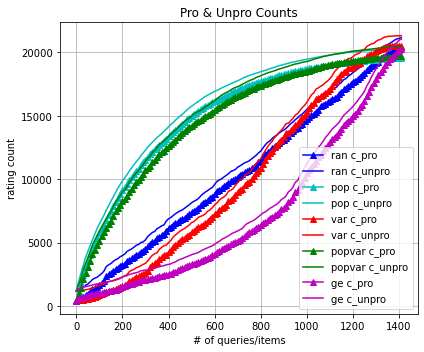

In [222]:
fig, ax = plt.subplots(figsize=(6, 5))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(y_axis, results[i][1]['c_pro'], m+'^', label=results[i][0]+' c_pro')
    ax.plot(y_axis, results[i][1]['c_unpro'], m, label=results[i][0]+' c_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('rating count')
plt.title('Pro & Unpro Counts')
plt.show()
# plt.savefig('./plots/all_methods_rmse_2core.png', dpi=300)

# something is off about this stupid thing!

In [223]:
# results

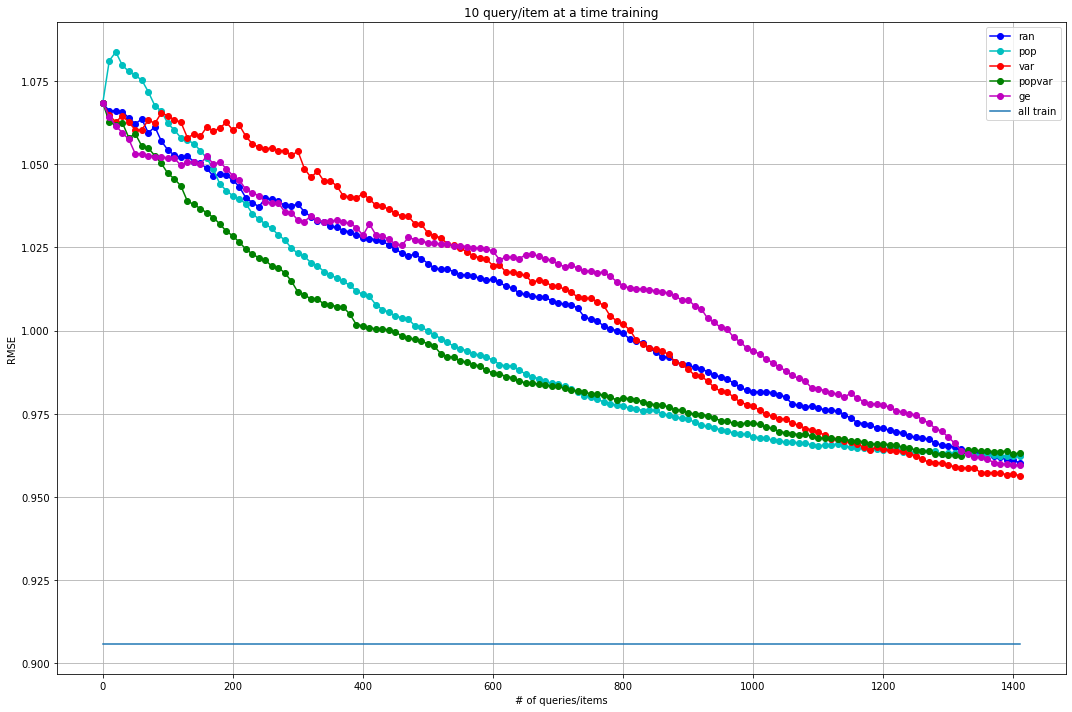

In [224]:
fig, ax = plt.subplots(figsize=(15,10))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    ax.plot(y_axis[:], results[i][1]['rmse'], m, label=results[i][0])
ax.plot(y_axis[:], [fin_acc]*len(y_axis),'-', label='all train')           
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('RMSE')
plt.title('%s query/item at a time training'%w)

plt.show()
# plt.savefig('./plots/all_methods_rmse_2core.png', dpi=300)

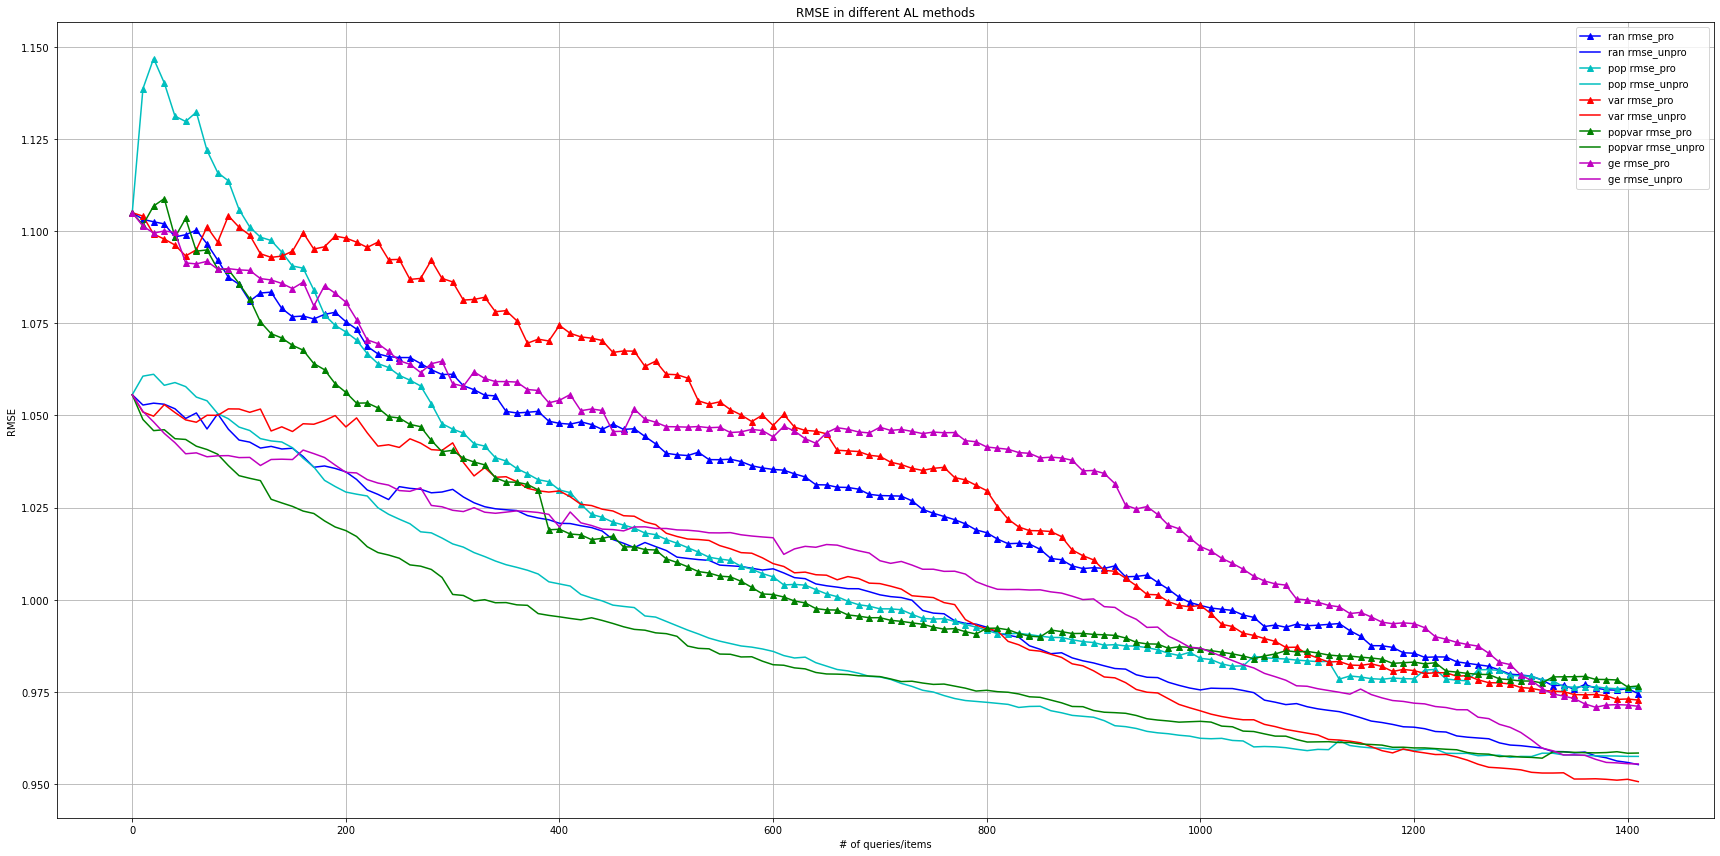

In [232]:
fig, ax = plt.subplots(figsize=(24,12))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(y_axis, results[i][1]['rmse_pro'], m+'^', label=results[i][0]+' rmse_pro')
    ax.plot(y_axis, results[i][1]['rmse_unpro'], m, label=results[i][0]+' rmse_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('RMSE')
plt.title('RMSE in different AL methods')
plt.show()
# plt.savefig('./plots/all_methods_rmse_2core.png', dpi=300)

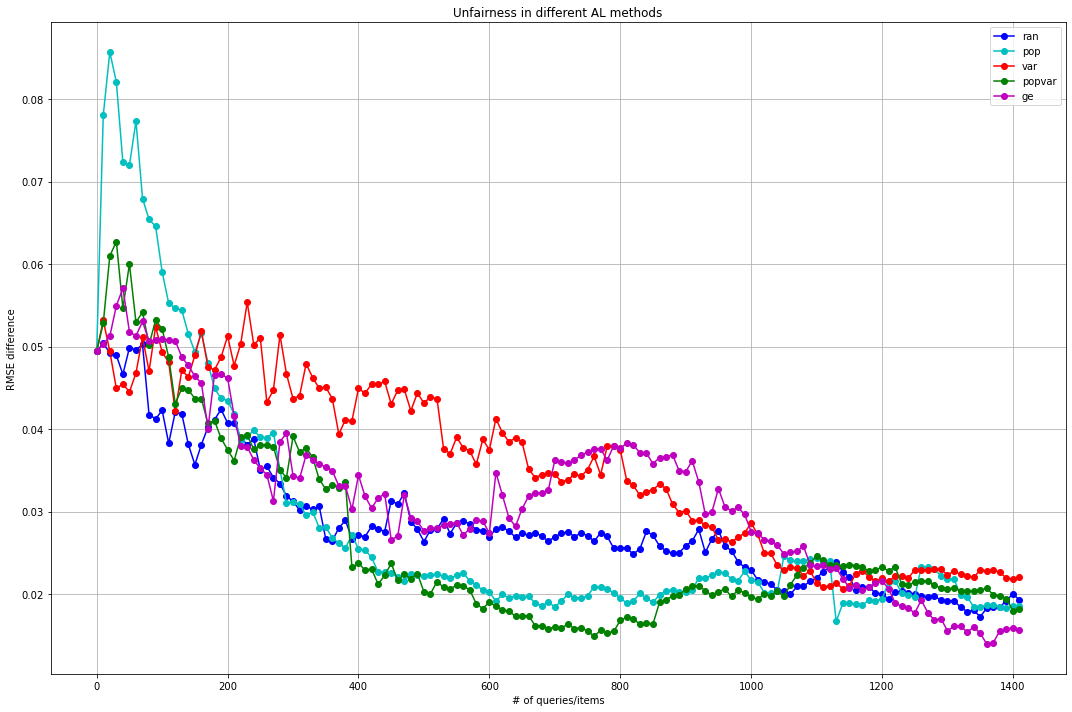

In [226]:
fig, ax = plt.subplots(figsize=(15,10))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    rmse_diff = [a-b for a, b in zip(results[i][1]['rmse_pro'], results[i][1]['rmse_unpro'])]
    ax.plot(y_axis[:], rmse_diff, m, label=results[i][0])
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('RMSE difference')
plt.title('Unfairness in different AL methods')

plt.show()
# plt.savefig('./plots/all_methods_rmse_2core.png', dpi=300)

- Genre for different genders
- 0.2 data, how many male vs female
- Over-sample experiment
- Build separate models for male, and female
    - Are their rating behavior the same?
- BPR - more resistent to popularity bias
- Inverse popularity method (novelty)
- What are the items that females rate more? give them to men to rate. Also reverse: give action-movie ratings to women to rate?
- Cascading female ratings? (how)
- User partitioning (grouping the users)
- Accuracy of female increased or stayed the same? maleaccuracy decreased or stayed the same?